# **Introduction** 
---

Semantic Role Labeling (SRL) is the task of automatically labelling the semantic roles of each argument according to each predicate in a passage. **Predicates** (e.g., bought, sell, purchasing) represent events, and each sentence can have more than one predicate. **Semantic roles** express the abstract roles that predicate arguments can take in the event. Typical semantic arguments include Agent, Patient, and Instrument, and also adjunctive arguments indicating Locative, Temporal, Manner, Cause, and other aspects. Recognizing and labeling semantic arguments is a key task for answering "Who", "When", "What", "Where", and "Why" questions in Information Extraction, Question Answering, Summarization, and, in general, in all NLP tasks in which some kind of semantic interpretation is needed.

The following sentence, exemplifies the annotation of semantic roles:

[Arg0 He ] would n't accept [Arg1 anything of value ] from [Arg2 those he was writing about ] .

Here, the roles for the **predicate 'accept'** (that is, the roleset of the predicate) are defined in the PropBank Frames scheme as: \\

> **Arg0**: Agent \\
**Arg1**: Patient \\
**Arg2**: Instrument, benefactive, attribute \\
**ArgM-LOC**: Locative modifiers indicate where some action takes place. The notion of a locative is not
restricted to physical locations, but abstract locations are being marked as LOC as well, as "[in his speech]-LOC he was talking about …".  \\
**ArgM-TMP**: Temporal ArgMs show when an action took place, such as "in 1987", "last Wednesday","soon" or "immediately". Also included in this category are adverbs of frequency (eg. often
always, sometimes), adverbs of duration
(for a year/in an year), order (eg. first), and repetition (eg. again)..  

<a name="outline"></a>
## **Project outline and module breakdown**
- [Part 1](#part1) Preparing Data
- [Part 2](#part2) LSTM Encoder implementation
  - [Implement LSTM Encoder Model](#l2)
      - Initialization
      - Forward 
- [Part 3](#part3) SRL Model Implementation
  - [Implement Encoder-Decoder Model](#l4) 
    - Encoder
      - Initialization
      - Forward
    - Decoder 
      - Initialization
      - Forward
      - Step

  - Get Entity level F1 score on the validation set
  - Perform hyperparamter tuning by Bayesian Optimization

<a name="part1"></a>
[[^^^]](#outline) 
# **Part 1: Preparing Data**

In this part, data will be converted into a format that can be passed through both of our models.


In [ ]:
# Installing gensim (if needed)
!pip install -U gensim
!pip install sentencepiece
!pip install numpy==1.22

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import Counter, namedtuple
from itertools import chain
import json
import math
import os
from pathlib import Path
import random
import time
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Dict, Set, Union
import sys
from sklearn.metrics import f1_score

import gensim
import nltk
import matplotlib.pyplot as plt 
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
import numpy as np
import sentencepiece as spm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.utils
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence


from tqdm.notebook import tqdm, trange

##1.1: Data Loading
First, load in the data from my Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### TODO : please modify the line below with your drive organization ###
path = "/content/drive/MyDrive/semantic-role-labeling"
with open(os.path.join(path,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(path,'valid.json'), 'r') as f:
     val = json.loads(f.read())

with open(os.path.join(path,'test.json'), 'r') as f:
     test = json.loads(f.read())

Mounted at /content/drive


## 1.2: Preprocess Data
Currently, the dataset has four fields: 
1. 'text' is a list of a list of tokens(string)
2. 'verb_index' represents the **relative position** of the **predicate verb** in the sentence. (Type: a list of a list of integers)
 
> Example: He would n't accept anything of value from those he was writing about.

> Verb index: 3, because accept is the fourth word of the sentence (indexing starts from zero).


3. 'srl_label' is the semantic role label of every token. (Type: a list of a list of strings) \\

4. 'word_indices' is the index of every word token (Type: a list of a list of integers)

We could try printing out the second training sentence as an example of the dataset. \\
The verb_index here is 4, which means the fifth word of the sentence ("coordinated") is the **predicate**.

In [ ]:
print(train['verb_index'][1]) # relative indices of predicate verbs in the sentence
print(train['text'][1]) # the whole sentence
print(train['words_indices'][1]) # ids of every word token
print(train['srl_frames'][1]) # semantic role label of every token in BIO representation

4
['The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.']
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
['O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### **Converting Labels to Numerical Values**
In addition to converting our tokens to vector representations, we need to convert our labels to numerical representations. We could numerically represent these labels in a dictionary as Label 0, Label 1 etc.: `{"O":0, "B-ARG":1, ...}`.

In [ ]:
srl_map = {'O': 0,
           'B-ARG0': 1,
           'I-ARG0': 2,
           'B-ARG1': 3,
           'I-ARG1': 4,
           'B-ARG2': 5,
           'I-ARG2': 6,
           'B-ARGM-LOC': 7,
           'I-ARGM-LOC': 8,
           'B-ARGM-TMP': 9,
           'I-ARGM-TMP': 10}

def encode_srl_category(category_data: List[List[str]])->List[List[int]]:
  """ Encoding SRL category from a list of strings to a list of integers

  Arguments: 
    category_data (list(list(str))): SRL categories

  Returns:
    encoded category (list(list(int))): Numerical conversions of SRL categories
  """
  encoded_category = []
  for srl_list in category_data:
    encoded_srl_list = []
    for srl in srl_list:
      try:
        encoded_srl_list.append(srl_map[srl])
      except:
        encoded_srl_list.append(0)
    encoded_category.append(encoded_srl_list)
  return encoded_category

We have also provided the `pad_sents` function, which pads all sentences to be the same length, specifically the length of the longest input sentence, using the provided `pad_token`. Finally, we have provided the `Vocab` class that represents the corpus as a `Vocab` object with several helper functions. These are used to preprocess the training set.

In [ ]:
# add paddings to make each sentence of equal length
def pad_sents(sents, pad_token):
    sents_padded = []

    max_len = max([len(sent) for sent in sents])
    sents_padded = [(sent + ([pad_token] * (max_len - len(sent)))) for sent in sents]

    return sents_padded

# build a vocabulary object to store projection information between word and its id
# as well as to transform word tokens to list of padded ids
class Vocab(object):
    """ Vocabulary, i.e. structure containing either
    src or tgt language terms.
    """
    def __init__(self, word2id=None):
        """ Init Vocab Instance.
        
        :param word2id: dictionary mapping words 2 indices
        :type word2id: dict[str, int]
        """
        if word2id:
            self.word2id = word2id
        else:
            self.word2id = dict()
            self.word2id['<pad>'] = 0   # Pad Token
            self.word2id['<s>'] = 1 # Start Token
            self.word2id['</s>'] = 2    # End Token
            self.word2id['<unk>'] = 3   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        """ Retrieve word's index. Return the index for the unk
        token if the word is out of vocabulary.
        
        :param word: word to look up
        :type word: str
        :returns: index of word
        :rtype: int
        """
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        """ Check if word is captured by Vocab.
        
        :param word: word to look up
        :type word: str
        :returns: whether word is in vocab
        :rtype: bool
        """
        return word in self.word2id

    def __setitem__(self, key, value):
        """ Raise error, if one tries to edit the Vocab directly.
        """
        raise ValueError('vocabulary is readonly')

    def __len__(self):
        """ Compute number of words in Voca.
        
        :returns: number of words in Vocab
        :rtype: int
        """
        return len(self.word2id)

    def __repr__(self):
        """ Representation of Vocab to be used
        when printing the object.
        """
        return 'Vocabulary[size=%d]' % len(self)

    def add(self, word):
        """ Add word to Vocab, if it is previously unseen.
        
        :param word: to add to Vocab
        :type word: str
        :returns: index that the word has been assigned
        :rtype: int
        """
        if word not in self:
            wid = self.word2id[word] = len(self)
            self.id2word[wid] = word
            return wid
        else:
            return self[word]

    def words2indices(self, sents):
        """ Convert list of words or list of sentences of words
        into list or list of list of indices.
        
        :param sents: sentence(s) in words
        :type sents: Union[List[str], List[List[str]]]
        :returns: sentence(s) in indices
        :rtype: Union[List[int], List[List[int]]]
        """
        if type(sents[0]) == list:
            return [[self[w] for w in s] for s in sents]
        else:
            return [self[w] for w in sents]

    def indices2words(self, word_ids):
        """ Convert list of indices into words.
        
        :param word_ids: list of word ids
        :type word_ids: List[int]
        :returns: list of words
        :rtype: List[Str]
        """
        return [self.id2word[w_id] for w_id in word_ids]

    def to_input_tensor(self, sents: List[List[str]], device: torch.device) -> torch.Tensor:
        """ Convert list of sentences (words) into tensor with necessary padding for 
        shorter sentences.
        
        :param sents: list of sentences (words)
        :type sents: List[List[str]]
        :param device: Device on which to load the tensor, ie. CPU or GPU
        :type device: torch.device
        :returns: Sentence tensor of (max_sentence_length, batch_size)
        :rtype: torch.Tensor
        """
        word_ids = self.words2indices(sents)
        sents_t = pad_sents(word_ids, self['<pad>'])
        sents_var = torch.tensor(sents_t, dtype=torch.long, device=device)
        return sents_var

    @staticmethod
    def from_corpus(corpus, size, remove_frac=None, freq_cutoff=None): 
        """ Given a corpus construct a Vocab.
        
        :param corpus: corpus of text produced by read_corpus function
        :type corpus: List[str]
        :param freq_cutoff: if word occurs n < freq_cutoff times, drop the word
        :type freq_cutoff: int
        :returns: Vocab instance produced from provided corpus
        :rtype: Vocab
        """
        vocab_entry = Vocab()
        word_freq = Counter(chain(*corpus))
        if freq_cutoff is None:
            freq_cutoff = 1
        valid_words = [w for w, v in word_freq.items() if v >= freq_cutoff]
        print('number of word types: {}, number of word types w/ frequency >= {}: {}'
              .format(len(word_freq), freq_cutoff, len(valid_words)))
        top_words = sorted(valid_words, key=lambda word: word_freq[word], reverse=True)
        if remove_frac is not None:
            size = len(top_words) - int(remove_frac * len(top_words))
            top_words = top_words[:size]
            print(f'number of unique words retained with remove_frac={remove_frac}: {len(top_words)}')
        for word in top_words:
            vocab_entry.add(word)
        return vocab_entry
    
    @staticmethod
    def from_subword_list(subword_list):
        """Given a list of subwords, construct the Vocab.
        
        :param subword_list: list of subwords in corpus
        :type subword_list: List[str]
        :returns: Vocab instance produced from provided list
        :rtype: Vocab
        """
        vocab_entry = Vocab()
        for subword in subword_list:
            vocab_entry.add(subword)
        return vocab_entry


# **Part 2: LSTM Encoder Model**

<a name="part2"></a>

We are using a single layer LSTM to predict Semantic Role Labels in our first model.

Input: word tokens $\vec{x}_1,\vec{x}_2, \dots, \vec{x}_k$ and index $i$ of the verb ($\vec{x}_i$) in the sentence \

In the neural network:
1.   Pass each word embedding to the LSTM and get the corresponding LSTM hidden layer.
2.   Get hidden state of the predicate in the sentence
2.   Concatenate the hidden states with the predicate hidden state.
3.   Pass the concatenated embedding through a linear layer to generate output


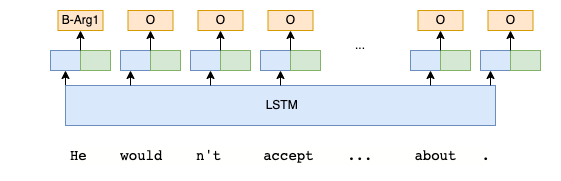

In [ ]:
# Setting seed ***DO NOT MODIFY***
torch.manual_seed(123)

print('initialize train vocabulary ..')
src_vocab = Vocab.from_corpus(train['text'], 20000, remove_frac=0.3) 

initialize train vocabulary ..
number of word types: 19082, number of word types w/ frequency >= 1: 19082
number of unique words retained with remove_frac=0.3: 13358


In [ ]:
train_data = list(zip(train['text'],train['verb_index'],encode_srl_category(train['srl_frames'])))
val_data = list(zip(val['text'], val['verb_index'], encode_srl_category(val['srl_frames'])))

In [ ]:
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
print(get_device())

cuda:0


## 2.1 Implementation
Implement single-layer LSTM.
<a name="l2"></a>

In [ ]:
from torch import lstm
class LSTMTagger(nn.Module):
    def __init__(self, src_vocab, embed_dim,
    hidden_dim, output_dim, vocab_size, num_layers=1):
        '''
        src_vocab: vocabulary of inputs (Class Vocab)
        embed_dim: dimension of word embedding
        hidden_dim: dimension of hidden layer
        output_dim: dimension of tagset_size
        vocab_size: vocabulary size
        num_layers: number of LSTM layers 
        '''
        super(LSTMTagger, self).__init__()
        self.src_vocab = src_vocab
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim

        ### Initialize three linear layers:
              # 1. A word embedding layer
              # 2. A LSTM layer
              # 3. An output linear layer
        ### Initialize logsoftmax
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, max_norm=True)
        self.LSTM = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.W = nn.Linear(in_features=2 * hidden_dim, out_features=output_dim)
        self.LogSoftmax = nn.LogSoftmax(dim=2)

    def compute_Loss(self, criterion, predicted_vector, gold_label):
        loss = 0
        for n in range(len(predicted_vector)): # batch size
            loss += criterion(predicted_vector[n], gold_label[n])	
        return loss

    def forward(self, source: List[List[str]], verb_indices:List[int]):
        ### GOALS : Write the forward function such that it processes sentences. 
        ### GOALS : Return output of the logsoftmax across all time steps
       
        #pad input sentences and conver to word index 
        source_padded = self.src_vocab.to_input_tensor(source, device=get_device())
        batch_size = source_padded.shape[0]
        time_steps = source_padded.shape[1]

        #set up outputs dimension
        output = torch.zeros(batch_size, time_steps, self.output_dim).to(get_device())


        #Convert word index to embedding
        embeddings = self.embedding(source_padded)

        #Pass inputs to the lstm layer
        output, _ = self.LSTM(embeddings)

        #Get hidden state of verb in the sentence
        h_verb = []
        for i, verb_index in enumerate(verb_indices):
            h_verb.append(output[i][verb_index])


        #Iterate over the time dimension: 
        #    - Concatenate verb hidden state to the hidden layer output of every token
        #    - Predict SRL tag distribution with output layer and logsoftmax
        h_concat = torch.zeros((len(verb_indices), time_steps, 2 * len(h_verb[0]))).to(get_device())
        for t in range(time_steps):
            for i in range(len(verb_indices)):
                assert h_concat[i][t].shape == torch.cat((output[i][t], h_verb[i]), dim=0).shape,\
                str(output[i][t].shape) + " " + str(h_verb[i].shape) + " " + str(h_concat[i][t].shape)
                h_concat[i][t] = torch.cat((output[i][t], h_verb[i]), dim=0)
        output = self.W(h_concat)

        return self.LogSoftmax(output)


    def load_model(self, save_path):
        saved_model = torch.load(save_path)
        self.load_state_dict(saved_model.state_dict())

    def save_model(self, save_path):
        torch.save(self, save_path)


In [ ]:
# divide data into batches
def batch_iter(data, batch_size, shuffle=False):
    """ Yield batches of input sentence, verb indices, target output labels 
    :param data: list of tuples containing source and target sentence. ie.
        (list of (src_sent, tgt_sent))
    :type data: List[Tuple[List[str], List[str], List[str]]]
    :param batch_size: batch size
    :type batch_size: int
    :param shuffle: whether to randomly shuffle the dataset
    :type shuffle: boolean
    """
    batch_num = math.ceil(len(data) / batch_size)
    index_array = list(range(len(data)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]
        examples = [data[idx] for idx in indices]

        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
        srl = [e[0] for e in examples]
        verb_index = [e[1] for e in examples]
        target = [e[2] for e in examples]

        yield srl, verb_index, target

In [ ]:
# Setting seed ***DO NOT MODIFY***
torch.manual_seed(123)

def evaluation(model, val_data, optimizer, criterion, batch_size=64):
  model.eval()
  loss = 0
  correct = 0
  total = 0
  batch = 0
  for (input_batch, verb_indices, expected_out) in tqdm(batch_iter(val_data, batch_size=batch_size, shuffle=True)):
    output = model.forward(input_batch, torch.tensor(verb_indices).to(get_device()))
    total += output.size()[0] * output.size()[1]
    _, predicted = torch.max(output, 2)
    expected_out = torch.tensor(pad_sents(expected_out,0))
    correct += (expected_out.to("cpu") == predicted.to("cpu")).cpu().numpy().sum()

    loss += model.compute_Loss(criterion, output.to("cpu"), expected_out.to("cpu"))
    batch += 1
  loss /= batch
  print("Validation Loss: " + str(loss.item()))
  print("Validation Accuracy: " + str(correct/total))
  print()
  return loss.item()

In [ ]:
# Setting seed ***DO NOT MODIFY***
torch.manual_seed(123)

def train_epoch(model, train_data, optimizer, criterion,batch_size=64):
  model.train()
  total = 0
  batch = 0
  total_loss = 0
  correct = 0
  for (input_batch, verb_indices, expected_out) in tqdm(batch_iter(train_data, batch_size=batch_size, shuffle=True)):
    optimizer.zero_grad()
    batch += 1
    output = model.forward(input_batch, torch.tensor(verb_indices).to(get_device()))
    total += output.size()[0] * output.size()[1]
    _, predicted = torch.max(output, 2)

    expected_out = torch.tensor(pad_sents(expected_out,0))
    correct += (expected_out.to("cpu") == predicted.to("cpu")).cpu().numpy().sum()
    
    loss = model.compute_Loss(criterion, output.to("cpu"), expected_out.to("cpu")) 
    total_loss += loss.item()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step() 
  print("Loss: " + str(total_loss/batch))
  print("Training Accuracy: " + str(correct/total))
  return total_loss/batch

In [ ]:
# Setting seed ***DO NOT MODIFY***
torch.manual_seed(123)

def train_and_evaluate(number_of_epochs, model, train_data, val_data, criterion, min_loss=0, lr=.01):
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=.9)
  loss_values = [[],[]]
  for epoch in trange(number_of_epochs, desc="Epochs"):
    cur_loss = train_epoch(model, train_data, optimizer, criterion)
    loss_values[0].append(cur_loss)
    cur_loss_val = evaluation(model, val_data, optimizer, criterion)
    loss_values[1].append(cur_loss_val)
    if cur_loss <= min_loss: return loss_values
  return loss_values

**Train your LSTM Encoder Model** with the following cell:

In [ ]:
embed_dim = 64
hidden_dim = 64
weight = torch.ones(len(srl_map))
weight[0] = 0.25
criterion = nn.NLLLoss(weight=weight)
lstm = LSTMTagger(src_vocab, embed_dim, hidden_dim=hidden_dim, output_dim=len(srl_map), vocab_size=len(src_vocab)).to(get_device())
loss = train_and_evaluate(10, lstm, train_data, val_data, criterion, min_loss=0.2, lr= .05)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Loss: 50.669661631950966
Training Accuracy: 0.9074075827439396


0it [00:00, ?it/s]

Validation Loss: 44.451515197753906
Validation Accuracy: 0.906120867768595



0it [00:00, ?it/s]

Loss: 38.804686207037705
Training Accuracy: 0.9040137607446694


0it [00:00, ?it/s]

Validation Loss: 40.34882354736328
Validation Accuracy: 0.8902841862416108



0it [00:00, ?it/s]

Loss: 34.23510415737446
Training Accuracy: 0.9040190976607891


0it [00:00, ?it/s]

Validation Loss: 37.749000549316406
Validation Accuracy: 0.8811336717428088



0it [00:00, ?it/s]

Loss: 30.641152409406807
Training Accuracy: 0.9085873188222817


0it [00:00, ?it/s]

Validation Loss: 35.71025085449219
Validation Accuracy: 0.8787838696020321



0it [00:00, ?it/s]

Loss: 28.105072764249947
Training Accuracy: 0.9118902419717436


0it [00:00, ?it/s]

Validation Loss: 34.235137939453125
Validation Accuracy: 0.8863565811258278



0it [00:00, ?it/s]

Loss: 26.082427052351143
Training Accuracy: 0.9153139041832795


0it [00:00, ?it/s]

Validation Loss: 32.59901428222656
Validation Accuracy: 0.8954981435643564



0it [00:00, ?it/s]

Loss: 24.31319224834442
Training Accuracy: 0.9192199061056595


0it [00:00, ?it/s]

Validation Loss: 32.970821380615234
Validation Accuracy: 0.8827930174563591



0it [00:00, ?it/s]

Loss: 22.882438907256493
Training Accuracy: 0.9223879654622658


0it [00:00, ?it/s]

Validation Loss: 32.80124282836914
Validation Accuracy: 0.8850933305369127



0it [00:00, ?it/s]

Loss: 21.634955470378582
Training Accuracy: 0.9251648604880943


0it [00:00, ?it/s]

Validation Loss: 32.78266906738281
Validation Accuracy: 0.8872972129783694



0it [00:00, ?it/s]

Loss: 20.520922752527092
Training Accuracy: 0.9283257804234892


0it [00:00, ?it/s]

Validation Loss: 32.36629867553711
Validation Accuracy: 0.8875882475083057



## 2.1 Get Entity level F1 score on the validation set

Run the cells below to calculate F1 score on the validation set.



In [ ]:
def format_output_labels(token_labels, token_indices):
    """
    Returns a dictionary that has the labels (ARG0,ARG1,ARG2,TMP,LOC) as the keys, 
    with the associated value being the list of entities predicted to be of that key label. 
    Each entity is specified by its starting and ending position indicated in [token_indices].

    :parameter token_labels: A list of token labels 
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = {"ARG0":[], "ARG1":[], "ARG2":[], "LOC":[],"TMP":[]}
    prev_label = 'O'
    start = token_indices[0]
    for idx, label in enumerate(token_labels):
      curr_label = label.split('-')[-1]
      if label.startswith('B-') or curr_label != prev_label:
        if prev_label != 'O':
          label_dict[prev_label].append((start, token_indices[idx-1]))
        if curr_label != 'O':
          start = token_indices[idx]
        else:
          start = None
      
      prev_label = curr_label

    if start is not None and prev_label != 'O':
      label_dict[prev_label].append((start, token_indices[idx]))
    return label_dict

In [ ]:
# Code for mean F1

def mean_f1(y_pred_dict, y_true_dict):
    F1_lst = []
    for key in y_true_dict:
        TP, FN, FP = 0, 0, 0
        num_correct, num_true = 0, 0
        preds = y_pred_dict[key]
        trues = y_true_dict[key]
        for true in trues:
            num_true += 1
            if true in preds:
                num_correct += 1
            else:
                continue
        num_pred = len(preds)
        if num_true != 0:
            if num_pred != 0 and num_correct != 0:
                R = num_correct / num_true
                P = num_correct / num_pred
                F1 = 2*P*R / (P + R)
            else:
                F1 = 0      # either no predictions or no correct predictions
        else:
            continue
        F1_lst.append(F1)
    return np.mean(F1_lst)

In [ ]:
#get validation output
inv_srl_map={srl_map[key]:key for key in srl_map}
val_predict = []
val_true = []
val_idx = []

for idx in range(len(val_data)):
  out = lstm.forward([val_data[idx][0]], torch.tensor([val_data[idx][1]]))
  _, predicted = torch.max(out, 2)

  len_sent = len(val_data[idx][0])
  result = predicted.cpu().numpy()[0]
  
  for t in range(len_sent):
    val_predict.append(inv_srl_map[result[t]])
    val_true.append(inv_srl_map[val_data[idx][2][t]])

  val_idx.extend(val['words_indices'][idx])

In [ ]:
# Save our model!
# Don't change saved model name here
lstm.save_model("lstm.pth")
lstm.load_model("lstm.pth") 

# **Part 3: Encoder-Decoder Model**

<a name="part3"></a>
We can convert the Semantics Role Labeling task into the format of Question and Answer task.

> For example: [Arg0 He] would n't accept [Arg1 anything of value] from [Arg2 those he was writing about] .  
Given the input sentence **"He would n't accept  anything of value from those he was writing about ."** and predicate **"accept"**, we want to know what is ARG0, ARG1, ARG2, ARGM_TMP, ARGM_LOC in this sentence. Therefore, we can convert each example into 5 question and answer pairs. (The format for the inputs is *predicate [SEPT] setence [SEPT] label we want to find*, where [SEPT] is a separator token. The output is the sequence that corresponds with that label, or empty if that label is not in this sentence.) \
-> Input 1: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARG0\
-> Output 1: $<s>$ He $</s>$\
-> Input 2: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARG1\
-> Output 2: $<s>$ anything of value $</s>$
-> Input 3: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARG2\
-> Output 3: $<s>$ $</s>$ (Explanation: because there's no ARG2 in this sentence) \
-> Input 4: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARGM-TMP\
-> Output 4: $<s>$ $</s>$  \
-> Input 5: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARGM-LOC\
-> Output 5: $<s>$ $</s>$ 

Given the input, we want to use a seq2seq model to predict output. In this section, we describe the training procedure for the proposed encoder-decoder system, which uses a Bidirectional LSTM Encoder and a Unidirectional LSTM with attention Decoder. We'll recap the theoretical component here and in the modules where you are writing code, we will repeat the steps more explicitly in an algorithmic manner.

<Insert diagram here>

Given a sentence in the source language, we look up the word embeddings from an embeddings matrix, yielding $x_1,\dots, x_n$ ($x_i \in R^{e}$), where n is the length of the source sentence and e is the embedding size. We feed these embeddings to the bidirectional encoder, yielding hidden states and cell states for both the forwards (→) and backwards (←) LSTMs. The forwards and backwards versions are concatenated to give hidden states $h_i^{enc}$ and cell state $c_i^{enc}$:


$$h_i^{enc} = [\overrightarrow{h_i^{enc}}; \overleftarrow{h_i^{enc}}] \text{ where }h_i^{enc} \in R^{2h}, \overrightarrow{h_i^{enc}}, \overleftarrow{h_i^{enc}} \in R^{h}$$

$$c_i^{enc} = [\overrightarrow{c_i^{enc}}; \overleftarrow{c_i^{enc}}] \text{ where }c_i^{enc} \in R^{2h}, \overrightarrow{c_i^{enc}}, \overleftarrow{c_i^{enc}} \in R^{h}$$


We then initialize the decoder’s first hidden state $h_0^{dec}$ with a linear projection of the encoder’s final hidden state

$$h_0^{dec} = W_h[\overrightarrow{h_n^{enc}}; \overleftarrow{h_0^{enc}}] \text{ where }h_0^{dec} \in R^{h}, W_h \in R^{h \times 2h}$$

And first cell state $c_0^{dec}$ with a linear projection of the encoder’s final cell state

$$c_0^{dec} = W_c[\overrightarrow{c_n^{enc}}; \overleftarrow{c_0^{enc}}] \text{ where }c_0^{dec} \in R^{h}, W_c \in R^{h \times 2h}$$



With the decoder initialized, we must now feed it a target sentence. On the $t^{th}$ step, we look up the embedding for the $t^{th}$ word, $y_t \in R^{e}$. We then concatenate $y_t$ with the combined-output vector $o_{t−1} \in R^{h}$ from the previous timestep (we will explain in detail what this is later, but it is just the output from the previous step) to produce $\bar{y_t} \in R^{e+h}$. Note that for the first target (i.e. the start token), $o_0$ is usually a zero-vector (but it can be random or a learned vector as well). We then feed $y_t$ as input to the decoder.

$$ h_t^{dec} = Decoder(\bar{y_t}, (h_{t-1}^{dec},c_{t-1}^{dec}))\text{ where }h_{t-1}^{dec} ∈ R^{h}$$

We can take the decoder hidden state $h_t^{dec}$ and concatenate with attention context vector $a_t$
$$u_t = [h_t^{dec},a_t] \in R^{3h}$$

Then we pass $u_t$ through a linear layer and an activation function like tanh to obtain our combined-output vector $o_t$:

$$v_t = W_v u_t \text{ where } W_v \in R^{h \times 3h}, v_t \in R^{h}$$

Then, we produce a probability distribution $P_t$ over target words at the $t^{th}$ timestep.

$$P_t = Softmax(W_{v_{target}} v_t) \text{ where }P_t \in R^{V_{target}}, W_{v_{target}}\in R^{V_{target} \times h}$$


Here, $V_{target}$ is the size of the target vocabulary. Finally, to train the network we then compute the softmax cross entropy loss between $P_t$ and $g_t$, where $g_t$ is the one-hot vector of the target word at timestep t:

$$Loss(Model) = CrossEntropy(P_t, g_t)$$

Now that we have described the model, let’s try implementing it for the SRL task.

**How we get $a_t$ attention context vector:**

At the beginning of the decoder step, first we need to project encoder hidden states from $ R^{2h}$ to $ R^{h}$

$$h_i^{enc-projection} = W_a h_i^{enc}, W_a \in R^{h \times 2h}, \forall i$$

Then at each decoder step, we compute dot product similarity between $h_t^{dec}$ and $h_i^{enc-projection}, \forall i$:
$$score(h_t^{dec},h_i^{enc-projection}) = h_t^{dec} \cdot h_i^{enc-projection}$$
Softmax the scores to create vector of weights:
$$\alpha_t = softmax(score(h_t^{dec},h_i^{enc-projection}),\forall i)$$
Take the weighted average over all encoder hidden states
$$a_t = \alpha_t \cdot h_t^{enc} \in R^{2h}$$

## 3.1 Preprocess the data

The code here converts raw dataset to the input and output format mentioned above.

In [ ]:
srl_frames = ["ARGM-TMP", "ARG0", "ARG1", "ARG2", "ARGM-LOC"]
def get_srl_frames_indices(token_labels, token_indices):
    label_dict = {"ARGM-TMP":[], "ARG0":[], "ARG1":[], "ARG2":[], "ARGM-LOC":[]}
    prev_label = 'O'
    start = token_indices[0]
    for idx, label in enumerate(token_labels):
      curr_label = '-'.join(label.split('-')[1:]) if label != 'O' else 'O'
      if label.startswith("B-") or (curr_label != prev_label and curr_label != "O"):
        if prev_label != "O":
          label_dict[prev_label].append((start, token_indices[idx-1]))
        start = token_indices[idx]
      elif label == "O" and prev_label != "O":
        label_dict[prev_label].append((start, token_indices[idx-1]))
        start = None
      prev_label = curr_label
    if start is not None and prev_label != 'O':
      label_dict[prev_label].append((start, token_indices[idx-1]))
    return label_dict

In [ ]:
SEPT = 'SEP_T'
def generate_source_corpus(source_text: List[List[str]], source_verb: List[List[str]]):
  assert len(source_text) == len(source_verb)
  return\
  [[source_text[i][source_verb[i]]]+ [SEPT] + [token for token in source_text[i]] + [arg] for i in range(len(source_text)) for arg in srl_frames]

In [ ]:
def generate_target_corpus(source_text: List[List[str]], source_verb: List[List[str]], source_srl: List[List[str]], source_indices: List[List[str]]):
  assert len(source_text) == len(source_verb)
  assert len(source_text) == len(source_srl)

  ans = []
  for i in range(len(source_text)):
    text = source_text[i]
    verb = text[source_verb[i]]
    srl = source_srl[i]
    indices = source_indices[i]
    indice_start = indices[0]
    label_dict = get_srl_frames_indices(srl, indices)
    for key in label_dict.keys():
      arg_lst = []
      for arg_idx in label_dict[key]:
        arg_lst += text[(arg_idx[0] - indice_start):(arg_idx[1]- indice_start +1)]
      ans += [['<s>'] +[token for token in arg_lst] + ['</s>']]

  return ans

The following cell builds a combined vocab dictionary for input (source) and output (target). Both will share the same vocabulary. 

In [ ]:
train_src_corpus = generate_source_corpus(train['text'], train['verb_index'])
train_tgt_corpus = generate_target_corpus(train['text'], train['verb_index'], train['srl_frames'], train['words_indices'])
train_data = list(zip(train_src_corpus, train_tgt_corpus))

val_src_corpus = generate_source_corpus(val['text'], val['verb_index'])
val_tgt_corpus = generate_target_corpus(val['text'], val['verb_index'], val['srl_frames'], val['words_indices'])
val_data = list(zip(val_src_corpus, val_tgt_corpus))

#generate src_vocab
src_vocab = Vocab.from_corpus(np.array(train_src_corpus + val_src_corpus+train_tgt_corpus+val_tgt_corpus), 20000, remove_frac=0.3)
tgt_vocab = src_vocab

number of word types: 19871, number of word types w/ frequency >= 1: 19871
number of unique words retained with remove_frac=0.3: 13910


<ipython-input-26-2a2715392125>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  src_vocab = Vocab.from_corpus(np.array(train_src_corpus + val_src_corpus+train_tgt_corpus+val_tgt_corpus), 20000, remove_frac=0.3)


You can print out our converted inputs & outputs here:

In [ ]:
print(f"train['text'] is {train['text'][1]}")
print(f"train['srl_frames'] is {train['srl_frames'][1]}")
print(f'train_src_corpus is {train_src_corpus[7]}')
print(f'train_tgt_corpus is {train_tgt_corpus[7]}')

train['text'] is ['The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.']
train['srl_frames'] is ['O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
train_src_corpus is ['coordinated', 'SEP_T', 'The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.', 'ARG1']
train_tgt_corpus is ['<s>', 'offensive', '</s>']


The following cell loads pretrained GloVe embeddings and stores the embedding for each word in the vocabulary to `src_embeddings`. These embeddings will be used to initialize the learned embeddings in the models:

In [ ]:
import gensim.downloader as api
model= api.load("glove-wiki-gigaword-300")
torch.manual_seed(1)
#obtain src_embeddings
src_embeddings = []
for i, word in enumerate(src_vocab.word2id.keys()):
    try: 
        src_embeddings.append(model[word])
    except:
        src_embeddings.append(torch.rand(300))

src_embeddings = np.stack(src_embeddings, 0)
src_embeddings = torch.from_numpy(src_embeddings)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
Hypothesis = namedtuple('Hypothesis', ['value', 'score'])

<a name="l4"></a>
## 3.2 Implementation
Your next task is to **implement the Encoder-Decoder model  by finishing the #TODOs**.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, embed_size, hidden_size, source_embeddings):
        """
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.embedding = source_embeddings


        ### Initialize the following variables:
        ###     self.encoder (Bidirectional LSTM with bias)
        ###     self.h_projection (Linear Layer with bias),called W_{h} above.
        ###     self.c_projection (Linear Layer with bias),called W_{c} above.

        self.encoder = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size, batch_first=False, bidirectional=True, bias=True)
        self.h_projection = nn.Linear(in_features=2 * self.hidden_size, out_features=self.hidden_size)
        self.c_projection = nn.Linear(in_features=2 * self.hidden_size, out_features=self.hidden_size)

        
    def forward(self, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:

        ###     1. Construct Tensor `X` by embedding the input. The result should have shape (b, src_len, e)
        ###         b = batch size, src_len = maximum source sentence length, e = embedding size. Note
        ###         that there is no initial hidden state or cell for the decoder.
        ###         Note: you should study the equations/mathematical definitions above to determine
        ###         what some of these values should be.  The same holds throughout.
        ###     2. Compute `enc_hiddens`, `last_hidden`,  `last_cell_state` by applying the LSTM encoder to `X`. 
        ###     3. Compute 
        ###         - `init_decoder_hidden`:
        ###             `last_hidden` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
        ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
        ###             Apply the h_projection layer to this in order to compute init_decoder_hidden.
        ###             This is h_0^{dec} in above in the writeup. Here b = batch size, h = hidden size
        ###         - `init_cell_hidden`:
        ###             `last_cell_state` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
        ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
        ###             Apply the c_projection layer to this in order to compute init_decoder_hidden.
        ###             This is c_0^{dec} in above in the writeup. Here b = batch size, h = hidden size        

        enc_hiddens, dec_init_state = None, None
        
        #1 
        embedding = self.embedding(source_padded)
        X = nn.utils.rnn.pack_padded_sequence(embedding, source_lengths, batch_first=True)

        #2
        enc_hiddens, (last_hidden, last_cell_state) = self.encoder(X)
        (enc_hiddens, _) = nn.utils.rnn.pad_packed_sequence(enc_hiddens, batch_first=True)

        #3 concatenate last hidden embed from both direction and with a linear projection
        before_hidden_projection = torch.cat(tensors=(last_hidden[0], last_hidden[1]), dim=1)
        init_decoder_hidden = self.h_projection(before_hidden_projection)

        #4 concatenate last cell state from both direction and with a linear projection 
        before_cell_projection = torch.cat(tensors=(last_cell_state[0], last_cell_state[1]), dim=1)
        init_cell_state = self.c_projection(before_cell_projection)

        
        dec_init_state = (init_decoder_hidden, init_cell_state)

        return enc_hiddens, dec_init_state

In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, target_embedding, device):
        """
        """
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.device = device
        self.embedding = target_embedding
        output_vocab_size = self.embedding.weight.size(0)
        self.softmax = nn.Softmax(dim=1)
        self.att_projection = nn.Linear(in_features=self.hidden_size * 2,
                                        out_features=self.hidden_size,
                                        bias=False)

        ###     self.decoder (LSTM Cell with bias)
        ###     self.combined_output_projection (Linear Layer with no bias), called W_{v} above.
        ###     self.target_vocab_projection (Linear Layer with no bias), called W_{target} above.

        self.decoder = nn.LSTMCell(input_size=self.hidden_size + self.embed_size, hidden_size=self.hidden_size, bias=True)
        self.combined_output_projection = nn.Linear(in_features=3 * self.hidden_size, out_features=self.hidden_size, bias=False)
        self.target_vocab_projection = nn.Linear(in_features=self.hidden_size, out_features=output_vocab_size, bias=False)

    
    def forward(self, enc_hiddens: torch.Tensor,
                dec_init_state: Tuple[torch.Tensor, torch.Tensor], target_padded: torch.Tensor) -> torch.Tensor:
        # Chop off the <END> token for max length sentences.
        target_padded = target_padded[:,:-1]

        dec_state = dec_init_state

        # Initialize previous combined output vector o_{t-1} as zero
        batch_size = enc_hiddens.size(0)
        o_prev = torch.zeros(batch_size, self.hidden_size, device=self.device)

        # Initialize a list we will use to collect the combined output o_t on each step
        combined_outputs = []

        
        ###     1. Construct tensor `Y` by embedding the target sentences. The result should have shape (b, tgt_len, e)
        ###         where b = batch size, tgt_len = maximum target sentence length, e = embedding size.
        ###     2. Construct enc_hiddens_proj by using self.att_projection to project enc_hiddens to shape (b, src_len, h)
        ###     3. Iterate over the time dimension of Y.
        ###         Within the loop, this will give you Y_t of shape (b, 1, e) where b = batch size, e = embedding size.
        ###             - Squeeze Y_t into a tensor of dimension (b, e). 
        ###             - Construct Ybar_t by concatenating Y_t with o_prev on their last dimension
        ###             - Use the step function to compute the the Decoder's next (cell, state) values
        ###               as well as the new combined output o_t.
        ###             - Append o_t to combined_outputs
        ###             - Update o_prev to the new o_t.
        ###     4. Use torch.stack to convert combined_outputs from a list length tgt_len of
        ###         tensors shape (b, h), to a single tensor shape (b, tgt, h)
        ###         where tgt_len = maximum target sentence length, b = batch size, h = hidden size.


        #1:
        Y = self.embedding(target_padded)

        #2:
        enc_hiddens_proj = self.att_projection(enc_hiddens)
        
        #3:
        for t in range(Y.shape[1]):
            Y_t = Y[:, t, :]
            Y_t = torch.squeeze(Y_t, dim=1)
            Ybar_t = torch.cat(tensors=(Y_t, o_prev), dim=-1)
            (dec_hidden, dec_cell), o_t = self.step(Ybar_t, dec_state, enc_hiddens, enc_hiddens_proj)
            dec_state = (dec_hidden, dec_cell)
            combined_outputs.append(o_t)
            o_prev = o_t

        #4:
        combined_outputs = torch.stack(tensors=combined_outputs, dim=1)
        return combined_outputs


    
    
    def step(self, Ybar_t: torch.Tensor,
            dec_state: Tuple[torch.Tensor, torch.Tensor],
            enc_hiddens: torch.Tensor,
            enc_hiddens_proj: torch.Tensor) -> Tuple[Tuple, torch.Tensor]:
        """ Compute one forward step of the LSTM decoder, including the attention computation.

        :param Ybar_t: Concatenated Tensor of [Y_t o_prev], with shape (b, e + h). The input for the decoder,
                                where b = batch size, e = embedding size, h = hidden size.
        :type Ybar_t: torch.Tensor
        :param dec_state: A tuple with two tensors of shape (batch_size, hidden_size) 
    containing the (previous) hidden state and cell state.
        :type dec_state: Tuple[torch.Tensor, torch.Tensor]
        :param enc_hiddens: Encoder hidden states Tensor, with shape (b, src_len, h * 2), where b = batch size,
                                    src_len = maximum source length, h = hidden size.
        :type enc_hiddens: torch.Tensor
        :param enc_hiddens_proj: Encoder hidden states Tensor, projected from (h * 2) to h. Tensor is with shape (b, src_len, h),
                                    where b = batch size, src_len = maximum source length, h = hidden size.
        :type enc_hiddens_proj: torch.Tensor

        :returns dec_state: Tensors with shape (b, h), where b = batch size, h = hidden size.
                Tensor is decoder's new hidden state
        :returns combined_output: Combined output Tensor at timestep t, shape (b, h), where b = batch size, h = hidden size.
        """

        combined_output = None

        ###     0. Apply the decoder to `Ybar_t` and `dec_state` to obtain the new dec_state.
        dec_state = self.decoder(Ybar_t, dec_state)
        (dec_hidden, dec_cell) = dec_state

        ###     1. Use dot product to calculate similarity between enc_hiddens_proj and dec_hidden,
        ###        and then take softmax (this is the attention weight alpha_t)
        ###     2. Dot product attention weight with enc_hiddens to get weighted context embedding a_t
        ###     3. U_t = Concate dec_hidden and a_t
        dec_hidden = torch.reshape(dec_hidden, (dec_hidden.shape[0], dec_hidden.shape[1], 1))
        similarity = enc_hiddens_proj @ dec_hidden
        alpha_t = self.softmax(similarity)
        alpha_t = torch.reshape(alpha_t, (alpha_t.shape[0], 1, alpha_t.shape[1]))
        a_t = alpha_t @ enc_hiddens
        a_t = torch.squeeze(a_t, dim=1)
        dec_hidden = torch.squeeze(dec_hidden, dim=-1)
        u_t = torch.cat(tensors=(dec_hidden, a_t), dim=-1)

        ###     4. Apply the combined output projection layer to U_t to compute tensor V_t
        V_t = self.combined_output_projection(u_t)

        combined_output = V_t
        return dec_state, combined_output

The following class puts together the LSTM Encoder and Decoder with several helper methods that allow the model to generate outputs. No modifications are necessary.

In [ ]:
class SRL(nn.Module):
    """ Simple Semantic Role Labelling Model with:
        - Bidrectional LSTM Encoder
        - Unidirection LSTM Decoder
    """
    def __init__(self, embed_size, hidden_size, src_vocab, tgt_vocab, device=torch.device("cpu"), pretrained_source=None,pretrained_target=None,):
        """ Init SRL Model.

        :param embed_size: Embedding size (dimensionality)
        :type embed_size: int
        :param hidden_size: Hidden Size, the size of hidden states (dimensionality)
        :type hidden_size: int
        :param src_vocab: Vocabulary object containing src language
        :type src_vocab: Vocab
        :param tgt_vocab: Vocabulary object containing tgt language
        :type tgt_vocab: Vocab
        :param device: torch device to put all modules on
        :type device: torch.device
        :param pretrained_source: Matrix of pre-trained source word embeddings
        :type pretrained_source: Optional[torch.Tensor]
        :param pretrained_target: Matrix of pre-trained target word embeddings
        :type pretrained_target: Optional[torch.Tensor]
        """
        super(SRL, self).__init__()
        self.device=device
        self.embed_size = embed_size
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        src_pad_token_idx = src_vocab['<pad>']
        tgt_pad_token_idx = tgt_vocab['<pad>']
        self.source_embedding = nn.Embedding(len(src_vocab), embed_size, padding_idx=src_pad_token_idx)
        
        with torch.no_grad():
            if pretrained_source is not None:
                self.source_embedding.weight.data = pretrained_source
                self.source_embedding.weight.requires_grad = False

        self.target_embedding = self.source_embedding
        self.hidden_size = hidden_size

        # default values
        self.encoder = Encoder(
            embed_size=embed_size,
            hidden_size=hidden_size,
            source_embeddings=self.source_embedding,
        )
        self.decoder = Decoder(
            embed_size=embed_size,
            hidden_size=hidden_size,
            target_embedding=self.target_embedding,
            device=self.device,
        )


    def forward(self, source: List[List[str]], target: List[List[str]]) -> torch.Tensor:
        """ Take a mini-batch of source and target sentences, compute the log-likelihood of
        target sentences under the language models learned by the SRL system.

        :param source: list of source sentence tokens
        :type source: List[List[str]]
        :param target: list of target sentence tokens, wrapped by `<s>` and `</s>`
        :type target: List[List[str]]
        :returns scores: a variable/tensor of shape (b, ) representing the
                                    log-likelihood of generating the gold-standard target sentence for
                                    each example in the input batch. Here b = batch size.
        :rtype: torch.Tensor
        """
        # Compute sentence lengths
        source_lengths = [len(s) for s in source]

        # Convert list of lists into tensors
        source_padded = self.src_vocab.to_input_tensor(source, device=self.device)   
        target_padded = self.tgt_vocab.to_input_tensor(target, device=self.device)  
        
        ###     Run the network forward:
        ###     1. Apply the encoder to `source_padded` by calling `self.encode()`
        ###     2. Apply the decoder to compute combined-output by calling `self.decode()`
        ###     3. Compute log probability distribution over the target vocabulary using the
        ###        combined_outputs returned by the `self.decode()` function.

        enc_hiddens, dec_init_state = self.encode(source_padded, source_lengths)
        combined_outputs = self.decode(enc_hiddens, dec_init_state, target_padded)
        P = F.log_softmax(self.decoder.target_vocab_projection(combined_outputs), dim=-1)

        # Zero out, probabilities for which we have nothing in the target text
        target_masks = (target_padded != self.tgt_vocab['<pad>']).float()
        
        # Compute log probability of generating true target words
        target_gold_words_log_prob = torch.gather(P, index=target_padded[:,1:].unsqueeze(-1), dim=-1).squeeze(-1) * target_masks[:,1:]
        scores = target_gold_words_log_prob.sum(dim=1)
        return scores


    def encode(self, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """ Apply the encoder to source sentences to obtain encoder hidden states.
            Additionally, take the final states of the encoder and project them to obtain initial states for decoder.

        :param source_padded: Tensor of padded source sentences with shape (src_len, b), where
            b = batch_size, src_len = maximum source sentence length. Note that these have
            already been sorted in order of longest to shortest sentence.
        :type source_padded: torch.Tensor
        :param source_lengths: List of actual lengths for each of the source sentences in the batch
        :type source_lengths: List[int]
        :returns: Tuple of two items. The first is Tensor of hidden units with shape (b, src_len, h*2),
            where b = batch size, src_len = maximum source sentence length, h = hidden size. The second is
            Tuple of tensors representing the decoder's initial hidden state and cell.
        :rtype: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]
        """
        return self.encoder(source_padded, source_lengths)


    def decode(self, enc_hiddens: torch.Tensor, dec_init_state: Tuple[torch.Tensor, torch.Tensor], 
               target_padded: torch.Tensor) -> torch.Tensor:
        """Compute combined output vectors for a batch.

        @param enc_hiddens (Tensor): Hidden states (b, src_len, h*2), where
                                     b = batch size, src_len = maximum source sentence length, h = hidden size.
        @param dec_init_state (tuple(Tensor, Tensor)): Initial state and cell for decoder
        @param target_padded (Tensor): Gold-standard padded target sentences (tgt_len, b), where
                                       tgt_len = maximum target sentence length, b = batch size. 

        @returns combined_outputs (Tensor): combined output tensor  (tgt_len, b,  h), where
                                        tgt_len = maximum target sentence length, b = batch_size,  h = hidden size
        """
        return self.decoder(enc_hiddens, dec_init_state, target_padded)


    def beam_search(self, src_sent: List[str], beam_size: int=5, max_decoding_time_step: int=70) -> List[Hypothesis]:
        """ Given a single source sentence, perform beam search, yielding translations in the target language.
        @param src_sent (List[str]): a single source sentence (words)
        @param beam_size (int): beam size
        @param max_decoding_time_step (int): maximum number of time steps to unroll the decoding RNN
        @returns hypotheses (List[Hypothesis]): a list of hypothesis, each hypothesis has two fields:
                value: List[str]: the decoded target sentence, represented as a list of words
                score: float: the log-likelihood of the target sentence
        """
        src_sents_var = self.src_vocab.to_input_tensor([src_sent], self.device)

        src_encodings, dec_init_vec = self.encode(src_sents_var, [len(src_sent)])
        src_encodings_att_linear = self.decoder.att_projection(src_encodings)

        h_tm1 = dec_init_vec
        att_tm1 = torch.zeros(1, self.hidden_size, device=self.device) 

        eos_id = self.tgt_vocab['</s>']

        hypotheses = [['<s>']]
        hyp_scores = torch.zeros(len(hypotheses), dtype=torch.float, device=self.device)
        completed_hypotheses = []

        t = 0
        while len(completed_hypotheses) < beam_size and t < max_decoding_time_step:
            t += 1
            hyp_num = len(hypotheses)

            exp_src_encodings = src_encodings.expand(hyp_num,
                                                     src_encodings.size(1),
                                                     src_encodings.size(2)).to(self.device)

            exp_src_encodings_att_linear = src_encodings_att_linear.expand(hyp_num,
                                                                           src_encodings_att_linear.size(1),
                                                                           src_encodings_att_linear.size(2)).to(self.device)

            y_tm1 = torch.tensor([self.tgt_vocab[hyp[-1]] for hyp in hypotheses], dtype=torch.long, device=self.device)
            y_t_embed = self.target_embedding(y_tm1)

            x = torch.cat([y_t_embed, att_tm1], dim=-1)
          
            h_t, att_t = self.decoder.step(x, h_tm1,
                                exp_src_encodings, exp_src_encodings_att_linear)
            
            h_t, c_t = h_t

            # log probabilities over target words
            log_p_t = F.log_softmax(self.decoder.target_vocab_projection(att_t), dim=-1)

            live_hyp_num = beam_size - len(completed_hypotheses)
            contiuating_hyp_scores = (hyp_scores.unsqueeze(1).expand_as(log_p_t) + log_p_t).view(-1)
            top_cand_hyp_scores, top_cand_hyp_pos = torch.topk(contiuating_hyp_scores, k=live_hyp_num)

            prev_hyp_ids = torch.div(top_cand_hyp_pos, len(self.tgt_vocab), rounding_mode='floor') 
            hyp_word_ids = top_cand_hyp_pos % len(self.tgt_vocab)

            new_hypotheses = []
            live_hyp_ids = []
            new_hyp_scores = []

            for prev_hyp_id, hyp_word_id, cand_new_hyp_score in zip(prev_hyp_ids, hyp_word_ids, top_cand_hyp_scores):
                prev_hyp_id = prev_hyp_id.item()
                hyp_word_id = hyp_word_id.item()
                cand_new_hyp_score = cand_new_hyp_score.item()

                hyp_word = self.tgt_vocab.id2word[hyp_word_id]
                new_hyp_sent = hypotheses[prev_hyp_id] + [hyp_word]
                if hyp_word == '</s>':
                    completed_hypotheses.append(Hypothesis(value=new_hyp_sent[1:-1],
                                                           score=cand_new_hyp_score))
                else:
                    new_hypotheses.append(new_hyp_sent)
                    live_hyp_ids.append(prev_hyp_id)
                    new_hyp_scores.append(cand_new_hyp_score)

            if len(completed_hypotheses) == beam_size:
                break

            live_hyp_ids = torch.tensor(live_hyp_ids, dtype=torch.long, device=self.device)
            h_tm1 = h_t[live_hyp_ids], c_t[live_hyp_ids]
            att_tm1 = att_t[live_hyp_ids]

            hypotheses = new_hypotheses
            hyp_scores = torch.tensor(new_hyp_scores, dtype=torch.float, device=self.device)

        if len(completed_hypotheses) == 0:
            completed_hypotheses.append(Hypothesis(value=hypotheses[0][1:],
                                                   score=hyp_scores[0].item()))

        completed_hypotheses.sort(key=lambda hyp: hyp.score, reverse=True)

        return completed_hypotheses

    @staticmethod
    def load(model_path: str):
        """ Load the model from a file.
        @param model_path (str): path to model
        """
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = SRL(
            src_vocab=params['vocab']['source'],
            tgt_vocab=params['vocab']['target'],
            **args
        )
        model.load_state_dict(params['state_dict'])

        return model

    def save(self, path: str):
        """ Save the odel to a file.
        @param path (str): path to the model
        """
        print('save model parameters to [%s]' % path, file=sys.stderr)

        params = {
            'args': dict(embed_size=self.embed_size, hidden_size=self.hidden_size),
            'vocab': dict(source=self.src_vocab, target=self.tgt_vocab),
            'state_dict': self.state_dict()
        }

        torch.save(params, path)

In [ ]:
def batch_iter(data, batch_size, shuffle=False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    :param data: list of tuples containing source and target sentence. ie.
        (list of (src_sent, tgt_sent))
    :type data: List[Tuple[List[str], List[str]]]
    :param batch_size: batch size
    :type batch_size: int
    :param shuffle: whether to randomly shuffle the dataset
    :type shuffle: boolean
    """
    batch_num = math.ceil(len(data) / batch_size)
    index_array = list(range(len(data)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]
        examples = [data[idx] for idx in indices]

        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
        src_sents = [e[0] for e in examples]
        tgt_sents = [e[1] for e in examples]

        yield src_sents, tgt_sents

In [ ]:
def evaluate_ppl(model, val_data, batch_size=32):
    """ Evaluate perplexity on dev sentences
    :param model: SRL Model
    :type model: SRL
    :param dev_data: list of tuples containing source and target sentence.
        i.e. (list of (src_sent, tgt_sent))
    :param val_data: List[Tuple[List[str], List[str]]]
    :param batch_size: size of batches to extract
    :type batch_size: int
    :returns ppl: perplexty on val sentences
    """
    was_training = model.training
    model.eval()

    cum_loss = 0.
    cum_tgt_words = 0.

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for src_sents, tgt_sents in batch_iter(val_data, batch_size):
            loss = -model(src_sents, tgt_sents).sum()

            cum_loss += loss.item()
            tgt_word_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
            cum_tgt_words += tgt_word_num_to_predict

        ppl = np.exp(cum_loss / cum_tgt_words)

    if was_training:
        model.train()

    return ppl

In [ ]:
def train_and_evaluate(model, train_data, val_data, optimizer, train_batch_size=32, clip_grad=2, log_every = 100, 
                       valid_niter = 500, model_save_path="srl.ckpt", num_epoch=6):
    num_trail = 0
    cum_examples = report_examples = epoch = valid_num = 0
    hist_valid_scores = []
    train_iter = patience = cum_loss = report_loss = cum_tgt_words = report_tgt_words = 0

    print('begin Maximum Likelihood training')
    train_time = begin_time = time.time()

    val_data_tgt = [tgt for _, tgt in val_data]

    for epoch in tqdm(range(num_epoch)):
        for src_sents, tgt_sents in batch_iter(train_data, batch_size=train_batch_size, shuffle=True):
            train_iter += 1
            
            optimizer.zero_grad()
            
            batch_size = len(src_sents)
            
            example_losses = -model(src_sents, tgt_sents)
            batch_loss = example_losses.sum()
            loss = batch_loss / batch_size
            loss.backward()
            
            # clip gradient
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
            optimizer.step()
            
            batch_losses_val = batch_loss.item()
            report_loss += batch_losses_val
            cum_loss += batch_losses_val
            
            tgt_words_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
            report_tgt_words += tgt_words_num_to_predict
            cum_tgt_words += tgt_words_num_to_predict
            report_examples += batch_size
            cum_examples += batch_size

            if train_iter % log_every == 0:
                print('epoch %d, iter %d, avg. loss %.2f, avg. ppl %.2f ' \
                        'cum. examples %d, speed %.2f words/sec, time elapsed %.2f sec' % (epoch, train_iter,
                                                                                            report_loss / report_examples,
                                                                                            math.exp(report_loss / report_tgt_words),
                                                                                            cum_examples,
                                                                                            report_tgt_words / (time.time() - train_time),
                                                                                            time.time() - begin_time))
                train_time = time.time()
                report_loss = report_tgt_words = report_examples = 0.

                

            # perform validation
            if train_iter % valid_niter == 0:
                print('epoch %d, iter %d, cum. loss %.2f, cum. ppl %.2f cum. examples %d' % (epoch, train_iter,
                                                                                            cum_loss / cum_examples,
                                                                                            np.exp(cum_loss / cum_tgt_words),
                                                                                            cum_examples))
                
                cum_loss = cum_examples = cum_tgt_words = 0.
                valid_num += 1

                print('begin validation ...', file=sys.stderr)

                # compute dev. ppl 
                dev_ppl = evaluate_ppl(model, val_data, batch_size=128)   # dev batch size can be a bit larger
                valid_metric = -dev_ppl


                print('validation: iter %d, dev. ppl %f' % (train_iter, dev_ppl), file=sys.stderr)

                is_better = len(hist_valid_scores) == 0 or valid_metric > max(hist_valid_scores)
                hist_valid_scores.append(valid_metric)

                if is_better:
                    print('save currently the best model to [%s]' % model_save_path, file=sys.stderr)
                    model.save(model_save_path)

                    # also save the optimizers' state
                    torch.save(optimizer.state_dict(), model_save_path + '.optim')



Run the following cells to train and save your model:

In [ ]:
embed_size = 300
hidden_size = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(1234)
torch.manual_seed(1234)

epochs = 8
train_batch_size = 128
clip_grad = 2
log_every = 100
valid_niter = 500
model_save_path="srl-1.0.0.ckpt"

model = SRL(
    embed_size,
    hidden_size,
    src_vocab,
    tgt_vocab,
    device=device,
    pretrained_source=src_embeddings
)


In [ ]:
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Define each of the variables then you can run this command!
train_and_evaluate(
    model,
    train_data,
    val_data,
    optimizer,
    train_batch_size,
    clip_grad,
    log_every,
    valid_niter,
    model_save_path,
    epochs
)

begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 6.81, avg. ppl 52.36 cum. examples 12800, speed 7484.99 words/sec, time elapsed 2.94 sec
epoch 0, iter 200, avg. loss 5.60, avg. ppl 26.83 cum. examples 25600, speed 7675.75 words/sec, time elapsed 5.78 sec
epoch 0, iter 300, avg. loss 5.40, avg. ppl 23.42 cum. examples 38400, speed 7618.08 words/sec, time elapsed 8.66 sec
epoch 0, iter 400, avg. loss 5.27, avg. ppl 21.51 cum. examples 51200, speed 7641.52 words/sec, time elapsed 11.53 sec
epoch 0, iter 500, avg. loss 4.99, avg. ppl 18.65 cum. examples 64000, speed 7621.68 words/sec, time elapsed 14.39 sec
epoch 0, iter 500, cum. loss 5.61, cum. ppl 26.57 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 26.976793
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.42, avg. ppl 13.34 cum. examples 12790, speed 6367.74 words/sec, time elapsed 17.83 sec
epoch 1, iter 700, avg. loss 4.29, avg. ppl 12.16 cum. examples 25590, speed 7606.90 words/sec, time elapsed 20.72 sec
epoch 1, iter 800, avg. loss 4.14, avg. ppl 11.11 cum. examples 38390, speed 7613.86 words/sec, time elapsed 23.61 sec
epoch 1, iter 900, avg. loss 3.82, avg. ppl 9.49 cum. examples 51190, speed 7714.29 words/sec, time elapsed 26.42 sec
epoch 1, iter 1000, avg. loss 3.65, avg. ppl 8.58 cum. examples 63990, speed 7666.86 words/sec, time elapsed 29.26 sec
epoch 1, iter 1000, cum. loss 4.06, cum. ppl 10.80 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 16.806759
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 3.15, avg. ppl 6.27 cum. examples 12790, speed 6062.87 words/sec, time elapsed 32.87 sec
epoch 2, iter 1200, avg. loss 2.77, avg. ppl 5.03 cum. examples 25590, speed 7805.55 words/sec, time elapsed 35.68 sec
epoch 2, iter 1300, avg. loss 2.68, avg. ppl 4.85 cum. examples 38390, speed 7721.59 words/sec, time elapsed 38.50 sec
epoch 2, iter 1400, avg. loss 2.67, avg. ppl 4.78 cum. examples 51190, speed 7787.74 words/sec, time elapsed 41.31 sec
epoch 2, iter 1500, avg. loss 2.65, avg. ppl 4.66 cum. examples 63990, speed 7677.20 words/sec, time elapsed 44.18 sec
epoch 2, iter 1500, cum. loss 2.78, cum. ppl 5.09 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 11.937837
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 2.19, avg. ppl 3.63 cum. examples 12790, speed 6029.34 words/sec, time elapsed 47.78 sec
epoch 3, iter 1700, avg. loss 1.68, avg. ppl 2.71 cum. examples 25590, speed 7677.61 words/sec, time elapsed 50.60 sec
epoch 3, iter 1800, avg. loss 1.81, avg. ppl 2.84 cum. examples 38390, speed 7721.30 words/sec, time elapsed 53.47 sec
epoch 3, iter 1900, avg. loss 1.83, avg. ppl 2.89 cum. examples 51190, speed 7720.80 words/sec, time elapsed 56.33 sec
epoch 3, iter 2000, avg. loss 1.82, avg. ppl 2.89 cum. examples 63990, speed 7670.42 words/sec, time elapsed 59.19 sec
epoch 3, iter 2000, cum. loss 1.87, cum. ppl 2.98 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 11.062245
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 1.66, avg. ppl 2.66 cum. examples 12790, speed 6044.93 words/sec, time elapsed 62.77 sec
epoch 4, iter 2200, avg. loss 1.18, avg. ppl 2.00 cum. examples 25590, speed 7676.17 words/sec, time elapsed 65.61 sec
epoch 4, iter 2300, avg. loss 1.21, avg. ppl 2.05 cum. examples 38390, speed 7622.57 words/sec, time elapsed 68.44 sec
epoch 4, iter 2400, avg. loss 1.30, avg. ppl 2.13 cum. examples 51190, speed 7587.30 words/sec, time elapsed 71.35 sec
epoch 4, iter 2500, avg. loss 1.31, avg. ppl 2.14 cum. examples 63990, speed 7811.39 words/sec, time elapsed 74.16 sec
epoch 4, iter 2500, cum. loss 1.33, cum. ppl 2.18 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 10.584674
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 1.29, avg. ppl 2.12 cum. examples 12790, speed 6167.63 words/sec, time elapsed 77.74 sec
epoch 5, iter 2700, avg. loss 0.88, avg. ppl 1.66 cum. examples 25590, speed 7573.14 words/sec, time elapsed 80.67 sec
epoch 5, iter 2800, avg. loss 0.90, avg. ppl 1.69 cum. examples 38390, speed 7609.28 words/sec, time elapsed 83.56 sec
epoch 5, iter 2900, avg. loss 0.95, avg. ppl 1.75 cum. examples 51190, speed 7701.61 words/sec, time elapsed 86.38 sec
epoch 5, iter 3000, avg. loss 0.96, avg. ppl 1.75 cum. examples 63990, speed 7611.40 words/sec, time elapsed 89.25 sec
epoch 5, iter 3000, cum. loss 1.00, cum. ppl 1.79 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 12.081441


epoch 5, iter 3100, avg. loss 1.00, avg. ppl 1.80 cum. examples 12800, speed 6918.28 words/sec, time elapsed 92.40 sec
epoch 6, iter 3200, avg. loss 0.70, avg. ppl 1.51 cum. examples 25590, speed 7490.95 words/sec, time elapsed 95.29 sec
epoch 6, iter 3300, avg. loss 0.72, avg. ppl 1.52 cum. examples 38390, speed 7723.04 words/sec, time elapsed 98.13 sec
epoch 6, iter 3400, avg. loss 0.73, avg. ppl 1.53 cum. examples 51190, speed 7836.88 words/sec, time elapsed 100.93 sec
epoch 6, iter 3500, avg. loss 0.74, avg. ppl 1.54 cum. examples 63990, speed 7514.17 words/sec, time elapsed 103.83 sec
epoch 6, iter 3500, cum. loss 0.78, cum. ppl 1.58 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 12.540120


epoch 6, iter 3600, avg. loss 0.79, avg. ppl 1.59 cum. examples 12800, speed 6807.14 words/sec, time elapsed 107.05 sec
epoch 7, iter 3700, avg. loss 0.64, avg. ppl 1.46 cum. examples 25590, speed 7407.63 words/sec, time elapsed 110.01 sec
epoch 7, iter 3800, avg. loss 0.55, avg. ppl 1.38 cum. examples 38390, speed 7667.21 words/sec, time elapsed 112.86 sec
epoch 7, iter 3900, avg. loss 0.60, avg. ppl 1.41 cum. examples 51190, speed 7752.14 words/sec, time elapsed 115.70 sec
epoch 7, iter 4000, avg. loss 0.58, avg. ppl 1.40 cum. examples 63990, speed 7693.65 words/sec, time elapsed 118.55 sec
epoch 7, iter 4000, cum. loss 0.63, cum. ppl 1.45 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 12.853602


epoch 7, iter 4100, avg. loss 0.64, avg. ppl 1.46 cum. examples 12800, speed 6749.46 words/sec, time elapsed 121.76 sec


## 3.3 Get Entity level F1 score on the validation set

In [ ]:
model = SRL.load(f"/content/drive/MyDrive/srl.ckpt")

In [ ]:
def convert_output(biolst,input, predict_output,tag):
  word_to_idx = {word:idx for idx, word  in enumerate(input)}
  all_idx = []
  for w in predict_output:
    if w in word_to_idx:
      all_idx.append(word_to_idx[w])
  all_idx.sort()
  prev = None
  for idx in all_idx:
    if prev and prev == idx-1:
      biolst[idx] = "I-"+tag
    else:
      biolst[idx] = "B-"+tag
  return biolst

In [ ]:
#use beam search to generate output
val_data_src = [src for src, _ in val_data]
val_pred = []

t = len(val_data_src)//5
for i in range(t):
  input = val_data_src[i*5][2:-1]
  BIOlst_output = ['O'] * len(input)
  for j in range(5):
    pos = i*5+j
    s = val_data_src[pos]
    tag = s[-1]
    result = model.beam_search(
                  s,
                  beam_size=16,
                  max_decoding_time_step=len(s)
              )
    pred = result[0].value
    input = s[2:-1]
    BIOlst_output = convert_output(BIOlst_output, input, pred,tag)
  val_pred.append(BIOlst_output)


In [ ]:
ss = "write [SEPT] I write articles at home everyday . ARG1"
ss = ss.split(' ')
result = model.beam_search(
                  ss,
                  beam_size=16,
                  max_decoding_time_step=len(ss)
              )
pred = result[0].value if result[0].value else result[1].value
print(pred)
print(result)

['articles']
[Hypothesis(value=['articles'], score=-0.6121249794960022), Hypothesis(value=['articles', 'at', 'home', 'educational'], score=-2.224538803100586), Hypothesis(value=['articles', 'at', 'home', 'opposed'], score=-3.398305892944336), Hypothesis(value=[], score=-3.7634096145629883), Hypothesis(value=['articles', 'at', 'home', 'society'], score=-4.1452317237854), Hypothesis(value=['articles', 'at', 'home', 'techniques'], score=-4.145956039428711), Hypothesis(value=['anything'], score=-4.197988033294678), Hypothesis(value=['literature'], score=-5.376136779785156), Hypothesis(value=['dates'], score=-5.437753200531006), Hypothesis(value=['blog'], score=-6.053905487060547), Hypothesis(value=['I'], score=-6.529448509216309), Hypothesis(value=['articles', 'at'], score=-6.564849853515625), Hypothesis(value=['works'], score=-6.731888771057129), Hypothesis(value=['manual'], score=-6.783720970153809), Hypothesis(value=['Darwin'], score=-6.829068183898926), Hypothesis(value=['summary'], sc

In [ ]:
f1_score(val_pred_2, val_true, average="micro")

0.838078381795196

## 3.4 Perform hyperparamter tuning by Bayesian Optimization

In [ ]:
def get_f1_score(params):
    params = torch.sigmoid(params).tolist()
    lr = 1e-3 * params[0]
    beta_0 = 0.9999 - 0.1 * params[1]
    beta_1 = 0.9999 - 1e-3 * params[2]
    eps = 1e-8 * params[3]
    weight_decay = 1e-4 * params[4]
    print("Current Hyperparameter Set:")
    print(lr, beta_0, beta_1, eps, weight_decay)
    if not 0.0 <= lr or not 0.0 <= eps or not 0.0 <= beta_0 < 1.0 or not 0.0 <= beta_1 < 1.0 or not 0.0 <= weight_decay:
        return 0
    model = SRL(
        embed_size,
        hidden_size,
        src_vocab,
        tgt_vocab,
        device=device,
        pretrained_source=src_embeddings
    )
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta_0, beta_1), eps=eps, weight_decay=weight_decay)
    train_and_evaluate(
        model,
        train_data,
        val_data,
        optimizer,
        train_batch_size,
        clip_grad,
        log_every,
        valid_niter,
        model_save_path,
        epochs
    )
    val_data_src = [src for src, _ in val_data]
    val_pred = []

    t = len(val_data_src)//5
    for i in range(t):
      input = val_data_src[i*5][2:-1]
      BIOlst_output = ['O'] * len(input)
      for j in range(5):
        pos = i*5+j
        s = val_data_src[pos]
        tag = s[-1]
        result = model.beam_search(
                      s,
                      beam_size=16,
                      max_decoding_time_step=len(s)
                  )
        pred = result[0].value
        input = s[2:-1]
        BIOlst_output = convert_output(BIOlst_output, input, pred,tag)
      val_pred.append(BIOlst_output)
    val_pred_2 = []
    for i in val_pred:
      val_pred_2.extend(i)
    y_pred_model2_dict = format_output_labels(val_pred_2, val_idx)
    y_true_model2_dict = format_output_labels(val_true, val_idx)
    f1_score = mean_f1(y_pred_model2_dict, y_true_model2_dict)
    print("Current F1: " + str(f1_score))
    return float(1 - f1_score)

In [ ]:
# gradient descent to do the inner optimization step of Bayesian optimization
#
# objective     the objective function to minimize, as a function that takes a torch tensor and returns an expression
# x0            initial value to assign to variable (torch tensor)
# alpha         learning rate/step size
# num_iters     number of iterations of gradient descent
#
# returns     (obj_min, x_min), where
#       obj_min     the value of the objective after running iterations of gradient descent
#       x_min       the value of x after running iterations of gradient descent
def gradient_descent(objective, x0, alpha, num_iters):
    x = x0.detach().clone()  # create a fresh copy of x0
    x.requires_grad = True   # make it a target for differentiation
    opt = torch.optim.SGD([x], alpha)
    for it in range(num_iters):
        opt.zero_grad()
        f = objective(x)
        f.backward()
        opt.step()
    x.requires_grad = False  # make x no longer require gradients
    return (float(f.item()), x)

In [ ]:
# compute the Gaussian RBF kernel matrix for a vector of data points (in PyTorch)
#
# Xs        points at which to compute the kernel (size: d x m)
# Zs        other points at which to compute the kernel (size: d x n)
# gamma     gamma parameter for the RBF kernel
#
# returns   an (m x n) matrix Sigma where Sigma[i,j] = K(Xs[:,i], Zs[:,j])
def rbf_kernel_matrix(Xs, Zs, gamma):
    m = Xs.shape[1] if len(Xs.shape) > 1 else 1
    n = Zs.shape[1] if len(Zs.shape) > 1 else 1
    sigma = [[torch.exp(-gamma * torch.linalg.norm(Xs[:, i] - Zs[:, j])**2) for j in range(n)] for i in range(m)]
    sigma = torch.tensor(sigma)
    return sigma

In [ ]:
# compute the distribution predicted by a Gaussian process that uses an RBF kernel (in PyTorch)
#
# Xs            points at which to compute the kernel (size: d x n) where d is the number of parameters
# Ys            observed value at those points (size: n)
# gamma         gamma parameter for the RBF kernel
# sigma2_noise  the variance sigma^2 of the additive gaussian noise used in the model
#
# returns   a function that takes a value Xtest (size: d) and returns a tuple (mean, variance)
def gp_prediction(Xs, Ys, gamma, sigma2_noise):
    # first, do any work that can be shared among predictions
    sigma = rbf_kernel_matrix(Xs, Xs, gamma)
    n = Xs.shape[1]
    # next, define a nested function to return
    def prediction_mean_and_variance(Xtest):
        # construct mean and variance
        k = [torch.exp(-gamma * torch.linalg.norm(Xs[:, i] - Xtest)) for i in range(n)]
        k = torch.tensor(k)
        
        mean = k @ torch.linalg.inv(sigma + sigma2_noise * torch.eye(n)) @ Ys
        variance = torch.exp(-gamma * torch.linalg.norm(Xtest - Xtest)) + sigma2_noise -\
        k @ torch.linalg.inv(sigma + sigma2_noise * torch.eye(n)) @ k.T
        return (mean.reshape(()), variance.reshape(()))
    #finally, return the nested function
    return prediction_mean_and_variance

In [ ]:
# run Bayesian optimization to minimize an objective
#
# objective     objective function; takes a torch tensor, returns a python float scalar
# d             dimension to optimize over
# gamma         gamma to use for RBF hyper-hyperparameter
# sigma2_noise  additive Gaussian noise parameter for Gaussian Process
# acquisition   acquisition function to use (e.g. ei_acquisition)
# random_x      function that returns a random sample of the parameter we're optimizing over (a torch tensor, e.g. for use in warmup)
# gd_nruns      number of random initializations we should use for gradient descent for the inner optimization step
# gd_alpha      learning rate for gradient descent
# gd_niters     number of iterations for gradient descent
# n_warmup      number of initial warmup evaluations of the objective to use
# num_iters     number of outer iterations of Bayes optimization to run (including warmup)
#
# returns       tuple of (y_best, x_best, Ys, Xs), where
#   y_best          objective value of best point found
#   x_best          best point found
#   Ys              vector of objective values for all points searched (size: num_iters)
#   Xs              matrix of all points searched (size: d x num_iters)
def bayes_opt(objective, d, gamma, sigma2_noise, acquisition, random_x, gd_nruns, gd_alpha, gd_niters, n_warmup, num_iters):
    y_best = float("inf")
    x_best = torch.zeros(size=(d,))
    Xs = []
    Ys = []
    # warm-up to prepare prior information for Bayesian Optimization
    for _ in range(n_warmup):
        x_i = inv_sigmoid(torch.tensor([0.999, 0.999, 0.999, 0.999, 0.999]))
        y_i = objective(x_i)
        Xs.append(x_i)
        Ys.append(y_i)
        if y_i <= y_best:
            y_best = y_i
            x_best = x_i
    for _ in range(n_warmup, num_iters):
        Xs_vec = torch.stack(tensors=Xs, dim=1)
        Ys_vec = torch.tensor(Ys)
        prediction_fn =  gp_prediction(Xs_vec, Ys_vec, gamma, sigma2_noise)
        y = float("inf")
        x = torch.zeros(size=(d,))
        for _ in range(gd_nruns):
            x_0 = random_x(size=(d,))
            _, x_i = gradient_descent(objective=lambda x: acquisition(y_best, prediction_fn(x)[0], torch.sqrt(prediction_fn(x)[1])),\
                x0=x_0, alpha=gd_alpha, num_iters=gd_niters)
            y_i = objective(x_i)
            if y_i <= y:
                y = y_i
                x = x_i
        Xs.append(x)
        Ys.append(y)
        if y <= y_best:
            y_best = y
            x_best = x
    Xs_vec = torch.stack(tensors=Xs, dim=1)
    Ys_vec = torch.tensor(Ys)
    return y_best, x_best, Ys_vec, Xs_vec

In [ ]:
# return a function that computes the lower confidence bound (LCB) acquisition function
#
# kappa     parameter for LCB
#
# returns   function that computes the LCB acquisition function
def lcb_acquisition(kappa):
    def A_lcb(Ybest, mean, stdev):
        return mean - kappa * stdev
    return A_lcb

In [ ]:
# perform Bayesian Optimization to find optimal hyperparameters
(y_best, x_best, Ys_vec, Xs_vec) = bayes_opt(objective=get_f1_score, d=5, gamma=10, sigma2_noise=0.001, acquisition=lcb_acquisition(kappa=2.0),\
                                     random_x=torch.randn, gd_nruns=5, gd_alpha=1e-12, gd_niters=1, n_warmup=3, num_iters=20)
print(torch.add(-y_best, 1.0)) # best f1 score
print(x_best) # best hyperparameter set
print(torch.add(-Ys_vec, 1.0)) # f1 score history
print(Xs_vec) # hyperparameter set history

Current Hyperparameter Set:
0.0009990000128746034 0.8999999987125397 0.9989009999871254 9.990000128746032e-09 9.990000128746033e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 6.68, avg. ppl 49.86 cum. examples 12800, speed 7439.71 words/sec, time elapsed 2.94 sec
epoch 0, iter 200, avg. loss 5.39, avg. ppl 24.50 cum. examples 25600, speed 7488.02 words/sec, time elapsed 5.82 sec
epoch 0, iter 300, avg. loss 5.42, avg. ppl 23.48 cum. examples 38400, speed 7625.82 words/sec, time elapsed 8.70 sec
epoch 0, iter 400, avg. loss 5.20, avg. ppl 20.77 cum. examples 51200, speed 7671.07 words/sec, time elapsed 11.56 sec
epoch 0, iter 500, avg. loss 4.97, avg. ppl 18.38 cum. examples 64000, speed 7737.63 words/sec, time elapsed 14.39 sec
epoch 0, iter 500, cum. loss 5.53, cum. ppl 25.58 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 27.202721
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.77, avg. ppl 15.59 cum. examples 12790, speed 6134.82 words/sec, time elapsed 18.01 sec
epoch 1, iter 700, avg. loss 4.60, avg. ppl 14.53 cum. examples 25590, speed 7528.62 words/sec, time elapsed 20.93 sec
epoch 1, iter 800, avg. loss 4.31, avg. ppl 12.65 cum. examples 38390, speed 7643.73 words/sec, time elapsed 23.78 sec
epoch 1, iter 900, avg. loss 4.25, avg. ppl 11.93 cum. examples 51190, speed 7700.71 words/sec, time elapsed 26.62 sec
epoch 1, iter 1000, avg. loss 4.05, avg. ppl 10.71 cum. examples 63990, speed 7685.72 words/sec, time elapsed 29.47 sec
epoch 1, iter 1000, cum. loss 4.40, cum. ppl 12.97 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 16.848974
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 3.55, avg. ppl 7.97 cum. examples 12790, speed 5988.15 words/sec, time elapsed 33.12 sec
epoch 2, iter 1200, avg. loss 3.32, avg. ppl 6.87 cum. examples 25590, speed 7533.48 words/sec, time elapsed 36.05 sec
epoch 2, iter 1300, avg. loss 3.12, avg. ppl 6.31 cum. examples 38390, speed 7634.42 words/sec, time elapsed 38.89 sec
epoch 2, iter 1400, avg. loss 3.19, avg. ppl 6.47 cum. examples 51190, speed 7560.51 words/sec, time elapsed 41.78 sec
epoch 2, iter 1500, avg. loss 3.00, avg. ppl 5.81 cum. examples 63990, speed 7534.75 words/sec, time elapsed 44.68 sec
epoch 2, iter 1500, cum. loss 3.24, cum. ppl 6.65 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 11.482345
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 2.70, avg. ppl 4.86 cum. examples 12790, speed 5954.93 words/sec, time elapsed 48.35 sec
epoch 3, iter 1700, avg. loss 2.26, avg. ppl 3.77 cum. examples 25590, speed 7589.73 words/sec, time elapsed 51.22 sec
epoch 3, iter 1800, avg. loss 2.25, avg. ppl 3.78 cum. examples 38390, speed 7510.45 words/sec, time elapsed 54.11 sec
epoch 3, iter 1900, avg. loss 2.36, avg. ppl 3.94 cum. examples 51190, speed 7676.75 words/sec, time elapsed 56.98 sec
epoch 3, iter 2000, avg. loss 2.40, avg. ppl 3.97 cum. examples 63990, speed 7665.48 words/sec, time elapsed 59.89 sec
epoch 3, iter 2000, cum. loss 2.39, cum. ppl 4.04 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 9.149144
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.07, avg. ppl 3.40 cum. examples 12790, speed 5992.71 words/sec, time elapsed 63.49 sec
epoch 4, iter 2200, avg. loss 1.66, avg. ppl 2.63 cum. examples 25590, speed 7718.79 words/sec, time elapsed 66.34 sec
epoch 4, iter 2300, avg. loss 1.66, avg. ppl 2.65 cum. examples 38390, speed 7545.87 words/sec, time elapsed 69.23 sec
epoch 4, iter 2400, avg. loss 1.77, avg. ppl 2.82 cum. examples 51190, speed 7563.51 words/sec, time elapsed 72.12 sec
epoch 4, iter 2500, avg. loss 1.83, avg. ppl 2.91 cum. examples 63990, speed 7608.19 words/sec, time elapsed 75.01 sec
epoch 4, iter 2500, cum. loss 1.80, cum. ppl 2.87 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 8.209793
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 1.85, avg. ppl 2.97 cum. examples 12790, speed 6081.95 words/sec, time elapsed 78.59 sec
epoch 5, iter 2700, avg. loss 1.23, avg. ppl 2.07 cum. examples 25590, speed 7521.54 words/sec, time elapsed 81.47 sec
epoch 5, iter 2800, avg. loss 1.34, avg. ppl 2.17 cum. examples 38390, speed 7573.72 words/sec, time elapsed 84.39 sec
epoch 5, iter 2900, avg. loss 1.39, avg. ppl 2.26 cum. examples 51190, speed 7571.49 words/sec, time elapsed 87.26 sec
epoch 5, iter 3000, avg. loss 1.50, avg. ppl 2.39 cum. examples 63990, speed 7625.32 words/sec, time elapsed 90.17 sec
epoch 5, iter 3000, cum. loss 1.46, cum. ppl 2.35 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 7.747159
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.50, avg. ppl 2.42 cum. examples 12800, speed 6039.55 words/sec, time elapsed 93.77 sec
epoch 6, iter 3200, avg. loss 1.10, avg. ppl 1.90 cum. examples 25590, speed 7481.47 words/sec, time elapsed 96.70 sec
epoch 6, iter 3300, avg. loss 1.04, avg. ppl 1.84 cum. examples 38390, speed 7696.06 words/sec, time elapsed 99.54 sec
epoch 6, iter 3400, avg. loss 1.17, avg. ppl 1.99 cum. examples 51190, speed 7634.98 words/sec, time elapsed 102.40 sec
epoch 6, iter 3500, avg. loss 1.19, avg. ppl 2.01 cum. examples 63990, speed 7609.94 words/sec, time elapsed 105.26 sec
epoch 6, iter 3500, cum. loss 1.20, cum. ppl 2.02 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 7.522433
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.26, avg. ppl 2.08 cum. examples 12800, speed 5971.08 words/sec, time elapsed 108.95 sec
epoch 7, iter 3700, avg. loss 1.03, avg. ppl 1.82 cum. examples 25590, speed 7580.15 words/sec, time elapsed 111.84 sec
epoch 7, iter 3800, avg. loss 0.87, avg. ppl 1.67 cum. examples 38390, speed 7665.81 words/sec, time elapsed 114.68 sec
epoch 7, iter 3900, avg. loss 0.98, avg. ppl 1.77 cum. examples 51190, speed 7603.38 words/sec, time elapsed 117.57 sec
epoch 7, iter 4000, avg. loss 1.03, avg. ppl 1.83 cum. examples 63990, speed 7435.96 words/sec, time elapsed 120.49 sec
epoch 7, iter 4000, cum. loss 1.03, cum. ppl 1.83 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 7.343245
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.11, avg. ppl 1.92 cum. examples 12800, speed 6030.39 words/sec, time elapsed 124.13 sec
Current F1: 0.2209306451262512
Current Hyperparameter Set:
0.0009990000128746034 0.8999999987125397 0.9989009999871254 9.990000128746032e-09 9.990000128746033e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 6.49, avg. ppl 46.56 cum. examples 12800, speed 7465.18 words/sec, time elapsed 2.90 sec
epoch 0, iter 200, avg. loss 5.58, avg. ppl 26.50 cum. examples 25600, speed 7610.01 words/sec, time elapsed 5.76 sec
epoch 0, iter 300, avg. loss 5.29, avg. ppl 22.27 cum. examples 38400, speed 7621.06 words/sec, time elapsed 8.62 sec
epoch 0, iter 400, avg. loss 5.25, avg. ppl 21.00 cum. examples 51200, speed 7620.14 words/sec, time elapsed 11.52 sec
epoch 0, iter 500, avg. loss 5.10, avg. ppl 19.11 cum. examples 64000, speed 7608.67 words/sec, time elapsed 14.42 sec
epoch 0, iter 500, cum. loss 5.54, cum. ppl 25.56 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 26.943612
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.48, avg. ppl 14.25 cum. examples 12790, speed 5923.48 words/sec, time elapsed 18.06 sec
epoch 1, iter 700, avg. loss 4.64, avg. ppl 14.59 cum. examples 25590, speed 7591.50 words/sec, time elapsed 20.98 sec
epoch 1, iter 800, avg. loss 4.44, avg. ppl 13.25 cum. examples 38390, speed 7592.99 words/sec, time elapsed 23.88 sec
epoch 1, iter 900, avg. loss 4.11, avg. ppl 11.20 cum. examples 51190, speed 7708.47 words/sec, time elapsed 26.70 sec
epoch 1, iter 1000, avg. loss 4.05, avg. ppl 10.63 cum. examples 63990, speed 7733.67 words/sec, time elapsed 29.54 sec
epoch 1, iter 1000, cum. loss 4.34, cum. ppl 12.68 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 16.879249
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 3.56, avg. ppl 7.97 cum. examples 12790, speed 6026.18 words/sec, time elapsed 33.18 sec
epoch 2, iter 1200, avg. loss 3.26, avg. ppl 6.74 cum. examples 25590, speed 7532.56 words/sec, time elapsed 36.08 sec
epoch 2, iter 1300, avg. loss 3.18, avg. ppl 6.42 cum. examples 38390, speed 7652.90 words/sec, time elapsed 38.94 sec
epoch 2, iter 1400, avg. loss 3.13, avg. ppl 6.25 cum. examples 51190, speed 7608.74 words/sec, time elapsed 41.82 sec
epoch 2, iter 1500, avg. loss 2.95, avg. ppl 5.61 cum. examples 63990, speed 7513.97 words/sec, time elapsed 44.74 sec
epoch 2, iter 1500, cum. loss 3.22, cum. ppl 6.56 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 11.514310
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 2.60, avg. ppl 4.63 cum. examples 12790, speed 5967.45 words/sec, time elapsed 48.38 sec
epoch 3, iter 1700, avg. loss 2.28, avg. ppl 3.75 cum. examples 25590, speed 7615.32 words/sec, time elapsed 51.28 sec
epoch 3, iter 1800, avg. loss 2.18, avg. ppl 3.58 cum. examples 38390, speed 7709.50 words/sec, time elapsed 54.12 sec
epoch 3, iter 1900, avg. loss 2.34, avg. ppl 3.90 cum. examples 51190, speed 7512.82 words/sec, time elapsed 57.04 sec
epoch 3, iter 2000, avg. loss 2.26, avg. ppl 3.78 cum. examples 63990, speed 7313.28 words/sec, time elapsed 60.02 sec
epoch 3, iter 2000, cum. loss 2.33, cum. ppl 3.91 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 8.834655
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.13, avg. ppl 3.50 cum. examples 12790, speed 5972.92 words/sec, time elapsed 63.66 sec
epoch 4, iter 2200, avg. loss 1.59, avg. ppl 2.55 cum. examples 25590, speed 7686.70 words/sec, time elapsed 66.49 sec
epoch 4, iter 2300, avg. loss 1.68, avg. ppl 2.70 cum. examples 38390, speed 7669.12 words/sec, time elapsed 69.33 sec
epoch 4, iter 2400, avg. loss 1.80, avg. ppl 2.83 cum. examples 51190, speed 7574.00 words/sec, time elapsed 72.25 sec
epoch 4, iter 2500, avg. loss 1.73, avg. ppl 2.73 cum. examples 63990, speed 7546.02 words/sec, time elapsed 75.18 sec
epoch 4, iter 2500, cum. loss 1.79, cum. ppl 2.84 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 7.853224
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 1.81, avg. ppl 2.91 cum. examples 12790, speed 6094.90 words/sec, time elapsed 78.74 sec
epoch 5, iter 2700, avg. loss 1.19, avg. ppl 2.02 cum. examples 25590, speed 7603.56 words/sec, time elapsed 81.60 sec
epoch 5, iter 2800, avg. loss 1.35, avg. ppl 2.21 cum. examples 38390, speed 7617.79 words/sec, time elapsed 84.47 sec
epoch 5, iter 2900, avg. loss 1.40, avg. ppl 2.26 cum. examples 51190, speed 7488.86 words/sec, time elapsed 87.40 sec
epoch 5, iter 3000, avg. loss 1.41, avg. ppl 2.29 cum. examples 63990, speed 7703.92 words/sec, time elapsed 90.23 sec
epoch 5, iter 3000, cum. loss 1.43, cum. ppl 2.32 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 7.859697


epoch 5, iter 3100, avg. loss 1.52, avg. ppl 2.42 cum. examples 12800, speed 6957.89 words/sec, time elapsed 93.39 sec
epoch 6, iter 3200, avg. loss 1.09, avg. ppl 1.88 cum. examples 25590, speed 7653.56 words/sec, time elapsed 96.26 sec
epoch 6, iter 3300, avg. loss 1.06, avg. ppl 1.86 cum. examples 38390, speed 7374.15 words/sec, time elapsed 99.23 sec
epoch 6, iter 3400, avg. loss 1.12, avg. ppl 1.94 cum. examples 51190, speed 7494.33 words/sec, time elapsed 102.11 sec
epoch 6, iter 3500, avg. loss 1.18, avg. ppl 2.00 cum. examples 63990, speed 7605.70 words/sec, time elapsed 104.96 sec
epoch 6, iter 3500, cum. loss 1.19, cum. ppl 2.01 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 7.715340
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.29, avg. ppl 2.11 cum. examples 12800, speed 6161.16 words/sec, time elapsed 108.58 sec
epoch 7, iter 3700, avg. loss 1.03, avg. ppl 1.82 cum. examples 25590, speed 7577.95 words/sec, time elapsed 111.48 sec
epoch 7, iter 3800, avg. loss 0.89, avg. ppl 1.67 cum. examples 38390, speed 7651.07 words/sec, time elapsed 114.37 sec
epoch 7, iter 3900, avg. loss 0.95, avg. ppl 1.74 cum. examples 51190, speed 7699.44 words/sec, time elapsed 117.21 sec
epoch 7, iter 4000, avg. loss 1.05, avg. ppl 1.84 cum. examples 63990, speed 7606.82 words/sec, time elapsed 120.10 sec
epoch 7, iter 4000, cum. loss 1.04, cum. ppl 1.83 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 7.324192
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.07, avg. ppl 1.88 cum. examples 12800, speed 6057.25 words/sec, time elapsed 123.68 sec
Current F1: 0.16316418816570594
Current Hyperparameter Set:
0.0009990000128746034 0.8999999987125397 0.9989009999871254 9.990000128746032e-09 9.990000128746033e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 6.70, avg. ppl 50.61 cum. examples 12800, speed 7637.12 words/sec, time elapsed 2.86 sec
epoch 0, iter 200, avg. loss 5.53, avg. ppl 26.20 cum. examples 25600, speed 7501.09 words/sec, time elapsed 5.75 sec
epoch 0, iter 300, avg. loss 5.43, avg. ppl 23.79 cum. examples 38400, speed 7669.47 words/sec, time elapsed 8.61 sec
epoch 0, iter 400, avg. loss 5.40, avg. ppl 22.59 cum. examples 51200, speed 7654.65 words/sec, time elapsed 11.51 sec
epoch 0, iter 500, avg. loss 5.02, avg. ppl 19.13 cum. examples 64000, speed 7680.10 words/sec, time elapsed 14.34 sec
epoch 0, iter 500, cum. loss 5.62, cum. ppl 26.72 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 27.800181
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.77, avg. ppl 16.18 cum. examples 12790, speed 6000.07 words/sec, time elapsed 17.99 sec
epoch 1, iter 700, avg. loss 4.70, avg. ppl 15.74 cum. examples 25590, speed 7571.49 words/sec, time elapsed 20.87 sec
epoch 1, iter 800, avg. loss 4.43, avg. ppl 13.99 cum. examples 38390, speed 7562.51 words/sec, time elapsed 23.71 sec
epoch 1, iter 900, avg. loss 4.74, avg. ppl 15.29 cum. examples 51190, speed 7728.06 words/sec, time elapsed 26.59 sec
epoch 1, iter 1000, avg. loss 4.50, avg. ppl 14.01 cum. examples 63990, speed 7638.16 words/sec, time elapsed 29.45 sec
epoch 1, iter 1000, cum. loss 4.63, cum. ppl 15.02 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 24.029842
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.33, avg. ppl 12.13 cum. examples 12790, speed 6085.44 words/sec, time elapsed 33.10 sec
epoch 2, iter 1200, avg. loss 4.05, avg. ppl 10.61 cum. examples 25590, speed 7618.53 words/sec, time elapsed 35.98 sec
epoch 2, iter 1300, avg. loss 3.94, avg. ppl 10.19 cum. examples 38390, speed 7630.99 words/sec, time elapsed 38.83 sec
epoch 2, iter 1400, avg. loss 3.95, avg. ppl 10.19 cum. examples 51190, speed 7568.16 words/sec, time elapsed 41.71 sec
epoch 2, iter 1500, avg. loss 3.95, avg. ppl 10.23 cum. examples 63990, speed 7532.73 words/sec, time elapsed 44.59 sec
epoch 2, iter 1500, cum. loss 4.04, cum. ppl 10.65 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 22.096803
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.79, avg. ppl 9.04 cum. examples 12790, speed 6135.41 words/sec, time elapsed 48.18 sec
epoch 3, iter 1700, avg. loss 3.27, avg. ppl 6.88 cum. examples 25590, speed 7598.66 words/sec, time elapsed 51.04 sec
epoch 3, iter 1800, avg. loss 3.45, avg. ppl 7.56 cum. examples 38390, speed 7549.14 words/sec, time elapsed 53.93 sec
epoch 3, iter 1900, avg. loss 3.55, avg. ppl 7.85 cum. examples 51190, speed 7565.71 words/sec, time elapsed 56.85 sec
epoch 3, iter 2000, avg. loss 3.59, avg. ppl 8.05 cum. examples 63990, speed 7698.35 words/sec, time elapsed 59.71 sec
epoch 3, iter 2000, cum. loss 3.53, cum. ppl 7.85 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 22.490835


epoch 4, iter 2100, avg. loss 3.30, avg. ppl 7.01 cum. examples 12790, speed 6992.35 words/sec, time elapsed 62.81 sec
epoch 4, iter 2200, avg. loss 2.84, avg. ppl 5.15 cum. examples 25590, speed 7653.05 words/sec, time elapsed 65.71 sec
epoch 4, iter 2300, avg. loss 2.89, avg. ppl 5.42 cum. examples 38390, speed 7664.53 words/sec, time elapsed 68.57 sec
epoch 4, iter 2400, avg. loss 2.95, avg. ppl 5.66 cum. examples 51190, speed 7656.66 words/sec, time elapsed 71.41 sec
epoch 4, iter 2500, avg. loss 3.04, avg. ppl 5.90 cum. examples 63990, speed 7672.40 words/sec, time elapsed 74.26 sec
epoch 4, iter 2500, cum. loss 3.00, cum. ppl 5.79 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 22.647323


epoch 4, iter 2600, avg. loss 3.08, avg. ppl 6.08 cum. examples 12790, speed 6908.40 words/sec, time elapsed 77.42 sec
epoch 5, iter 2700, avg. loss 2.25, avg. ppl 3.75 cum. examples 25590, speed 7565.38 words/sec, time elapsed 80.29 sec
epoch 5, iter 2800, avg. loss 2.45, avg. ppl 4.17 cum. examples 38390, speed 7657.13 words/sec, time elapsed 83.16 sec
epoch 5, iter 2900, avg. loss 2.51, avg. ppl 4.39 cum. examples 51190, speed 7615.17 words/sec, time elapsed 86.01 sec
epoch 5, iter 3000, avg. loss 2.59, avg. ppl 4.56 cum. examples 63990, speed 7604.77 words/sec, time elapsed 88.88 sec
epoch 5, iter 3000, cum. loss 2.57, cum. ppl 4.53 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 24.234134


epoch 5, iter 3100, avg. loss 2.73, avg. ppl 4.87 cum. examples 12800, speed 6741.58 words/sec, time elapsed 92.15 sec
epoch 6, iter 3200, avg. loss 2.08, avg. ppl 3.41 cum. examples 25590, speed 7393.17 words/sec, time elapsed 95.09 sec
epoch 6, iter 3300, avg. loss 2.04, avg. ppl 3.28 cum. examples 38390, speed 7619.36 words/sec, time elapsed 97.97 sec
epoch 6, iter 3400, avg. loss 2.12, avg. ppl 3.50 cum. examples 51190, speed 7548.63 words/sec, time elapsed 100.84 sec
epoch 6, iter 3500, avg. loss 2.38, avg. ppl 3.94 cum. examples 63990, speed 7641.68 words/sec, time elapsed 103.75 sec
epoch 6, iter 3500, cum. loss 2.27, cum. ppl 3.76 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 24.788698


epoch 6, iter 3600, avg. loss 2.40, avg. ppl 4.04 cum. examples 12800, speed 6711.32 words/sec, time elapsed 107.02 sec
epoch 7, iter 3700, avg. loss 1.93, avg. ppl 3.09 cum. examples 25590, speed 7498.20 words/sec, time elapsed 109.94 sec
epoch 7, iter 3800, avg. loss 1.74, avg. ppl 2.76 cum. examples 38390, speed 7423.43 words/sec, time elapsed 112.90 sec
epoch 7, iter 3900, avg. loss 1.88, avg. ppl 3.00 cum. examples 51190, speed 7463.49 words/sec, time elapsed 115.84 sec
epoch 7, iter 4000, avg. loss 1.92, avg. ppl 3.12 cum. examples 63990, speed 7368.78 words/sec, time elapsed 118.78 sec
epoch 7, iter 4000, cum. loss 1.98, cum. ppl 3.18 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 26.813579


epoch 7, iter 4100, avg. loss 2.11, avg. ppl 3.43 cum. examples 12800, speed 6860.32 words/sec, time elapsed 121.98 sec
Current F1: 0.123409968717031
Current Hyperparameter Set:
0.0005609138011932373 0.9641288267612458 0.9994882951617241 5.083755850791931e-09 9.356641173362733e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.49, avg. ppl 78.44 cum. examples 12800, speed 7473.29 words/sec, time elapsed 2.94 sec
epoch 0, iter 200, avg. loss 5.84, avg. ppl 31.01 cum. examples 25600, speed 7633.90 words/sec, time elapsed 5.79 sec
epoch 0, iter 300, avg. loss 5.60, avg. ppl 26.57 cum. examples 38400, speed 7625.23 words/sec, time elapsed 8.66 sec
epoch 0, iter 400, avg. loss 5.39, avg. ppl 23.39 cum. examples 51200, speed 7588.22 words/sec, time elapsed 11.54 sec
epoch 0, iter 500, avg. loss 5.36, avg. ppl 22.53 cum. examples 64000, speed 7583.99 words/sec, time elapsed 14.45 sec
epoch 0, iter 500, cum. loss 5.94, cum. ppl 32.11 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 30.057403
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.99, avg. ppl 18.61 cum. examples 12790, speed 6100.30 words/sec, time elapsed 18.03 sec
epoch 1, iter 700, avg. loss 5.01, avg. ppl 18.47 cum. examples 25590, speed 7614.80 words/sec, time elapsed 20.92 sec
epoch 1, iter 800, avg. loss 4.96, avg. ppl 18.02 cum. examples 38390, speed 7557.72 words/sec, time elapsed 23.82 sec
epoch 1, iter 900, avg. loss 4.88, avg. ppl 17.16 cum. examples 51190, speed 7663.04 words/sec, time elapsed 26.69 sec
epoch 1, iter 1000, avg. loss 4.69, avg. ppl 15.88 cum. examples 63990, speed 7544.54 words/sec, time elapsed 29.57 sec
epoch 1, iter 1000, cum. loss 4.91, cum. ppl 17.60 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 26.048700
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.53, avg. ppl 13.87 cum. examples 12790, speed 6054.46 words/sec, time elapsed 33.20 sec
epoch 2, iter 1200, avg. loss 4.35, avg. ppl 12.71 cum. examples 25590, speed 7610.66 words/sec, time elapsed 36.08 sec
epoch 2, iter 1300, avg. loss 4.20, avg. ppl 11.90 cum. examples 38390, speed 7453.27 words/sec, time elapsed 38.99 sec
epoch 2, iter 1400, avg. loss 4.14, avg. ppl 11.43 cum. examples 51190, speed 7384.12 words/sec, time elapsed 41.94 sec
epoch 2, iter 1500, avg. loss 4.10, avg. ppl 10.99 cum. examples 63990, speed 7532.55 words/sec, time elapsed 44.84 sec
epoch 2, iter 1500, cum. loss 4.26, cum. ppl 12.14 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 19.428002
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.75, avg. ppl 8.98 cum. examples 12790, speed 6015.09 words/sec, time elapsed 48.47 sec
epoch 3, iter 1700, avg. loss 3.42, avg. ppl 7.29 cum. examples 25590, speed 7566.26 words/sec, time elapsed 51.38 sec
epoch 3, iter 1800, avg. loss 3.45, avg. ppl 7.38 cum. examples 38390, speed 7526.35 words/sec, time elapsed 54.32 sec
epoch 3, iter 1900, avg. loss 3.20, avg. ppl 6.64 cum. examples 51190, speed 7336.92 words/sec, time elapsed 57.27 sec
epoch 3, iter 2000, avg. loss 3.18, avg. ppl 6.55 cum. examples 63990, speed 7538.13 words/sec, time elapsed 60.14 sec
epoch 3, iter 2000, cum. loss 3.40, cum. ppl 7.32 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 13.957049
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 3.08, avg. ppl 5.99 cum. examples 12790, speed 6016.11 words/sec, time elapsed 63.80 sec
epoch 4, iter 2200, avg. loss 2.48, avg. ppl 4.23 cum. examples 25590, speed 7620.80 words/sec, time elapsed 66.70 sec
epoch 4, iter 2300, avg. loss 2.42, avg. ppl 4.17 cum. examples 38390, speed 7546.41 words/sec, time elapsed 69.57 sec
epoch 4, iter 2400, avg. loss 2.58, avg. ppl 4.44 cum. examples 51190, speed 7481.83 words/sec, time elapsed 72.52 sec
epoch 4, iter 2500, avg. loss 2.44, avg. ppl 4.20 cum. examples 63990, speed 7446.41 words/sec, time elapsed 75.45 sec
epoch 4, iter 2500, cum. loss 2.60, cum. ppl 4.56 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 11.330274
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.44, avg. ppl 4.17 cum. examples 12790, speed 6065.94 words/sec, time elapsed 79.04 sec
epoch 5, iter 2700, avg. loss 1.72, avg. ppl 2.77 cum. examples 25590, speed 7290.70 words/sec, time elapsed 82.00 sec
epoch 5, iter 2800, avg. loss 1.90, avg. ppl 3.06 cum. examples 38390, speed 7476.80 words/sec, time elapsed 84.92 sec
epoch 5, iter 2900, avg. loss 1.92, avg. ppl 3.07 cum. examples 51190, speed 7385.65 words/sec, time elapsed 87.89 sec
epoch 5, iter 3000, avg. loss 1.92, avg. ppl 3.06 cum. examples 63990, speed 7573.50 words/sec, time elapsed 90.79 sec
epoch 5, iter 3000, cum. loss 1.98, cum. ppl 3.19 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 9.409932
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 2.00, avg. ppl 3.18 cum. examples 12800, speed 6081.32 words/sec, time elapsed 94.43 sec
epoch 6, iter 3200, avg. loss 1.45, avg. ppl 2.34 cum. examples 25590, speed 7407.14 words/sec, time elapsed 97.39 sec
epoch 6, iter 3300, avg. loss 1.47, avg. ppl 2.37 cum. examples 38390, speed 7238.37 words/sec, time elapsed 100.40 sec
epoch 6, iter 3400, avg. loss 1.47, avg. ppl 2.35 cum. examples 51190, speed 7572.44 words/sec, time elapsed 103.30 sec
epoch 6, iter 3500, avg. loss 1.47, avg. ppl 2.37 cum. examples 63990, speed 7544.65 words/sec, time elapsed 106.20 sec
epoch 6, iter 3500, cum. loss 1.57, cum. ppl 2.50 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 8.865025
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.57, avg. ppl 2.50 cum. examples 12800, speed 6001.82 words/sec, time elapsed 109.84 sec
epoch 7, iter 3700, avg. loss 1.28, avg. ppl 2.12 cum. examples 25590, speed 7424.31 words/sec, time elapsed 112.77 sec
epoch 7, iter 3800, avg. loss 1.13, avg. ppl 1.92 cum. examples 38390, speed 7475.89 words/sec, time elapsed 115.73 sec
epoch 7, iter 3900, avg. loss 1.20, avg. ppl 2.02 cum. examples 51190, speed 7564.57 words/sec, time elapsed 118.63 sec
epoch 7, iter 4000, avg. loss 1.25, avg. ppl 2.07 cum. examples 63990, speed 7560.45 words/sec, time elapsed 121.55 sec
epoch 7, iter 4000, cum. loss 1.28, cum. ppl 2.12 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 8.109020
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.25, avg. ppl 2.10 cum. examples 12800, speed 5902.94 words/sec, time elapsed 125.21 sec
Current F1: 0.17545559197755106
Current Hyperparameter Set:
0.0007530972957611084 0.966817285323143 0.9994972993075848 6.3524729013443e-09 1.3410903513431549e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.08, avg. ppl 63.82 cum. examples 12800, speed 7489.86 words/sec, time elapsed 2.91 sec
epoch 0, iter 200, avg. loss 5.94, avg. ppl 32.44 cum. examples 25600, speed 7514.28 words/sec, time elapsed 5.82 sec
epoch 0, iter 300, avg. loss 5.85, avg. ppl 28.79 cum. examples 38400, speed 7510.25 words/sec, time elapsed 8.79 sec
epoch 0, iter 400, avg. loss 5.36, avg. ppl 23.35 cum. examples 51200, speed 7567.04 words/sec, time elapsed 11.66 sec
epoch 0, iter 500, avg. loss 5.21, avg. ppl 21.43 cum. examples 64000, speed 7401.31 words/sec, time elapsed 14.60 sec
epoch 0, iter 500, cum. loss 5.89, cum. ppl 31.25 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 31.227830
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.96, avg. ppl 18.25 cum. examples 12790, speed 5967.24 words/sec, time elapsed 18.26 sec
epoch 1, iter 700, avg. loss 4.75, avg. ppl 16.43 cum. examples 25590, speed 7419.19 words/sec, time elapsed 21.19 sec
epoch 1, iter 800, avg. loss 4.79, avg. ppl 16.54 cum. examples 38390, speed 7577.42 words/sec, time elapsed 24.08 sec
epoch 1, iter 900, avg. loss 4.94, avg. ppl 17.02 cum. examples 51190, speed 7494.76 words/sec, time elapsed 27.05 sec
epoch 1, iter 1000, avg. loss 4.61, avg. ppl 14.88 cum. examples 63990, speed 7608.26 words/sec, time elapsed 29.92 sec
epoch 1, iter 1000, cum. loss 4.81, cum. ppl 16.59 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 24.620093
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.23, avg. ppl 11.99 cum. examples 12790, speed 5831.28 words/sec, time elapsed 33.66 sec
epoch 2, iter 1200, avg. loss 4.08, avg. ppl 10.68 cum. examples 25590, speed 7382.74 words/sec, time elapsed 36.65 sec
epoch 2, iter 1300, avg. loss 3.96, avg. ppl 9.93 cum. examples 38390, speed 7473.13 words/sec, time elapsed 39.60 sec
epoch 2, iter 1400, avg. loss 3.75, avg. ppl 9.09 cum. examples 51190, speed 7472.08 words/sec, time elapsed 42.51 sec
epoch 2, iter 1500, avg. loss 3.59, avg. ppl 8.39 cum. examples 63990, speed 7527.60 words/sec, time elapsed 45.38 sec
epoch 2, iter 1500, cum. loss 3.92, cum. ppl 9.94 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 16.885112
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.26, avg. ppl 6.79 cum. examples 12790, speed 5959.16 words/sec, time elapsed 49.03 sec
epoch 3, iter 1700, avg. loss 2.75, avg. ppl 5.03 cum. examples 25590, speed 7460.38 words/sec, time elapsed 51.96 sec
epoch 3, iter 1800, avg. loss 2.77, avg. ppl 5.04 cum. examples 38390, speed 7513.16 words/sec, time elapsed 54.87 sec
epoch 3, iter 1900, avg. loss 2.68, avg. ppl 4.74 cum. examples 51190, speed 7517.28 words/sec, time elapsed 57.80 sec
epoch 3, iter 2000, avg. loss 2.59, avg. ppl 4.52 cum. examples 63990, speed 7392.51 words/sec, time elapsed 60.77 sec
epoch 3, iter 2000, cum. loss 2.81, cum. ppl 5.17 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 12.592194
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.38, avg. ppl 4.07 cum. examples 12790, speed 5924.25 words/sec, time elapsed 64.44 sec
epoch 4, iter 2200, avg. loss 1.87, avg. ppl 2.94 cum. examples 25590, speed 7505.91 words/sec, time elapsed 67.39 sec
epoch 4, iter 2300, avg. loss 1.82, avg. ppl 2.92 cum. examples 38390, speed 7582.34 words/sec, time elapsed 70.26 sec
epoch 4, iter 2400, avg. loss 1.84, avg. ppl 2.93 cum. examples 51190, speed 7622.82 words/sec, time elapsed 73.14 sec
epoch 4, iter 2500, avg. loss 1.88, avg. ppl 2.98 cum. examples 63990, speed 7533.50 words/sec, time elapsed 76.06 sec
epoch 4, iter 2500, cum. loss 1.96, cum. ppl 3.14 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 10.641667
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 1.77, avg. ppl 2.85 cum. examples 12790, speed 5888.29 words/sec, time elapsed 79.73 sec
epoch 5, iter 2700, avg. loss 1.20, avg. ppl 2.02 cum. examples 25590, speed 7420.77 words/sec, time elapsed 82.69 sec
epoch 5, iter 2800, avg. loss 1.26, avg. ppl 2.09 cum. examples 38390, speed 7474.84 words/sec, time elapsed 85.61 sec
epoch 5, iter 2900, avg. loss 1.36, avg. ppl 2.21 cum. examples 51190, speed 7410.47 words/sec, time elapsed 88.57 sec
epoch 5, iter 3000, avg. loss 1.28, avg. ppl 2.13 cum. examples 63990, speed 7424.29 words/sec, time elapsed 91.49 sec
epoch 5, iter 3000, cum. loss 1.37, cum. ppl 2.24 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 10.125532
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.39, avg. ppl 2.24 cum. examples 12800, speed 6058.70 words/sec, time elapsed 95.13 sec
epoch 6, iter 3200, avg. loss 1.00, avg. ppl 1.79 cum. examples 25590, speed 7642.46 words/sec, time elapsed 97.99 sec
epoch 6, iter 3300, avg. loss 0.97, avg. ppl 1.76 cum. examples 38390, speed 7458.47 words/sec, time elapsed 100.92 sec
epoch 6, iter 3400, avg. loss 0.98, avg. ppl 1.77 cum. examples 51190, speed 7401.77 words/sec, time elapsed 103.87 sec
epoch 6, iter 3500, avg. loss 0.99, avg. ppl 1.79 cum. examples 63990, speed 7532.44 words/sec, time elapsed 106.77 sec
epoch 6, iter 3500, cum. loss 1.06, cum. ppl 1.86 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 9.372369
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.03, avg. ppl 1.82 cum. examples 12800, speed 6062.44 words/sec, time elapsed 110.40 sec
epoch 7, iter 3700, avg. loss 0.84, avg. ppl 1.64 cum. examples 25590, speed 7467.93 words/sec, time elapsed 113.32 sec
epoch 7, iter 3800, avg. loss 0.73, avg. ppl 1.53 cum. examples 38390, speed 7499.27 words/sec, time elapsed 116.25 sec
epoch 7, iter 3900, avg. loss 0.73, avg. ppl 1.53 cum. examples 51190, speed 7494.16 words/sec, time elapsed 119.17 sec
epoch 7, iter 4000, avg. loss 0.76, avg. ppl 1.56 cum. examples 63990, speed 7679.36 words/sec, time elapsed 122.02 sec
epoch 7, iter 4000, cum. loss 0.82, cum. ppl 1.61 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 9.177169
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 0.84, avg. ppl 1.64 cum. examples 12800, speed 5939.55 words/sec, time elapsed 125.70 sec
Current F1: 0.18622602631399887
Current Hyperparameter Set:
0.0003756072819232941 0.927517198228836 0.9993038092494011 1.38893723487854e-09 1.5216770768165589e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.41, avg. ppl 75.26 cum. examples 12800, speed 7563.32 words/sec, time elapsed 2.90 sec
epoch 0, iter 200, avg. loss 6.01, avg. ppl 32.84 cum. examples 25600, speed 7583.97 words/sec, time elapsed 5.81 sec
epoch 0, iter 300, avg. loss 5.64, avg. ppl 27.09 cum. examples 38400, speed 7588.83 words/sec, time elapsed 8.69 sec
epoch 0, iter 400, avg. loss 5.41, avg. ppl 23.61 cum. examples 51200, speed 7741.92 words/sec, time elapsed 11.52 sec
epoch 0, iter 500, avg. loss 5.11, avg. ppl 20.50 cum. examples 64000, speed 7708.46 words/sec, time elapsed 14.33 sec
epoch 0, iter 500, cum. loss 5.92, cum. ppl 31.82 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 30.804735
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.02, avg. ppl 18.41 cum. examples 12790, speed 6093.56 words/sec, time elapsed 17.94 sec
epoch 1, iter 700, avg. loss 4.87, avg. ppl 17.01 cum. examples 25590, speed 7784.06 words/sec, time elapsed 20.77 sec
epoch 1, iter 800, avg. loss 4.78, avg. ppl 16.36 cum. examples 38390, speed 7646.57 words/sec, time elapsed 23.63 sec
epoch 1, iter 900, avg. loss 4.63, avg. ppl 15.11 cum. examples 51190, speed 7516.71 words/sec, time elapsed 26.53 sec
epoch 1, iter 1000, avg. loss 4.52, avg. ppl 14.47 cum. examples 63990, speed 7362.94 words/sec, time elapsed 29.48 sec
epoch 1, iter 1000, cum. loss 4.76, cum. ppl 16.22 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 24.511102
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.42, avg. ppl 13.04 cum. examples 12790, speed 6045.22 words/sec, time elapsed 33.12 sec
epoch 2, iter 1200, avg. loss 4.20, avg. ppl 11.68 cum. examples 25590, speed 7593.28 words/sec, time elapsed 36.00 sec
epoch 2, iter 1300, avg. loss 4.19, avg. ppl 11.46 cum. examples 38390, speed 7520.67 words/sec, time elapsed 38.93 sec
epoch 2, iter 1400, avg. loss 4.06, avg. ppl 10.71 cum. examples 51190, speed 7673.26 words/sec, time elapsed 41.79 sec
epoch 2, iter 1500, avg. loss 4.04, avg. ppl 10.63 cum. examples 63990, speed 7407.49 words/sec, time elapsed 44.74 sec
epoch 2, iter 1500, cum. loss 4.18, cum. ppl 11.47 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 19.908808
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.62, avg. ppl 8.43 cum. examples 12790, speed 5922.15 words/sec, time elapsed 48.41 sec
epoch 3, iter 1700, avg. loss 3.31, avg. ppl 7.12 cum. examples 25590, speed 7498.16 words/sec, time elapsed 51.30 sec
epoch 3, iter 1800, avg. loss 3.41, avg. ppl 7.22 cum. examples 38390, speed 7463.17 words/sec, time elapsed 54.25 sec
epoch 3, iter 1900, avg. loss 3.22, avg. ppl 6.73 cum. examples 51190, speed 7361.12 words/sec, time elapsed 57.19 sec
epoch 3, iter 2000, avg. loss 3.25, avg. ppl 6.68 cum. examples 63990, speed 7474.35 words/sec, time elapsed 60.12 sec
epoch 3, iter 2000, cum. loss 3.36, cum. ppl 7.21 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 15.601875
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 3.14, avg. ppl 6.09 cum. examples 12790, speed 5947.41 words/sec, time elapsed 63.85 sec
epoch 4, iter 2200, avg. loss 2.54, avg. ppl 4.48 cum. examples 25590, speed 7443.88 words/sec, time elapsed 66.77 sec
epoch 4, iter 2300, avg. loss 2.62, avg. ppl 4.61 cum. examples 38390, speed 7389.08 words/sec, time elapsed 69.74 sec
epoch 4, iter 2400, avg. loss 2.56, avg. ppl 4.49 cum. examples 51190, speed 7467.43 words/sec, time elapsed 72.66 sec
epoch 4, iter 2500, avg. loss 2.48, avg. ppl 4.30 cum. examples 63990, speed 7363.24 words/sec, time elapsed 75.62 sec
epoch 4, iter 2500, cum. loss 2.67, cum. ppl 4.76 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 13.082548
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.57, avg. ppl 4.46 cum. examples 12790, speed 5948.76 words/sec, time elapsed 79.32 sec
epoch 5, iter 2700, avg. loss 1.89, avg. ppl 3.03 cum. examples 25590, speed 7287.51 words/sec, time elapsed 82.31 sec
epoch 5, iter 2800, avg. loss 1.94, avg. ppl 3.12 cum. examples 38390, speed 7494.65 words/sec, time elapsed 85.22 sec
epoch 5, iter 2900, avg. loss 2.08, avg. ppl 3.32 cum. examples 51190, speed 7551.50 words/sec, time elapsed 88.15 sec
epoch 5, iter 3000, avg. loss 2.01, avg. ppl 3.22 cum. examples 63990, speed 7489.53 words/sec, time elapsed 91.08 sec
epoch 5, iter 3000, cum. loss 2.10, cum. ppl 3.40 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 12.050697
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.97, avg. ppl 3.19 cum. examples 12800, speed 5605.06 words/sec, time elapsed 94.97 sec
epoch 6, iter 3200, avg. loss 1.51, avg. ppl 2.43 cum. examples 25590, speed 7460.55 words/sec, time elapsed 97.87 sec
epoch 6, iter 3300, avg. loss 1.50, avg. ppl 2.41 cum. examples 38390, speed 7481.99 words/sec, time elapsed 100.79 sec
epoch 6, iter 3400, avg. loss 1.50, avg. ppl 2.42 cum. examples 51190, speed 7721.34 words/sec, time elapsed 103.62 sec
epoch 6, iter 3500, avg. loss 1.58, avg. ppl 2.51 cum. examples 63990, speed 7538.62 words/sec, time elapsed 106.54 sec
epoch 6, iter 3500, cum. loss 1.61, cum. ppl 2.58 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 11.371900
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.59, avg. ppl 2.51 cum. examples 12800, speed 5931.05 words/sec, time elapsed 110.27 sec
epoch 7, iter 3700, avg. loss 1.27, avg. ppl 2.11 cum. examples 25590, speed 7346.72 words/sec, time elapsed 113.22 sec
epoch 7, iter 3800, avg. loss 1.14, avg. ppl 1.95 cum. examples 38390, speed 7488.59 words/sec, time elapsed 116.14 sec
epoch 7, iter 3900, avg. loss 1.23, avg. ppl 2.06 cum. examples 51190, speed 7416.46 words/sec, time elapsed 119.08 sec
epoch 7, iter 4000, avg. loss 1.22, avg. ppl 2.02 cum. examples 63990, speed 7407.03 words/sec, time elapsed 122.09 sec
epoch 7, iter 4000, cum. loss 1.29, cum. ppl 2.12 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 10.932006
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.25, avg. ppl 2.09 cum. examples 12800, speed 6034.63 words/sec, time elapsed 125.69 sec
Current F1: 0.11571129433495804
Current Hyperparameter Set:
0.0002784990668296814 0.9546075480222702 0.9991849214673042 1.3915714621543885e-09 8.39773714542389e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.97, avg. ppl 99.66 cum. examples 12800, speed 7480.95 words/sec, time elapsed 2.96 sec
epoch 0, iter 200, avg. loss 6.18, avg. ppl 35.62 cum. examples 25600, speed 7622.16 words/sec, time elapsed 5.87 sec
epoch 0, iter 300, avg. loss 5.66, avg. ppl 27.95 cum. examples 38400, speed 7501.31 words/sec, time elapsed 8.77 sec
epoch 0, iter 400, avg. loss 5.47, avg. ppl 24.90 cum. examples 51200, speed 7387.35 words/sec, time elapsed 11.72 sec
epoch 0, iter 500, avg. loss 5.22, avg. ppl 22.06 cum. examples 64000, speed 7562.16 words/sec, time elapsed 14.57 sec
epoch 0, iter 500, cum. loss 6.10, cum. ppl 35.43 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 32.191949
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.00, avg. ppl 19.04 cum. examples 12790, speed 5976.62 words/sec, time elapsed 18.20 sec
epoch 1, iter 700, avg. loss 4.98, avg. ppl 18.52 cum. examples 25590, speed 7661.31 words/sec, time elapsed 21.05 sec
epoch 1, iter 800, avg. loss 5.02, avg. ppl 18.78 cum. examples 38390, speed 7555.21 words/sec, time elapsed 23.96 sec
epoch 1, iter 900, avg. loss 4.98, avg. ppl 18.18 cum. examples 51190, speed 7695.46 words/sec, time elapsed 26.81 sec
epoch 1, iter 1000, avg. loss 4.86, avg. ppl 17.03 cum. examples 63990, speed 7507.02 words/sec, time elapsed 29.74 sec
epoch 1, iter 1000, cum. loss 4.97, cum. ppl 18.29 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 27.575924
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.68, avg. ppl 15.36 cum. examples 12790, speed 6016.64 words/sec, time elapsed 33.38 sec
epoch 2, iter 1200, avg. loss 4.60, avg. ppl 14.54 cum. examples 25590, speed 7498.06 words/sec, time elapsed 36.31 sec
epoch 2, iter 1300, avg. loss 4.53, avg. ppl 14.10 cum. examples 38390, speed 7630.58 words/sec, time elapsed 39.19 sec
epoch 2, iter 1400, avg. loss 4.46, avg. ppl 13.75 cum. examples 51190, speed 7479.43 words/sec, time elapsed 42.10 sec
epoch 2, iter 1500, avg. loss 4.49, avg. ppl 13.79 cum. examples 63990, speed 7501.79 words/sec, time elapsed 45.02 sec
epoch 2, iter 1500, cum. loss 4.55, cum. ppl 14.29 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 24.654207
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.25, avg. ppl 12.17 cum. examples 12790, speed 5930.18 words/sec, time elapsed 48.69 sec
epoch 3, iter 1700, avg. loss 4.02, avg. ppl 10.57 cum. examples 25590, speed 7373.45 words/sec, time elapsed 51.65 sec
epoch 3, iter 1800, avg. loss 4.12, avg. ppl 11.00 cum. examples 38390, speed 7573.65 words/sec, time elapsed 54.55 sec
epoch 3, iter 1900, avg. loss 4.08, avg. ppl 11.00 cum. examples 51190, speed 7517.44 words/sec, time elapsed 57.45 sec
epoch 3, iter 2000, avg. loss 4.11, avg. ppl 11.00 cum. examples 63990, speed 7459.37 words/sec, time elapsed 60.39 sec
epoch 3, iter 2000, cum. loss 4.11, cum. ppl 11.13 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 22.437035
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 3.92, avg. ppl 9.96 cum. examples 12790, speed 5893.08 words/sec, time elapsed 64.09 sec
epoch 4, iter 2200, avg. loss 3.66, avg. ppl 8.50 cum. examples 25590, speed 7535.19 words/sec, time elapsed 67.00 sec
epoch 4, iter 2300, avg. loss 3.67, avg. ppl 8.55 cum. examples 38390, speed 7629.38 words/sec, time elapsed 69.86 sec
epoch 4, iter 2400, avg. loss 3.68, avg. ppl 8.60 cum. examples 51190, speed 7532.20 words/sec, time elapsed 72.77 sec
epoch 4, iter 2500, avg. loss 3.80, avg. ppl 9.08 cum. examples 63990, speed 7604.58 words/sec, time elapsed 75.66 sec
epoch 4, iter 2500, cum. loss 3.74, cum. ppl 8.92 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 21.382368
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 3.65, avg. ppl 8.53 cum. examples 12790, speed 5959.67 words/sec, time elapsed 79.32 sec
epoch 5, iter 2700, avg. loss 3.17, avg. ppl 6.48 cum. examples 25590, speed 7354.26 words/sec, time elapsed 82.28 sec
epoch 5, iter 2800, avg. loss 3.33, avg. ppl 6.94 cum. examples 38390, speed 7379.61 words/sec, time elapsed 85.26 sec
epoch 5, iter 2900, avg. loss 3.33, avg. ppl 6.90 cum. examples 51190, speed 7607.82 words/sec, time elapsed 88.16 sec
epoch 5, iter 3000, avg. loss 3.27, avg. ppl 6.79 cum. examples 63990, speed 7640.44 words/sec, time elapsed 91.02 sec
epoch 5, iter 3000, cum. loss 3.35, cum. ppl 7.09 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 19.913753
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 3.15, avg. ppl 6.45 cum. examples 12800, speed 5936.84 words/sec, time elapsed 94.67 sec
epoch 6, iter 3200, avg. loss 2.95, avg. ppl 5.58 cum. examples 25590, speed 7486.10 words/sec, time elapsed 97.60 sec
epoch 6, iter 3300, avg. loss 2.82, avg. ppl 5.18 cum. examples 38390, speed 7367.72 words/sec, time elapsed 100.57 sec
epoch 6, iter 3400, avg. loss 2.79, avg. ppl 5.11 cum. examples 51190, speed 7597.07 words/sec, time elapsed 103.45 sec
epoch 6, iter 3500, avg. loss 2.80, avg. ppl 5.18 cum. examples 63990, speed 7537.98 words/sec, time elapsed 106.35 sec
epoch 6, iter 3500, cum. loss 2.90, cum. ppl 5.48 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 17.879527
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 2.90, avg. ppl 5.45 cum. examples 12800, speed 5906.39 words/sec, time elapsed 110.05 sec
epoch 7, iter 3700, avg. loss 2.57, avg. ppl 4.45 cum. examples 25590, speed 7167.45 words/sec, time elapsed 113.11 sec
epoch 7, iter 3800, avg. loss 2.38, avg. ppl 4.01 cum. examples 38390, speed 7648.01 words/sec, time elapsed 115.98 sec
epoch 7, iter 3900, avg. loss 2.36, avg. ppl 4.02 cum. examples 51190, speed 7619.53 words/sec, time elapsed 118.83 sec
epoch 7, iter 4000, avg. loss 2.43, avg. ppl 4.14 cum. examples 63990, speed 7481.41 words/sec, time elapsed 121.76 sec
epoch 7, iter 4000, cum. loss 2.53, cum. ppl 4.38 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 15.837551
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 2.53, avg. ppl 4.32 cum. examples 12800, speed 5969.79 words/sec, time elapsed 125.46 sec
Current F1: 0.11616199646178234
Current Hyperparameter Set:
0.00022939303517341615 0.9693378435611725 0.9993209551811219 2.9472807049751282e-09 7.740193605422975e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.85, avg. ppl 99.14 cum. examples 12800, speed 7423.90 words/sec, time elapsed 2.94 sec
epoch 0, iter 200, avg. loss 6.05, avg. ppl 35.09 cum. examples 25600, speed 7533.77 words/sec, time elapsed 5.83 sec
epoch 0, iter 300, avg. loss 5.86, avg. ppl 30.58 cum. examples 38400, speed 7758.03 words/sec, time elapsed 8.66 sec
epoch 0, iter 400, avg. loss 5.76, avg. ppl 28.34 cum. examples 51200, speed 7664.09 words/sec, time elapsed 11.54 sec
epoch 0, iter 500, avg. loss 5.53, avg. ppl 25.64 cum. examples 64000, speed 7466.54 words/sec, time elapsed 14.46 sec
epoch 0, iter 500, cum. loss 6.21, cum. ppl 37.79 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 34.246570
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.46, avg. ppl 23.10 cum. examples 12790, speed 6127.82 words/sec, time elapsed 18.09 sec
epoch 1, iter 700, avg. loss 5.13, avg. ppl 19.96 cum. examples 25590, speed 7604.53 words/sec, time elapsed 20.97 sec
epoch 1, iter 800, avg. loss 4.91, avg. ppl 18.35 cum. examples 38390, speed 7564.95 words/sec, time elapsed 23.83 sec
epoch 1, iter 900, avg. loss 4.98, avg. ppl 18.51 cum. examples 51190, speed 7368.06 words/sec, time elapsed 26.79 sec
epoch 1, iter 1000, avg. loss 4.90, avg. ppl 17.81 cum. examples 63990, speed 7505.53 words/sec, time elapsed 29.70 sec
epoch 1, iter 1000, cum. loss 5.08, cum. ppl 19.48 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 28.166083
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.72, avg. ppl 15.90 cum. examples 12790, speed 6068.11 words/sec, time elapsed 33.30 sec
epoch 2, iter 1200, avg. loss 4.58, avg. ppl 14.75 cum. examples 25590, speed 7591.23 words/sec, time elapsed 36.17 sec
epoch 2, iter 1300, avg. loss 4.64, avg. ppl 15.03 cum. examples 38390, speed 7599.33 words/sec, time elapsed 39.05 sec
epoch 2, iter 1400, avg. loss 4.60, avg. ppl 14.77 cum. examples 51190, speed 7608.87 words/sec, time elapsed 41.93 sec
epoch 2, iter 1500, avg. loss 4.54, avg. ppl 14.29 cum. examples 63990, speed 7531.65 words/sec, time elapsed 44.82 sec
epoch 2, iter 1500, cum. loss 4.62, cum. ppl 14.94 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 25.798117
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.52, avg. ppl 13.84 cum. examples 12790, speed 6065.55 words/sec, time elapsed 48.45 sec
epoch 3, iter 1700, avg. loss 4.34, avg. ppl 12.44 cum. examples 25590, speed 7573.01 words/sec, time elapsed 51.36 sec
epoch 3, iter 1800, avg. loss 4.32, avg. ppl 12.34 cum. examples 38390, speed 7474.03 words/sec, time elapsed 54.31 sec
epoch 3, iter 1900, avg. loss 4.10, avg. ppl 11.22 cum. examples 51190, speed 7565.67 words/sec, time elapsed 57.18 sec
epoch 3, iter 2000, avg. loss 4.18, avg. ppl 11.67 cum. examples 63990, speed 7593.90 words/sec, time elapsed 60.04 sec
epoch 3, iter 2000, cum. loss 4.29, cum. ppl 12.28 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 24.385929
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 4.21, avg. ppl 11.49 cum. examples 12790, speed 6129.26 words/sec, time elapsed 63.64 sec
epoch 4, iter 2200, avg. loss 3.96, avg. ppl 9.96 cum. examples 25590, speed 7423.94 words/sec, time elapsed 66.61 sec
epoch 4, iter 2300, avg. loss 3.78, avg. ppl 9.46 cum. examples 38390, speed 7589.18 words/sec, time elapsed 69.45 sec
epoch 4, iter 2400, avg. loss 3.94, avg. ppl 9.89 cum. examples 51190, speed 7508.31 words/sec, time elapsed 72.38 sec
epoch 4, iter 2500, avg. loss 3.89, avg. ppl 9.76 cum. examples 63990, speed 7536.34 words/sec, time elapsed 75.28 sec
epoch 4, iter 2500, cum. loss 3.96, cum. ppl 10.09 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 24.252028
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 3.91, avg. ppl 9.86 cum. examples 12790, speed 5988.14 words/sec, time elapsed 78.92 sec
epoch 5, iter 2700, avg. loss 3.59, avg. ppl 8.00 cum. examples 25590, speed 7509.49 words/sec, time elapsed 81.87 sec
epoch 5, iter 2800, avg. loss 3.59, avg. ppl 8.14 cum. examples 38390, speed 7509.09 words/sec, time elapsed 84.79 sec
epoch 5, iter 2900, avg. loss 3.60, avg. ppl 8.21 cum. examples 51190, speed 7483.80 words/sec, time elapsed 87.71 sec
epoch 5, iter 3000, avg. loss 3.65, avg. ppl 8.41 cum. examples 63990, speed 7359.51 words/sec, time elapsed 90.69 sec
epoch 5, iter 3000, cum. loss 3.67, cum. ppl 8.50 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 24.479826


epoch 5, iter 3100, avg. loss 3.53, avg. ppl 8.05 cum. examples 12800, speed 6783.43 words/sec, time elapsed 93.88 sec
epoch 6, iter 3200, avg. loss 3.26, avg. ppl 6.66 cum. examples 25590, speed 7466.77 words/sec, time elapsed 96.82 sec
epoch 6, iter 3300, avg. loss 3.29, avg. ppl 6.82 cum. examples 38390, speed 7320.49 words/sec, time elapsed 99.82 sec
epoch 6, iter 3400, avg. loss 3.26, avg. ppl 6.76 cum. examples 51190, speed 7200.33 words/sec, time elapsed 102.85 sec
epoch 6, iter 3500, avg. loss 3.32, avg. ppl 6.94 cum. examples 63990, speed 7378.82 words/sec, time elapsed 105.82 sec
epoch 6, iter 3500, cum. loss 3.33, cum. ppl 7.03 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 24.645694


epoch 6, iter 3600, avg. loss 3.35, avg. ppl 7.13 cum. examples 12800, speed 6771.00 words/sec, time elapsed 109.05 sec
epoch 7, iter 3700, avg. loss 3.01, avg. ppl 5.90 cum. examples 25590, speed 7378.45 words/sec, time elapsed 112.00 sec
epoch 7, iter 3800, avg. loss 2.96, avg. ppl 5.63 cum. examples 38390, speed 7415.79 words/sec, time elapsed 114.96 sec
epoch 7, iter 3900, avg. loss 2.99, avg. ppl 5.77 cum. examples 51190, speed 7310.82 words/sec, time elapsed 117.94 sec
epoch 7, iter 4000, avg. loss 2.98, avg. ppl 5.79 cum. examples 63990, speed 7127.52 words/sec, time elapsed 120.99 sec
epoch 7, iter 4000, cum. loss 3.06, cum. ppl 6.02 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 25.727027


epoch 7, iter 4100, avg. loss 3.22, avg. ppl 6.39 cum. examples 12800, speed 6520.69 words/sec, time elapsed 124.40 sec
Current F1: 0.09557534147497623
Current Hyperparameter Set:
0.0003080728054046631 0.9947746114969254 0.9996035731077194 6.535894274711609e-09 8.370134234428406e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.88, avg. ppl 102.81 cum. examples 12800, speed 7255.85 words/sec, time elapsed 3.00 sec
epoch 0, iter 200, avg. loss 6.30, avg. ppl 40.72 cum. examples 25600, speed 7373.38 words/sec, time elapsed 5.95 sec
epoch 0, iter 300, avg. loss 6.20, avg. ppl 36.48 cum. examples 38400, speed 7366.43 words/sec, time elapsed 8.95 sec
epoch 0, iter 400, avg. loss 5.97, avg. ppl 32.37 cum. examples 51200, speed 7421.27 words/sec, time elapsed 11.90 sec
epoch 0, iter 500, avg. loss 5.75, avg. ppl 28.95 cum. examples 64000, speed 7504.33 words/sec, time elapsed 14.82 sec
epoch 0, iter 500, cum. loss 6.42, cum. ppl 42.72 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 38.416948
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.45, avg. ppl 24.53 cum. examples 12790, speed 5998.72 words/sec, time elapsed 18.45 sec
epoch 1, iter 700, avg. loss 5.39, avg. ppl 23.96 cum. examples 25590, speed 7289.51 words/sec, time elapsed 21.43 sec
epoch 1, iter 800, avg. loss 5.60, avg. ppl 25.48 cum. examples 38390, speed 7524.23 words/sec, time elapsed 24.37 sec
epoch 1, iter 900, avg. loss 5.20, avg. ppl 21.61 cum. examples 51190, speed 7426.69 words/sec, time elapsed 27.29 sec
epoch 1, iter 1000, avg. loss 5.36, avg. ppl 22.67 cum. examples 63990, speed 7338.22 words/sec, time elapsed 30.29 sec
epoch 1, iter 1000, cum. loss 5.40, cum. ppl 23.61 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 33.045354
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 5.14, avg. ppl 20.16 cum. examples 12790, speed 5831.25 words/sec, time elapsed 34.04 sec
epoch 2, iter 1200, avg. loss 5.12, avg. ppl 19.59 cum. examples 25590, speed 7069.58 words/sec, time elapsed 37.15 sec
epoch 2, iter 1300, avg. loss 5.01, avg. ppl 18.86 cum. examples 38390, speed 7380.70 words/sec, time elapsed 40.11 sec
epoch 2, iter 1400, avg. loss 4.92, avg. ppl 18.05 cum. examples 51190, speed 7469.93 words/sec, time elapsed 43.02 sec
epoch 2, iter 1500, avg. loss 5.09, avg. ppl 19.22 cum. examples 63990, speed 7451.55 words/sec, time elapsed 45.98 sec
epoch 2, iter 1500, cum. loss 5.05, cum. ppl 19.17 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 30.219371
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.86, avg. ppl 17.15 cum. examples 12790, speed 5917.48 words/sec, time elapsed 49.68 sec
epoch 3, iter 1700, avg. loss 4.69, avg. ppl 15.65 cum. examples 25590, speed 7363.55 words/sec, time elapsed 52.65 sec
epoch 3, iter 1800, avg. loss 4.70, avg. ppl 15.65 cum. examples 38390, speed 7384.10 words/sec, time elapsed 55.61 sec
epoch 3, iter 1900, avg. loss 4.76, avg. ppl 16.13 cum. examples 51190, speed 7501.71 words/sec, time elapsed 58.53 sec
epoch 3, iter 2000, avg. loss 4.68, avg. ppl 15.51 cum. examples 63990, speed 7431.05 words/sec, time elapsed 61.47 sec
epoch 3, iter 2000, cum. loss 4.74, cum. ppl 16.01 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 28.232955
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 4.69, avg. ppl 15.37 cum. examples 12790, speed 5860.78 words/sec, time elapsed 65.22 sec
epoch 4, iter 2200, avg. loss 4.25, avg. ppl 12.42 cum. examples 25590, speed 7312.02 words/sec, time elapsed 68.17 sec
epoch 4, iter 2300, avg. loss 4.40, avg. ppl 13.04 cum. examples 38390, speed 7404.17 words/sec, time elapsed 71.14 sec
epoch 4, iter 2400, avg. loss 4.46, avg. ppl 13.48 cum. examples 51190, speed 7490.17 words/sec, time elapsed 74.07 sec
epoch 4, iter 2500, avg. loss 4.43, avg. ppl 13.35 cum. examples 63990, speed 7491.49 words/sec, time elapsed 76.99 sec
epoch 4, iter 2500, cum. loss 4.45, cum. ppl 13.50 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 27.056391
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 4.44, avg. ppl 13.26 cum. examples 12790, speed 5869.23 words/sec, time elapsed 80.74 sec
epoch 5, iter 2700, avg. loss 4.08, avg. ppl 10.86 cum. examples 25590, speed 7365.16 words/sec, time elapsed 83.71 sec
epoch 5, iter 2800, avg. loss 3.95, avg. ppl 10.30 cum. examples 38390, speed 7464.05 words/sec, time elapsed 86.61 sec
epoch 5, iter 2900, avg. loss 3.97, avg. ppl 10.37 cum. examples 51190, speed 7442.55 words/sec, time elapsed 89.53 sec
epoch 5, iter 3000, avg. loss 4.17, avg. ppl 11.27 cum. examples 63990, speed 7405.39 words/sec, time elapsed 92.51 sec
epoch 5, iter 3000, cum. loss 4.12, cum. ppl 11.17 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 26.164757
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 4.19, avg. ppl 11.35 cum. examples 12800, speed 5887.38 words/sec, time elapsed 96.26 sec
epoch 6, iter 3200, avg. loss 3.76, avg. ppl 9.00 cum. examples 25590, speed 7384.20 words/sec, time elapsed 99.23 sec
epoch 6, iter 3300, avg. loss 3.59, avg. ppl 8.34 cum. examples 38390, speed 7493.52 words/sec, time elapsed 102.13 sec
epoch 6, iter 3400, avg. loss 3.77, avg. ppl 8.99 cum. examples 51190, speed 7385.74 words/sec, time elapsed 105.10 sec
epoch 6, iter 3500, avg. loss 3.74, avg. ppl 8.93 cum. examples 63990, speed 7125.47 words/sec, time elapsed 108.16 sec
epoch 6, iter 3500, cum. loss 3.81, cum. ppl 9.27 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 25.675431
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 3.79, avg. ppl 9.08 cum. examples 12800, speed 5935.93 words/sec, time elapsed 111.87 sec
epoch 7, iter 3700, avg. loss 3.46, avg. ppl 7.60 cum. examples 25590, speed 7486.08 words/sec, time elapsed 114.78 sec
epoch 7, iter 3800, avg. loss 3.27, avg. ppl 6.82 cum. examples 38390, speed 7416.33 words/sec, time elapsed 117.73 sec
epoch 7, iter 3900, avg. loss 3.41, avg. ppl 7.16 cum. examples 51190, speed 7352.99 words/sec, time elapsed 120.74 sec
epoch 7, iter 4000, avg. loss 3.39, avg. ppl 7.30 cum. examples 63990, speed 7390.56 words/sec, time elapsed 123.69 sec
epoch 7, iter 4000, cum. loss 3.46, cum. ppl 7.55 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 25.437673
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 3.42, avg. ppl 7.32 cum. examples 12800, speed 5917.80 words/sec, time elapsed 127.40 sec
Current F1: 0.08393899519344993
Current Hyperparameter Set:
9.57307517528534e-05 0.9499677019357682 0.9998364617690444 5.462412834167481e-09 2.468092441558838e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 8.87, avg. ppl 179.08 cum. examples 12800, speed 7259.66 words/sec, time elapsed 3.01 sec
epoch 0, iter 200, avg. loss 6.21, avg. ppl 37.42 cum. examples 25600, speed 7536.35 words/sec, time elapsed 5.93 sec
epoch 0, iter 300, avg. loss 5.82, avg. ppl 30.94 cum. examples 38400, speed 7532.63 words/sec, time elapsed 8.81 sec
epoch 0, iter 400, avg. loss 5.69, avg. ppl 28.62 cum. examples 51200, speed 7294.37 words/sec, time elapsed 11.79 sec
epoch 0, iter 500, avg. loss 5.81, avg. ppl 28.95 cum. examples 64000, speed 7294.48 words/sec, time elapsed 14.82 sec
epoch 0, iter 500, cum. loss 6.48, cum. ppl 44.37 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 38.054884
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.58, avg. ppl 25.47 cum. examples 12790, speed 5980.37 words/sec, time elapsed 18.51 sec
epoch 1, iter 700, avg. loss 5.28, avg. ppl 22.17 cum. examples 25590, speed 7405.71 words/sec, time elapsed 21.45 sec
epoch 1, iter 800, avg. loss 5.16, avg. ppl 21.25 cum. examples 38390, speed 7270.27 words/sec, time elapsed 24.42 sec
epoch 1, iter 900, avg. loss 5.23, avg. ppl 21.40 cum. examples 51190, speed 7388.58 words/sec, time elapsed 27.38 sec
epoch 1, iter 1000, avg. loss 5.25, avg. ppl 21.22 cum. examples 63990, speed 7396.82 words/sec, time elapsed 30.35 sec
epoch 1, iter 1000, cum. loss 5.30, cum. ppl 22.25 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 33.975890
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 5.14, avg. ppl 20.02 cum. examples 12790, speed 5794.47 words/sec, time elapsed 34.14 sec
epoch 2, iter 1200, avg. loss 4.86, avg. ppl 17.54 cum. examples 25590, speed 7394.42 words/sec, time elapsed 37.07 sec
epoch 2, iter 1300, avg. loss 5.12, avg. ppl 19.34 cum. examples 38390, speed 7443.52 words/sec, time elapsed 40.05 sec
epoch 2, iter 1400, avg. loss 5.03, avg. ppl 18.60 cum. examples 51190, speed 7492.56 words/sec, time elapsed 42.99 sec
epoch 2, iter 1500, avg. loss 4.94, avg. ppl 17.81 cum. examples 63990, speed 7455.23 words/sec, time elapsed 45.93 sec
epoch 2, iter 1500, cum. loss 5.02, cum. ppl 18.64 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 30.584412
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.73, avg. ppl 16.49 cum. examples 12790, speed 5751.46 words/sec, time elapsed 49.68 sec
epoch 3, iter 1700, avg. loss 5.01, avg. ppl 17.58 cum. examples 25590, speed 7570.59 words/sec, time elapsed 52.64 sec
epoch 3, iter 1800, avg. loss 4.59, avg. ppl 15.11 cum. examples 38390, speed 7458.03 words/sec, time elapsed 55.54 sec
epoch 3, iter 1900, avg. loss 4.66, avg. ppl 15.58 cum. examples 51190, speed 7098.91 words/sec, time elapsed 58.60 sec
epoch 3, iter 2000, avg. loss 4.64, avg. ppl 15.46 cum. examples 63990, speed 7215.46 words/sec, time elapsed 61.61 sec
epoch 3, iter 2000, cum. loss 4.73, cum. ppl 16.03 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 29.206874
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 4.81, avg. ppl 16.00 cum. examples 12790, speed 5924.76 words/sec, time elapsed 65.35 sec
epoch 4, iter 2200, avg. loss 4.47, avg. ppl 13.86 cum. examples 25590, speed 7246.31 words/sec, time elapsed 68.36 sec
epoch 4, iter 2300, avg. loss 4.60, avg. ppl 14.60 cum. examples 38390, speed 7159.04 words/sec, time elapsed 71.42 sec
epoch 4, iter 2400, avg. loss 4.50, avg. ppl 13.93 cum. examples 51190, speed 7403.27 words/sec, time elapsed 74.38 sec
epoch 4, iter 2500, avg. loss 4.62, avg. ppl 14.62 cum. examples 63990, speed 7645.54 words/sec, time elapsed 77.26 sec
epoch 4, iter 2500, cum. loss 4.60, cum. ppl 14.59 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 27.862711
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 4.43, avg. ppl 13.73 cum. examples 12790, speed 5793.57 words/sec, time elapsed 81.00 sec
epoch 5, iter 2700, avg. loss 4.28, avg. ppl 12.46 cum. examples 25590, speed 7197.67 words/sec, time elapsed 84.02 sec
epoch 5, iter 2800, avg. loss 4.27, avg. ppl 12.33 cum. examples 38390, speed 7447.85 words/sec, time elapsed 86.93 sec
epoch 5, iter 2900, avg. loss 4.43, avg. ppl 13.13 cum. examples 51190, speed 7629.18 words/sec, time elapsed 89.82 sec
epoch 5, iter 3000, avg. loss 4.45, avg. ppl 13.31 cum. examples 63990, speed 7578.40 words/sec, time elapsed 92.73 sec
epoch 5, iter 3000, cum. loss 4.37, cum. ppl 12.98 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 27.308672
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 4.34, avg. ppl 12.65 cum. examples 12800, speed 5801.13 words/sec, time elapsed 96.50 sec
epoch 6, iter 3200, avg. loss 4.25, avg. ppl 11.93 cum. examples 25590, speed 7401.99 words/sec, time elapsed 99.46 sec
epoch 6, iter 3300, avg. loss 4.14, avg. ppl 11.38 cum. examples 38390, speed 7681.88 words/sec, time elapsed 102.30 sec
epoch 6, iter 3400, avg. loss 4.11, avg. ppl 11.17 cum. examples 51190, speed 7590.77 words/sec, time elapsed 105.17 sec
epoch 6, iter 3500, avg. loss 4.17, avg. ppl 11.51 cum. examples 63990, speed 7594.92 words/sec, time elapsed 108.04 sec
epoch 6, iter 3500, cum. loss 4.20, cum. ppl 11.72 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 26.984853
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 4.33, avg. ppl 12.21 cum. examples 12800, speed 5763.57 words/sec, time elapsed 111.89 sec
epoch 7, iter 3700, avg. loss 4.01, avg. ppl 10.51 cum. examples 25590, speed 7469.16 words/sec, time elapsed 114.81 sec
epoch 7, iter 3800, avg. loss 3.93, avg. ppl 10.18 cum. examples 38390, speed 7700.08 words/sec, time elapsed 117.63 sec
epoch 7, iter 3900, avg. loss 4.05, avg. ppl 10.59 cum. examples 51190, speed 7704.50 words/sec, time elapsed 120.48 sec
epoch 7, iter 4000, avg. loss 4.10, avg. ppl 10.81 cum. examples 63990, speed 7530.30 words/sec, time elapsed 123.40 sec
epoch 7, iter 4000, cum. loss 4.08, cum. ppl 10.84 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 26.455030
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 4.07, avg. ppl 10.66 cum. examples 12800, speed 6015.59 words/sec, time elapsed 127.06 sec
Current F1: 0.07902856399245232
Current Hyperparameter Set:
0.000375827819108963 0.927004526758194 0.9993634677767753 3.321651518344879e-09 4.407064616680145e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.41, avg. ppl 74.25 cum. examples 12800, speed 7405.64 words/sec, time elapsed 2.97 sec
epoch 0, iter 200, avg. loss 5.92, avg. ppl 31.60 cum. examples 25600, speed 7375.33 words/sec, time elapsed 5.95 sec
epoch 0, iter 300, avg. loss 5.42, avg. ppl 24.25 cum. examples 38400, speed 7327.41 words/sec, time elapsed 8.92 sec
epoch 0, iter 400, avg. loss 5.34, avg. ppl 23.07 cum. examples 51200, speed 7321.00 words/sec, time elapsed 11.89 sec
epoch 0, iter 500, avg. loss 5.24, avg. ppl 21.42 cum. examples 64000, speed 7504.93 words/sec, time elapsed 14.81 sec
epoch 0, iter 500, cum. loss 5.87, cum. ppl 30.94 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 29.911970
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.99, avg. ppl 18.08 cum. examples 12790, speed 5839.06 words/sec, time elapsed 18.58 sec
epoch 1, iter 700, avg. loss 4.87, avg. ppl 17.27 cum. examples 25590, speed 7264.07 words/sec, time elapsed 21.59 sec
epoch 1, iter 800, avg. loss 4.85, avg. ppl 16.79 cum. examples 38390, speed 7403.63 words/sec, time elapsed 24.57 sec
epoch 1, iter 900, avg. loss 4.82, avg. ppl 16.53 cum. examples 51190, speed 7464.12 words/sec, time elapsed 27.51 sec
epoch 1, iter 1000, avg. loss 4.54, avg. ppl 14.72 cum. examples 63990, speed 7381.53 words/sec, time elapsed 30.44 sec
epoch 1, iter 1000, cum. loss 4.81, cum. ppl 16.65 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 25.057725
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.37, avg. ppl 13.04 cum. examples 12790, speed 5863.10 words/sec, time elapsed 34.15 sec
epoch 2, iter 1200, avg. loss 4.36, avg. ppl 12.71 cum. examples 25590, speed 7406.30 words/sec, time elapsed 37.12 sec
epoch 2, iter 1300, avg. loss 4.21, avg. ppl 11.83 cum. examples 38390, speed 7367.89 words/sec, time elapsed 40.08 sec
epoch 2, iter 1400, avg. loss 4.25, avg. ppl 12.08 cum. examples 51190, speed 7459.84 words/sec, time elapsed 43.01 sec
epoch 2, iter 1500, avg. loss 4.30, avg. ppl 12.22 cum. examples 63990, speed 7366.05 words/sec, time elapsed 45.99 sec
epoch 2, iter 1500, cum. loss 4.30, cum. ppl 12.37 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 23.181499
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.03, avg. ppl 10.64 cum. examples 12790, speed 5842.14 words/sec, time elapsed 49.73 sec
epoch 3, iter 1700, avg. loss 3.83, avg. ppl 9.25 cum. examples 25590, speed 7456.43 words/sec, time elapsed 52.68 sec
epoch 3, iter 1800, avg. loss 3.83, avg. ppl 9.34 cum. examples 38390, speed 7376.55 words/sec, time elapsed 55.65 sec
epoch 3, iter 1900, avg. loss 3.75, avg. ppl 9.04 cum. examples 51190, speed 7534.26 words/sec, time elapsed 58.55 sec
epoch 3, iter 2000, avg. loss 3.74, avg. ppl 9.04 cum. examples 63990, speed 7225.90 words/sec, time elapsed 61.56 sec
epoch 3, iter 2000, cum. loss 3.84, cum. ppl 9.44 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 23.508040


epoch 4, iter 2100, avg. loss 3.67, avg. ppl 8.55 cum. examples 12790, speed 6542.25 words/sec, time elapsed 64.90 sec
epoch 4, iter 2200, avg. loss 3.32, avg. ppl 6.83 cum. examples 25590, speed 7401.43 words/sec, time elapsed 67.89 sec
epoch 4, iter 2300, avg. loss 3.27, avg. ppl 6.87 cum. examples 38390, speed 7202.11 words/sec, time elapsed 70.91 sec
epoch 4, iter 2400, avg. loss 3.50, avg. ppl 7.48 cum. examples 51190, speed 7214.86 words/sec, time elapsed 73.99 sec
epoch 4, iter 2500, avg. loss 3.34, avg. ppl 7.16 cum. examples 63990, speed 7316.87 words/sec, time elapsed 76.95 sec
epoch 4, iter 2500, cum. loss 3.42, cum. ppl 7.35 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 24.177120


epoch 4, iter 2600, avg. loss 3.35, avg. ppl 7.20 cum. examples 12790, speed 6744.89 words/sec, time elapsed 80.17 sec
epoch 5, iter 2700, avg. loss 2.86, avg. ppl 5.25 cum. examples 25590, speed 7448.74 words/sec, time elapsed 83.13 sec
epoch 5, iter 2800, avg. loss 2.82, avg. ppl 5.21 cum. examples 38390, speed 7224.75 words/sec, time elapsed 86.15 sec
epoch 5, iter 2900, avg. loss 2.97, avg. ppl 5.68 cum. examples 51190, speed 7230.21 words/sec, time elapsed 89.17 sec
epoch 5, iter 3000, avg. loss 2.97, avg. ppl 5.71 cum. examples 63990, speed 7304.46 words/sec, time elapsed 92.16 sec
epoch 5, iter 3000, cum. loss 2.99, cum. ppl 5.77 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 23.321808


epoch 5, iter 3100, avg. loss 3.03, avg. ppl 5.85 cum. examples 12800, speed 6770.29 words/sec, time elapsed 95.41 sec
epoch 6, iter 3200, avg. loss 2.53, avg. ppl 4.36 cum. examples 25590, speed 7388.54 words/sec, time elapsed 98.38 sec
epoch 6, iter 3300, avg. loss 2.35, avg. ppl 4.08 cum. examples 38390, speed 7253.55 words/sec, time elapsed 101.33 sec
epoch 6, iter 3400, avg. loss 2.64, avg. ppl 4.61 cum. examples 51190, speed 7317.43 words/sec, time elapsed 104.35 sec
epoch 6, iter 3500, avg. loss 2.64, avg. ppl 4.65 cum. examples 63990, speed 7438.33 words/sec, time elapsed 107.30 sec
epoch 6, iter 3500, cum. loss 2.64, cum. ppl 4.68 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 24.848577


epoch 6, iter 3600, avg. loss 2.63, avg. ppl 4.63 cum. examples 12800, speed 6746.50 words/sec, time elapsed 110.56 sec
epoch 7, iter 3700, avg. loss 2.28, avg. ppl 3.82 cum. examples 25590, speed 7140.22 words/sec, time elapsed 113.61 sec
epoch 7, iter 3800, avg. loss 2.12, avg. ppl 3.46 cum. examples 38390, speed 7281.97 words/sec, time elapsed 116.61 sec
epoch 7, iter 3900, avg. loss 2.20, avg. ppl 3.61 cum. examples 51190, speed 7350.07 words/sec, time elapsed 119.59 sec
epoch 7, iter 4000, avg. loss 2.29, avg. ppl 3.80 cum. examples 63990, speed 7276.44 words/sec, time elapsed 122.61 sec
epoch 7, iter 4000, cum. loss 2.30, cum. ppl 3.84 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 25.879702


epoch 7, iter 4100, avg. loss 2.28, avg. ppl 3.81 cum. examples 12800, speed 6499.69 words/sec, time elapsed 125.98 sec
Current F1: 0.10664776498878796
Current Hyperparameter Set:
0.0004948279261589051 0.9539203362703323 0.9991811062335968 5.290206670761109e-09 3.644674122333527e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.20, avg. ppl 68.50 cum. examples 12800, speed 7236.13 words/sec, time elapsed 3.01 sec
epoch 0, iter 200, avg. loss 5.98, avg. ppl 32.45 cum. examples 25600, speed 7467.55 words/sec, time elapsed 5.96 sec
epoch 0, iter 300, avg. loss 5.56, avg. ppl 26.28 cum. examples 38400, speed 7357.25 words/sec, time elapsed 8.92 sec
epoch 0, iter 400, avg. loss 5.37, avg. ppl 23.27 cum. examples 51200, speed 7296.09 words/sec, time elapsed 11.91 sec
epoch 0, iter 500, avg. loss 5.26, avg. ppl 21.60 cum. examples 64000, speed 7450.79 words/sec, time elapsed 14.86 sec
epoch 0, iter 500, cum. loss 5.88, cum. ppl 31.15 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 30.241156
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.07, avg. ppl 18.74 cum. examples 12790, speed 5962.99 words/sec, time elapsed 18.57 sec
epoch 1, iter 700, avg. loss 4.79, avg. ppl 16.58 cum. examples 25590, speed 7420.06 words/sec, time elapsed 21.51 sec
epoch 1, iter 800, avg. loss 4.74, avg. ppl 15.89 cum. examples 38390, speed 7314.25 words/sec, time elapsed 24.51 sec
epoch 1, iter 900, avg. loss 4.61, avg. ppl 14.64 cum. examples 51190, speed 7412.91 words/sec, time elapsed 27.47 sec
epoch 1, iter 1000, avg. loss 4.40, avg. ppl 13.50 cum. examples 63990, speed 7384.31 words/sec, time elapsed 30.40 sec
epoch 1, iter 1000, cum. loss 4.72, cum. ppl 15.78 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 22.192988
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.09, avg. ppl 10.83 cum. examples 12790, speed 5973.64 words/sec, time elapsed 34.08 sec
epoch 2, iter 1200, avg. loss 3.76, avg. ppl 9.19 cum. examples 25590, speed 7240.71 words/sec, time elapsed 37.08 sec
epoch 2, iter 1300, avg. loss 3.81, avg. ppl 9.22 cum. examples 38390, speed 7277.95 words/sec, time elapsed 40.09 sec
epoch 2, iter 1400, avg. loss 3.57, avg. ppl 8.17 cum. examples 51190, speed 7491.55 words/sec, time elapsed 43.00 sec
epoch 2, iter 1500, avg. loss 3.54, avg. ppl 7.85 cum. examples 63990, speed 7436.02 words/sec, time elapsed 45.96 sec
epoch 2, iter 1500, cum. loss 3.76, cum. ppl 9.00 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 13.961189
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.13, avg. ppl 6.23 cum. examples 12790, speed 5881.26 words/sec, time elapsed 49.68 sec
epoch 3, iter 1700, avg. loss 2.74, avg. ppl 5.04 cum. examples 25590, speed 7232.09 words/sec, time elapsed 52.68 sec
epoch 3, iter 1800, avg. loss 2.70, avg. ppl 4.87 cum. examples 38390, speed 7487.00 words/sec, time elapsed 55.60 sec
epoch 3, iter 1900, avg. loss 2.69, avg. ppl 4.84 cum. examples 51190, speed 7493.59 words/sec, time elapsed 58.51 sec
epoch 3, iter 2000, avg. loss 2.68, avg. ppl 4.75 cum. examples 63990, speed 7381.50 words/sec, time elapsed 61.50 sec
epoch 3, iter 2000, cum. loss 2.79, cum. ppl 5.12 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 11.514861
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.47, avg. ppl 4.23 cum. examples 12790, speed 5835.35 words/sec, time elapsed 65.25 sec
epoch 4, iter 2200, avg. loss 1.99, avg. ppl 3.21 cum. examples 25590, speed 7206.60 words/sec, time elapsed 68.28 sec
epoch 4, iter 2300, avg. loss 2.06, avg. ppl 3.31 cum. examples 38390, speed 7236.74 words/sec, time elapsed 71.31 sec
epoch 4, iter 2400, avg. loss 2.00, avg. ppl 3.22 cum. examples 51190, speed 7202.05 words/sec, time elapsed 74.35 sec
epoch 4, iter 2500, avg. loss 1.97, avg. ppl 3.17 cum. examples 63990, speed 7082.54 words/sec, time elapsed 77.43 sec
epoch 4, iter 2500, cum. loss 2.10, cum. ppl 3.41 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 9.265725
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.04, avg. ppl 3.27 cum. examples 12790, speed 5970.19 words/sec, time elapsed 81.12 sec
epoch 5, iter 2700, avg. loss 1.45, avg. ppl 2.34 cum. examples 25590, speed 7419.87 words/sec, time elapsed 84.07 sec
epoch 5, iter 2800, avg. loss 1.49, avg. ppl 2.38 cum. examples 38390, speed 7328.67 words/sec, time elapsed 87.06 sec
epoch 5, iter 2900, avg. loss 1.55, avg. ppl 2.47 cum. examples 51190, speed 7146.87 words/sec, time elapsed 90.13 sec
epoch 5, iter 3000, avg. loss 1.53, avg. ppl 2.46 cum. examples 63990, speed 7256.68 words/sec, time elapsed 93.14 sec
epoch 5, iter 3000, cum. loss 1.61, cum. ppl 2.56 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 8.977609
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.53, avg. ppl 2.44 cum. examples 12800, speed 5911.28 words/sec, time elapsed 96.84 sec
epoch 6, iter 3200, avg. loss 1.18, avg. ppl 2.00 cum. examples 25590, speed 7275.92 words/sec, time elapsed 99.85 sec
epoch 6, iter 3300, avg. loss 1.09, avg. ppl 1.91 cum. examples 38390, speed 7182.90 words/sec, time elapsed 102.86 sec
epoch 6, iter 3400, avg. loss 1.16, avg. ppl 1.97 cum. examples 51190, speed 7478.02 words/sec, time elapsed 105.79 sec
epoch 6, iter 3500, avg. loss 1.20, avg. ppl 2.02 cum. examples 63990, speed 7431.84 words/sec, time elapsed 108.73 sec
epoch 6, iter 3500, cum. loss 1.23, cum. ppl 2.06 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 8.361555
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.23, avg. ppl 2.05 cum. examples 12800, speed 5884.86 words/sec, time elapsed 112.46 sec
epoch 7, iter 3700, avg. loss 1.00, avg. ppl 1.79 cum. examples 25590, speed 7377.87 words/sec, time elapsed 115.42 sec
epoch 7, iter 3800, avg. loss 0.93, avg. ppl 1.72 cum. examples 38390, speed 7379.54 words/sec, time elapsed 118.40 sec
epoch 7, iter 3900, avg. loss 0.92, avg. ppl 1.74 cum. examples 51190, speed 7329.98 words/sec, time elapsed 121.32 sec
epoch 7, iter 4000, avg. loss 1.01, avg. ppl 1.79 cum. examples 63990, speed 7455.89 words/sec, time elapsed 124.31 sec
epoch 7, iter 4000, cum. loss 1.02, cum. ppl 1.81 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 8.073676
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.00, avg. ppl 1.79 cum. examples 12800, speed 5809.94 words/sec, time elapsed 128.08 sec
Current F1: 0.1509790649786102
Current Hyperparameter Set:
0.0005582882165908814 0.9299595402717591 0.9994680020153522 5.2657121419906615e-09 6.547132134437561e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.21, avg. ppl 65.69 cum. examples 12800, speed 7169.76 words/sec, time elapsed 3.07 sec
epoch 0, iter 200, avg. loss 5.67, avg. ppl 28.75 cum. examples 25600, speed 7117.42 words/sec, time elapsed 6.11 sec
epoch 0, iter 300, avg. loss 5.53, avg. ppl 25.20 cum. examples 38400, speed 7486.95 words/sec, time elapsed 9.04 sec
epoch 0, iter 400, avg. loss 5.34, avg. ppl 22.42 cum. examples 51200, speed 7408.11 words/sec, time elapsed 12.01 sec
epoch 0, iter 500, avg. loss 5.16, avg. ppl 20.26 cum. examples 64000, speed 7467.14 words/sec, time elapsed 14.95 sec
epoch 0, iter 500, cum. loss 5.78, cum. ppl 29.33 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 27.728414
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.77, avg. ppl 16.54 cum. examples 12790, speed 5816.09 words/sec, time elapsed 18.69 sec
epoch 1, iter 700, avg. loss 4.77, avg. ppl 16.17 cum. examples 25590, speed 7322.45 words/sec, time elapsed 21.68 sec
epoch 1, iter 800, avg. loss 4.50, avg. ppl 14.36 cum. examples 38390, speed 7328.08 words/sec, time elapsed 24.63 sec
epoch 1, iter 900, avg. loss 4.58, avg. ppl 14.48 cum. examples 51190, speed 7345.98 words/sec, time elapsed 27.62 sec
epoch 1, iter 1000, avg. loss 4.46, avg. ppl 13.42 cum. examples 63990, speed 7314.53 words/sec, time elapsed 30.63 sec
epoch 1, iter 1000, cum. loss 4.62, cum. ppl 14.94 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 20.931751
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.00, avg. ppl 10.33 cum. examples 12790, speed 5898.81 words/sec, time elapsed 34.34 sec
epoch 2, iter 1200, avg. loss 3.79, avg. ppl 9.16 cum. examples 25590, speed 7426.73 words/sec, time elapsed 37.29 sec
epoch 2, iter 1300, avg. loss 3.79, avg. ppl 9.05 cum. examples 38390, speed 7306.97 words/sec, time elapsed 40.31 sec
epoch 2, iter 1400, avg. loss 3.64, avg. ppl 8.37 cum. examples 51190, speed 7408.36 words/sec, time elapsed 43.27 sec
epoch 2, iter 1500, avg. loss 3.48, avg. ppl 7.77 cum. examples 63990, speed 7319.28 words/sec, time elapsed 46.23 sec
epoch 2, iter 1500, cum. loss 3.74, cum. ppl 8.90 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 15.015205
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.17, avg. ppl 6.37 cum. examples 12790, speed 5908.87 words/sec, time elapsed 49.94 sec
epoch 3, iter 1700, avg. loss 2.81, avg. ppl 5.16 cum. examples 25590, speed 7253.53 words/sec, time elapsed 52.96 sec
epoch 3, iter 1800, avg. loss 2.84, avg. ppl 5.26 cum. examples 38390, speed 7482.02 words/sec, time elapsed 55.88 sec
epoch 3, iter 1900, avg. loss 2.75, avg. ppl 5.00 cum. examples 51190, speed 7367.90 words/sec, time elapsed 58.85 sec
epoch 3, iter 2000, avg. loss 2.78, avg. ppl 5.02 cum. examples 63990, speed 7309.25 words/sec, time elapsed 61.87 sec
epoch 3, iter 2000, cum. loss 2.87, cum. ppl 5.34 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 11.410794
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.47, avg. ppl 4.31 cum. examples 12790, speed 5815.21 words/sec, time elapsed 65.58 sec
epoch 4, iter 2200, avg. loss 2.06, avg. ppl 3.35 cum. examples 25590, speed 7500.14 words/sec, time elapsed 68.49 sec
epoch 4, iter 2300, avg. loss 2.14, avg. ppl 3.50 cum. examples 38390, speed 7270.25 words/sec, time elapsed 71.50 sec
epoch 4, iter 2400, avg. loss 2.11, avg. ppl 3.44 cum. examples 51190, speed 7190.34 words/sec, time elapsed 74.54 sec
epoch 4, iter 2500, avg. loss 2.12, avg. ppl 3.44 cum. examples 63990, speed 7154.48 words/sec, time elapsed 77.61 sec
epoch 4, iter 2500, cum. loss 2.18, cum. ppl 3.59 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 9.892830
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.12, avg. ppl 3.44 cum. examples 12790, speed 5820.03 words/sec, time elapsed 81.38 sec
epoch 5, iter 2700, avg. loss 1.53, avg. ppl 2.43 cum. examples 25590, speed 7440.57 words/sec, time elapsed 84.34 sec
epoch 5, iter 2800, avg. loss 1.60, avg. ppl 2.56 cum. examples 38390, speed 7440.34 words/sec, time elapsed 87.27 sec
epoch 5, iter 2900, avg. loss 1.64, avg. ppl 2.62 cum. examples 51190, speed 7152.72 words/sec, time elapsed 90.31 sec
epoch 5, iter 3000, avg. loss 1.73, avg. ppl 2.72 cum. examples 63990, speed 7338.65 words/sec, time elapsed 93.31 sec
epoch 5, iter 3000, cum. loss 1.72, cum. ppl 2.73 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 8.936929
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.71, avg. ppl 2.71 cum. examples 12800, speed 5892.97 words/sec, time elapsed 97.03 sec
epoch 6, iter 3200, avg. loss 1.23, avg. ppl 2.07 cum. examples 25590, speed 7313.20 words/sec, time elapsed 100.00 sec
epoch 6, iter 3300, avg. loss 1.23, avg. ppl 2.05 cum. examples 38390, speed 7336.69 words/sec, time elapsed 102.98 sec
epoch 6, iter 3400, avg. loss 1.32, avg. ppl 2.15 cum. examples 51190, speed 7354.33 words/sec, time elapsed 105.97 sec
epoch 6, iter 3500, avg. loss 1.36, avg. ppl 2.22 cum. examples 63990, speed 7332.93 words/sec, time elapsed 108.95 sec
epoch 6, iter 3500, cum. loss 1.37, cum. ppl 2.23 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 9.308052


epoch 6, iter 3600, avg. loss 1.39, avg. ppl 2.26 cum. examples 12800, speed 6737.53 words/sec, time elapsed 112.18 sec
epoch 7, iter 3700, avg. loss 1.16, avg. ppl 1.95 cum. examples 25590, speed 7246.98 words/sec, time elapsed 115.25 sec
epoch 7, iter 3800, avg. loss 1.04, avg. ppl 1.84 cum. examples 38390, speed 7261.68 words/sec, time elapsed 118.25 sec
epoch 7, iter 3900, avg. loss 1.04, avg. ppl 1.84 cum. examples 51190, speed 7408.68 words/sec, time elapsed 121.20 sec
epoch 7, iter 4000, avg. loss 1.09, avg. ppl 1.89 cum. examples 63990, speed 7337.07 words/sec, time elapsed 124.18 sec
epoch 7, iter 4000, cum. loss 1.14, cum. ppl 1.95 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 8.731347
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.15, avg. ppl 1.96 cum. examples 12800, speed 5951.56 words/sec, time elapsed 127.87 sec
Current F1: 0.22225586751123041
Current Hyperparameter Set:
0.0005445647835731507 0.9618499891996384 0.9996808470726013 3.469248116016388e-09 2.3530140519142153e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.17, avg. ppl 70.24 cum. examples 12800, speed 6938.67 words/sec, time elapsed 3.11 sec
epoch 0, iter 200, avg. loss 6.08, avg. ppl 33.99 cum. examples 25600, speed 7405.53 words/sec, time elapsed 6.09 sec
epoch 0, iter 300, avg. loss 5.69, avg. ppl 27.58 cum. examples 38400, speed 7466.19 words/sec, time elapsed 9.03 sec
epoch 0, iter 400, avg. loss 5.53, avg. ppl 24.84 cum. examples 51200, speed 7409.55 words/sec, time elapsed 12.00 sec
epoch 0, iter 500, avg. loss 5.17, avg. ppl 21.22 cum. examples 64000, speed 7351.98 words/sec, time elapsed 14.95 sec
epoch 0, iter 500, cum. loss 5.93, cum. ppl 32.16 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 30.767786
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.03, avg. ppl 18.77 cum. examples 12790, speed 5944.43 words/sec, time elapsed 18.64 sec
epoch 1, iter 700, avg. loss 4.82, avg. ppl 16.94 cum. examples 25590, speed 7358.63 words/sec, time elapsed 21.61 sec
epoch 1, iter 800, avg. loss 4.83, avg. ppl 16.68 cum. examples 38390, speed 7329.64 words/sec, time elapsed 24.60 sec
epoch 1, iter 900, avg. loss 4.57, avg. ppl 14.64 cum. examples 51190, speed 7294.74 words/sec, time elapsed 27.59 sec
epoch 1, iter 1000, avg. loss 4.50, avg. ppl 13.73 cum. examples 63990, speed 7369.38 words/sec, time elapsed 30.57 sec
epoch 1, iter 1000, cum. loss 4.75, cum. ppl 16.05 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 22.154439
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.12, avg. ppl 11.01 cum. examples 12790, speed 5860.10 words/sec, time elapsed 34.32 sec
epoch 2, iter 1200, avg. loss 3.90, avg. ppl 9.71 cum. examples 25590, speed 7383.83 words/sec, time elapsed 37.29 sec
epoch 2, iter 1300, avg. loss 3.71, avg. ppl 8.64 cum. examples 38390, speed 7413.68 words/sec, time elapsed 40.26 sec
epoch 2, iter 1400, avg. loss 3.57, avg. ppl 8.10 cum. examples 51190, speed 7426.18 words/sec, time elapsed 43.20 sec
epoch 2, iter 1500, avg. loss 3.41, avg. ppl 7.44 cum. examples 63990, speed 7335.07 words/sec, time elapsed 46.17 sec
epoch 2, iter 1500, cum. loss 3.74, cum. ppl 8.90 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 13.913876
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.05, avg. ppl 5.95 cum. examples 12790, speed 5769.35 words/sec, time elapsed 49.97 sec
epoch 3, iter 1700, avg. loss 2.70, avg. ppl 4.81 cum. examples 25590, speed 7318.70 words/sec, time elapsed 52.97 sec
epoch 3, iter 1800, avg. loss 2.60, avg. ppl 4.57 cum. examples 38390, speed 7411.47 words/sec, time elapsed 55.93 sec
epoch 3, iter 1900, avg. loss 2.53, avg. ppl 4.47 cum. examples 51190, speed 7394.69 words/sec, time elapsed 58.85 sec
epoch 3, iter 2000, avg. loss 2.55, avg. ppl 4.46 cum. examples 63990, speed 7318.05 words/sec, time elapsed 61.84 sec
epoch 3, iter 2000, cum. loss 2.69, cum. ppl 4.82 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 10.425703
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.39, avg. ppl 3.98 cum. examples 12790, speed 5789.60 words/sec, time elapsed 65.66 sec
epoch 4, iter 2200, avg. loss 1.78, avg. ppl 2.82 cum. examples 25590, speed 7430.69 words/sec, time elapsed 68.62 sec
epoch 4, iter 2300, avg. loss 1.87, avg. ppl 2.99 cum. examples 38390, speed 7392.24 words/sec, time elapsed 71.57 sec
epoch 4, iter 2400, avg. loss 1.89, avg. ppl 3.02 cum. examples 51190, speed 7278.19 words/sec, time elapsed 74.58 sec
epoch 4, iter 2500, avg. loss 1.79, avg. ppl 2.89 cum. examples 63990, speed 7017.77 words/sec, time elapsed 77.66 sec
epoch 4, iter 2500, cum. loss 1.94, cum. ppl 3.12 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 9.108488
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 1.86, avg. ppl 2.96 cum. examples 12790, speed 5667.58 words/sec, time elapsed 81.52 sec
epoch 5, iter 2700, avg. loss 1.25, avg. ppl 2.09 cum. examples 25590, speed 7206.65 words/sec, time elapsed 84.54 sec
epoch 5, iter 2800, avg. loss 1.34, avg. ppl 2.19 cum. examples 38390, speed 7357.49 words/sec, time elapsed 87.53 sec
epoch 5, iter 2900, avg. loss 1.36, avg. ppl 2.22 cum. examples 51190, speed 7264.61 words/sec, time elapsed 90.52 sec
epoch 5, iter 3000, avg. loss 1.45, avg. ppl 2.32 cum. examples 63990, speed 7268.66 words/sec, time elapsed 93.55 sec
epoch 5, iter 3000, cum. loss 1.45, cum. ppl 2.34 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 8.874873
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.47, avg. ppl 2.34 cum. examples 12800, speed 5932.84 words/sec, time elapsed 97.29 sec
epoch 6, iter 3200, avg. loss 1.00, avg. ppl 1.80 cum. examples 25590, speed 7430.96 words/sec, time elapsed 100.21 sec
epoch 6, iter 3300, avg. loss 1.04, avg. ppl 1.83 cum. examples 38390, speed 7299.78 words/sec, time elapsed 103.21 sec
epoch 6, iter 3400, avg. loss 1.01, avg. ppl 1.81 cum. examples 51190, speed 7386.95 words/sec, time elapsed 106.17 sec
epoch 6, iter 3500, avg. loss 1.07, avg. ppl 1.88 cum. examples 63990, speed 7464.41 words/sec, time elapsed 109.07 sec
epoch 6, iter 3500, cum. loss 1.12, cum. ppl 1.92 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 8.093475
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.13, avg. ppl 1.94 cum. examples 12800, speed 6063.25 words/sec, time elapsed 112.68 sec
epoch 7, iter 3700, avg. loss 0.94, avg. ppl 1.73 cum. examples 25590, speed 7585.27 words/sec, time elapsed 115.57 sec
epoch 7, iter 3800, avg. loss 0.75, avg. ppl 1.56 cum. examples 38390, speed 7416.74 words/sec, time elapsed 118.49 sec
epoch 7, iter 3900, avg. loss 0.83, avg. ppl 1.62 cum. examples 51190, speed 7497.29 words/sec, time elapsed 121.43 sec
epoch 7, iter 4000, avg. loss 0.85, avg. ppl 1.64 cum. examples 63990, speed 7594.32 words/sec, time elapsed 124.34 sec
epoch 7, iter 4000, cum. loss 0.90, cum. ppl 1.69 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 8.018384
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 0.87, avg. ppl 1.66 cum. examples 12800, speed 5960.34 words/sec, time elapsed 128.02 sec
Current F1: 0.25076105966862267
Current Hyperparameter Set:
0.00025967088341712953 0.9497394906520844 0.9992427835702896 4.878514707088471e-09 7.775442004203796e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.58, avg. ppl 84.05 cum. examples 12800, speed 7306.71 words/sec, time elapsed 3.00 sec
epoch 0, iter 200, avg. loss 6.03, avg. ppl 33.55 cum. examples 25600, speed 7503.67 words/sec, time elapsed 5.93 sec
epoch 0, iter 300, avg. loss 5.64, avg. ppl 27.70 cum. examples 38400, speed 7462.25 words/sec, time elapsed 8.84 sec
epoch 0, iter 400, avg. loss 5.57, avg. ppl 25.73 cum. examples 51200, speed 7729.78 words/sec, time elapsed 11.68 sec
epoch 0, iter 500, avg. loss 5.34, avg. ppl 23.06 cum. examples 64000, speed 7582.00 words/sec, time elapsed 14.56 sec
epoch 0, iter 500, cum. loss 6.03, cum. ppl 34.15 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 33.348358
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.04, avg. ppl 19.48 cum. examples 12790, speed 5918.45 words/sec, time elapsed 18.22 sec
epoch 1, iter 700, avg. loss 5.13, avg. ppl 19.86 cum. examples 25590, speed 7680.88 words/sec, time elapsed 21.08 sec
epoch 1, iter 800, avg. loss 5.04, avg. ppl 18.70 cum. examples 38390, speed 7597.19 words/sec, time elapsed 23.98 sec
epoch 1, iter 900, avg. loss 4.89, avg. ppl 17.57 cum. examples 51190, speed 7485.80 words/sec, time elapsed 26.90 sec
epoch 1, iter 1000, avg. loss 4.87, avg. ppl 17.28 cum. examples 63990, speed 7438.37 words/sec, time elapsed 29.84 sec
epoch 1, iter 1000, cum. loss 4.99, cum. ppl 18.55 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 27.608091
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.63, avg. ppl 15.22 cum. examples 12790, speed 6028.02 words/sec, time elapsed 33.45 sec
epoch 2, iter 1200, avg. loss 4.64, avg. ppl 14.94 cum. examples 25590, speed 7694.39 words/sec, time elapsed 36.30 sec
epoch 2, iter 1300, avg. loss 4.43, avg. ppl 13.71 cum. examples 38390, speed 7522.11 words/sec, time elapsed 39.18 sec
epoch 2, iter 1400, avg. loss 4.61, avg. ppl 14.66 cum. examples 51190, speed 7545.48 words/sec, time elapsed 42.09 sec
epoch 2, iter 1500, avg. loss 4.59, avg. ppl 14.43 cum. examples 63990, speed 7554.34 words/sec, time elapsed 45.00 sec
epoch 2, iter 1500, cum. loss 4.58, cum. ppl 14.59 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 25.670295
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.41, avg. ppl 13.18 cum. examples 12790, speed 6129.74 words/sec, time elapsed 48.58 sec
epoch 3, iter 1700, avg. loss 4.18, avg. ppl 11.56 cum. examples 25590, speed 7587.58 words/sec, time elapsed 51.46 sec
epoch 3, iter 1800, avg. loss 4.18, avg. ppl 11.53 cum. examples 38390, speed 7445.18 words/sec, time elapsed 54.40 sec
epoch 3, iter 1900, avg. loss 4.33, avg. ppl 12.26 cum. examples 51190, speed 7614.19 words/sec, time elapsed 57.30 sec
epoch 3, iter 2000, avg. loss 4.05, avg. ppl 10.87 cum. examples 63990, speed 7434.72 words/sec, time elapsed 60.23 sec
epoch 3, iter 2000, cum. loss 4.23, cum. ppl 11.86 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 24.226218
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 4.07, avg. ppl 10.82 cum. examples 12790, speed 6040.69 words/sec, time elapsed 63.85 sec
epoch 4, iter 2200, avg. loss 3.84, avg. ppl 9.23 cum. examples 25590, speed 7407.61 words/sec, time elapsed 66.83 sec
epoch 4, iter 2300, avg. loss 3.80, avg. ppl 9.19 cum. examples 38390, speed 7652.39 words/sec, time elapsed 69.70 sec
epoch 4, iter 2400, avg. loss 3.71, avg. ppl 9.00 cum. examples 51190, speed 7304.34 words/sec, time elapsed 72.66 sec
epoch 4, iter 2500, avg. loss 3.81, avg. ppl 9.30 cum. examples 63990, speed 7393.19 words/sec, time elapsed 75.61 sec
epoch 4, iter 2500, cum. loss 3.85, cum. ppl 9.49 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 23.478151
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 3.87, avg. ppl 9.56 cum. examples 12790, speed 5839.34 words/sec, time elapsed 79.37 sec
epoch 5, iter 2700, avg. loss 3.42, avg. ppl 7.29 cum. examples 25590, speed 7377.85 words/sec, time elapsed 82.36 sec
epoch 5, iter 2800, avg. loss 3.51, avg. ppl 7.74 cum. examples 38390, speed 7583.03 words/sec, time elapsed 85.25 sec
epoch 5, iter 2900, avg. loss 3.39, avg. ppl 7.40 cum. examples 51190, speed 7488.10 words/sec, time elapsed 88.15 sec
epoch 5, iter 3000, avg. loss 3.52, avg. ppl 7.76 cum. examples 63990, speed 7330.46 words/sec, time elapsed 91.15 sec
epoch 5, iter 3000, cum. loss 3.54, cum. ppl 7.91 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 23.461784
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 3.45, avg. ppl 7.63 cum. examples 12800, speed 5836.68 words/sec, time elapsed 94.88 sec
epoch 6, iter 3200, avg. loss 3.13, avg. ppl 6.25 cum. examples 25590, speed 7450.43 words/sec, time elapsed 97.81 sec
epoch 6, iter 3300, avg. loss 3.13, avg. ppl 6.19 cum. examples 38390, speed 7496.74 words/sec, time elapsed 100.75 sec
epoch 6, iter 3400, avg. loss 3.16, avg. ppl 6.40 cum. examples 51190, speed 7501.64 words/sec, time elapsed 103.65 sec
epoch 6, iter 3500, avg. loss 3.06, avg. ppl 6.12 cum. examples 63990, speed 7537.71 words/sec, time elapsed 106.52 sec
epoch 6, iter 3500, cum. loss 3.19, cum. ppl 6.49 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 22.120415
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 3.20, avg. ppl 6.42 cum. examples 12800, speed 6081.55 words/sec, time elapsed 110.14 sec
epoch 7, iter 3700, avg. loss 2.86, avg. ppl 5.28 cum. examples 25590, speed 7396.67 words/sec, time elapsed 113.11 sec
epoch 7, iter 3800, avg. loss 2.65, avg. ppl 4.82 cum. examples 38390, speed 7386.70 words/sec, time elapsed 116.03 sec
epoch 7, iter 3900, avg. loss 2.85, avg. ppl 5.25 cum. examples 51190, speed 7550.70 words/sec, time elapsed 118.94 sec
epoch 7, iter 4000, avg. loss 2.90, avg. ppl 5.40 cum. examples 63990, speed 7579.03 words/sec, time elapsed 121.85 sec
epoch 7, iter 4000, cum. loss 2.89, cum. ppl 5.41 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 20.475872
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 2.83, avg. ppl 5.21 cum. examples 12800, speed 6000.90 words/sec, time elapsed 125.50 sec
Current F1: 0.06053177652081985
Current Hyperparameter Set:
0.0004700146019458771 0.9583766954183579 0.9994557357668876 7.738122940063476e-09 7.025435566902161e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.27, avg. ppl 69.39 cum. examples 12800, speed 7551.15 words/sec, time elapsed 2.90 sec
epoch 0, iter 200, avg. loss 6.00, avg. ppl 33.05 cum. examples 25600, speed 7399.62 words/sec, time elapsed 5.87 sec
epoch 0, iter 300, avg. loss 5.63, avg. ppl 26.93 cum. examples 38400, speed 7422.97 words/sec, time elapsed 8.82 sec
epoch 0, iter 400, avg. loss 5.39, avg. ppl 23.34 cum. examples 51200, speed 7632.56 words/sec, time elapsed 11.69 sec
epoch 0, iter 500, avg. loss 5.09, avg. ppl 20.12 cum. examples 64000, speed 7492.55 words/sec, time elapsed 14.59 sec
epoch 0, iter 500, cum. loss 5.88, cum. ppl 31.12 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 30.013354
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.04, avg. ppl 18.64 cum. examples 12790, speed 5994.26 words/sec, time elapsed 18.26 sec
epoch 1, iter 700, avg. loss 4.91, avg. ppl 17.59 cum. examples 25590, speed 7428.67 words/sec, time elapsed 21.21 sec
epoch 1, iter 800, avg. loss 4.78, avg. ppl 16.43 cum. examples 38390, speed 7533.45 words/sec, time elapsed 24.11 sec
epoch 1, iter 900, avg. loss 4.72, avg. ppl 16.01 cum. examples 51190, speed 7700.66 words/sec, time elapsed 26.94 sec
epoch 1, iter 1000, avg. loss 4.54, avg. ppl 14.58 cum. examples 63990, speed 7574.07 words/sec, time elapsed 29.80 sec
epoch 1, iter 1000, cum. loss 4.80, cum. ppl 16.60 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 24.910376
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.50, avg. ppl 13.62 cum. examples 12790, speed 5952.87 words/sec, time elapsed 33.50 sec
epoch 2, iter 1200, avg. loss 4.19, avg. ppl 11.68 cum. examples 25590, speed 7635.40 words/sec, time elapsed 36.36 sec
epoch 2, iter 1300, avg. loss 4.21, avg. ppl 11.63 cum. examples 38390, speed 7697.94 words/sec, time elapsed 39.21 sec
epoch 2, iter 1400, avg. loss 4.08, avg. ppl 10.72 cum. examples 51190, speed 7655.83 words/sec, time elapsed 42.08 sec
epoch 2, iter 1500, avg. loss 3.95, avg. ppl 10.17 cum. examples 63990, speed 7613.36 words/sec, time elapsed 44.95 sec
epoch 2, iter 1500, cum. loss 4.18, cum. ppl 11.51 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 19.129591
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.60, avg. ppl 8.38 cum. examples 12790, speed 5959.70 words/sec, time elapsed 48.59 sec
epoch 3, iter 1700, avg. loss 3.30, avg. ppl 6.98 cum. examples 25590, speed 7623.76 words/sec, time elapsed 51.44 sec
epoch 3, iter 1800, avg. loss 3.32, avg. ppl 6.93 cum. examples 38390, speed 7546.89 words/sec, time elapsed 54.35 sec
epoch 3, iter 1900, avg. loss 3.24, avg. ppl 6.61 cum. examples 51190, speed 7581.10 words/sec, time elapsed 57.25 sec
epoch 3, iter 2000, avg. loss 3.13, avg. ppl 6.29 cum. examples 63990, speed 7561.24 words/sec, time elapsed 60.13 sec
epoch 3, iter 2000, cum. loss 3.32, cum. ppl 7.00 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 13.633879
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 3.06, avg. ppl 5.85 cum. examples 12790, speed 6192.50 words/sec, time elapsed 63.71 sec
epoch 4, iter 2200, avg. loss 2.45, avg. ppl 4.18 cum. examples 25590, speed 7610.34 words/sec, time elapsed 66.58 sec
epoch 4, iter 2300, avg. loss 2.45, avg. ppl 4.24 cum. examples 38390, speed 7628.65 words/sec, time elapsed 69.43 sec
epoch 4, iter 2400, avg. loss 2.50, avg. ppl 4.31 cum. examples 51190, speed 7511.44 words/sec, time elapsed 72.35 sec
epoch 4, iter 2500, avg. loss 2.50, avg. ppl 4.32 cum. examples 63990, speed 7354.61 words/sec, time elapsed 75.32 sec
epoch 4, iter 2500, cum. loss 2.59, cum. ppl 4.54 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 11.011160
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.46, avg. ppl 4.18 cum. examples 12790, speed 5924.96 words/sec, time elapsed 79.04 sec
epoch 5, iter 2700, avg. loss 1.79, avg. ppl 2.86 cum. examples 25590, speed 7292.89 words/sec, time elapsed 82.03 sec
epoch 5, iter 2800, avg. loss 1.86, avg. ppl 2.99 cum. examples 38390, speed 7401.97 words/sec, time elapsed 84.97 sec
epoch 5, iter 2900, avg. loss 1.96, avg. ppl 3.13 cum. examples 51190, speed 7548.79 words/sec, time elapsed 87.88 sec
epoch 5, iter 3000, avg. loss 1.93, avg. ppl 3.09 cum. examples 63990, speed 7584.85 words/sec, time elapsed 90.77 sec
epoch 5, iter 3000, cum. loss 2.00, cum. ppl 3.22 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 9.626808
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.92, avg. ppl 3.08 cum. examples 12800, speed 6089.40 words/sec, time elapsed 94.35 sec
epoch 6, iter 3200, avg. loss 1.48, avg. ppl 2.37 cum. examples 25590, speed 7458.02 words/sec, time elapsed 97.29 sec
epoch 6, iter 3300, avg. loss 1.46, avg. ppl 2.33 cum. examples 38390, speed 7563.03 words/sec, time elapsed 100.20 sec
epoch 6, iter 3400, avg. loss 1.48, avg. ppl 2.39 cum. examples 51190, speed 7649.66 words/sec, time elapsed 103.06 sec
epoch 6, iter 3500, avg. loss 1.47, avg. ppl 2.37 cum. examples 63990, speed 7529.36 words/sec, time elapsed 105.95 sec
epoch 6, iter 3500, cum. loss 1.56, cum. ppl 2.49 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 9.323333
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.53, avg. ppl 2.43 cum. examples 12800, speed 6002.55 words/sec, time elapsed 109.63 sec
epoch 7, iter 3700, avg. loss 1.27, avg. ppl 2.09 cum. examples 25590, speed 7761.12 words/sec, time elapsed 112.46 sec
epoch 7, iter 3800, avg. loss 1.13, avg. ppl 1.94 cum. examples 38390, speed 7680.54 words/sec, time elapsed 115.31 sec
epoch 7, iter 3900, avg. loss 1.22, avg. ppl 2.04 cum. examples 51190, speed 7536.25 words/sec, time elapsed 118.22 sec
epoch 7, iter 4000, avg. loss 1.21, avg. ppl 2.05 cum. examples 63990, speed 7480.99 words/sec, time elapsed 121.11 sec
epoch 7, iter 4000, cum. loss 1.27, cum. ppl 2.10 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 8.820919
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.22, avg. ppl 2.05 cum. examples 12800, speed 6090.11 words/sec, time elapsed 124.68 sec
Current F1: 0.15607248095052975
Current Hyperparameter Set:
0.0007404541373252869 0.9530069219112396 0.9996828771322965 3.461753726005554e-09 4.220775365829468e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.24, avg. ppl 68.56 cum. examples 12800, speed 7565.31 words/sec, time elapsed 2.90 sec
epoch 0, iter 200, avg. loss 5.81, avg. ppl 30.31 cum. examples 25600, speed 7682.64 words/sec, time elapsed 5.74 sec
epoch 0, iter 300, avg. loss 5.49, avg. ppl 24.94 cum. examples 38400, speed 7536.13 words/sec, time elapsed 8.63 sec
epoch 0, iter 400, avg. loss 5.25, avg. ppl 21.73 cum. examples 51200, speed 7494.28 words/sec, time elapsed 11.55 sec
epoch 0, iter 500, avg. loss 5.26, avg. ppl 21.25 cum. examples 64000, speed 7636.95 words/sec, time elapsed 14.43 sec
epoch 0, iter 500, cum. loss 5.81, cum. ppl 29.91 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 28.745987
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.78, avg. ppl 16.47 cum. examples 12790, speed 6051.01 words/sec, time elapsed 18.04 sec
epoch 1, iter 700, avg. loss 4.64, avg. ppl 15.10 cum. examples 25590, speed 7627.84 words/sec, time elapsed 20.91 sec
epoch 1, iter 800, avg. loss 4.61, avg. ppl 14.60 cum. examples 38390, speed 7555.95 words/sec, time elapsed 23.83 sec
epoch 1, iter 900, avg. loss 4.22, avg. ppl 12.32 cum. examples 51190, speed 7463.07 words/sec, time elapsed 26.71 sec
epoch 1, iter 1000, avg. loss 4.36, avg. ppl 12.37 cum. examples 63990, speed 7791.00 words/sec, time elapsed 29.56 sec
epoch 1, iter 1000, cum. loss 4.52, cum. ppl 14.08 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 19.483571
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 3.80, avg. ppl 9.11 cum. examples 12790, speed 6131.92 words/sec, time elapsed 33.15 sec
epoch 2, iter 1200, avg. loss 3.46, avg. ppl 7.61 cum. examples 25590, speed 7481.71 words/sec, time elapsed 36.06 sec
epoch 2, iter 1300, avg. loss 3.46, avg. ppl 7.49 cum. examples 38390, speed 7644.71 words/sec, time elapsed 38.94 sec
epoch 2, iter 1400, avg. loss 3.25, avg. ppl 6.76 cum. examples 51190, speed 7442.32 words/sec, time elapsed 41.86 sec
epoch 2, iter 1500, avg. loss 3.12, avg. ppl 6.28 cum. examples 63990, speed 7630.99 words/sec, time elapsed 44.71 sec
epoch 2, iter 1500, cum. loss 3.42, cum. ppl 7.39 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 12.771893
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 2.75, avg. ppl 4.99 cum. examples 12790, speed 6175.25 words/sec, time elapsed 48.25 sec
epoch 3, iter 1700, avg. loss 2.37, avg. ppl 4.01 cum. examples 25590, speed 7666.54 words/sec, time elapsed 51.10 sec
epoch 3, iter 1800, avg. loss 2.30, avg. ppl 3.91 cum. examples 38390, speed 7472.76 words/sec, time elapsed 54.00 sec
epoch 3, iter 1900, avg. loss 2.38, avg. ppl 3.98 cum. examples 51190, speed 7634.54 words/sec, time elapsed 56.89 sec
epoch 3, iter 2000, avg. loss 2.31, avg. ppl 3.85 cum. examples 63990, speed 7523.55 words/sec, time elapsed 59.81 sec
epoch 3, iter 2000, cum. loss 2.42, cum. ppl 4.13 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 9.681315
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.12, avg. ppl 3.46 cum. examples 12790, speed 6026.57 words/sec, time elapsed 63.43 sec
epoch 4, iter 2200, avg. loss 1.57, avg. ppl 2.53 cum. examples 25590, speed 7470.02 words/sec, time elapsed 66.34 sec
epoch 4, iter 2300, avg. loss 1.68, avg. ppl 2.65 cum. examples 38390, speed 7623.58 words/sec, time elapsed 69.25 sec
epoch 4, iter 2400, avg. loss 1.70, avg. ppl 2.70 cum. examples 51190, speed 7605.07 words/sec, time elapsed 72.13 sec
epoch 4, iter 2500, avg. loss 1.76, avg. ppl 2.78 cum. examples 63990, speed 7538.33 words/sec, time elapsed 75.05 sec
epoch 4, iter 2500, cum. loss 1.77, cum. ppl 2.80 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 9.127570
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 1.70, avg. ppl 2.73 cum. examples 12790, speed 5990.24 words/sec, time elapsed 78.67 sec
epoch 5, iter 2700, avg. loss 1.19, avg. ppl 1.99 cum. examples 25590, speed 7246.78 words/sec, time elapsed 81.73 sec
epoch 5, iter 2800, avg. loss 1.27, avg. ppl 2.09 cum. examples 38390, speed 7305.97 words/sec, time elapsed 84.74 sec
epoch 5, iter 2900, avg. loss 1.29, avg. ppl 2.14 cum. examples 51190, speed 7219.61 words/sec, time elapsed 87.75 sec
epoch 5, iter 3000, avg. loss 1.30, avg. ppl 2.16 cum. examples 63990, speed 7576.28 words/sec, time elapsed 90.61 sec
epoch 5, iter 3000, cum. loss 1.35, cum. ppl 2.21 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 7.841008
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.33, avg. ppl 2.17 cum. examples 12800, speed 6059.43 words/sec, time elapsed 94.22 sec
epoch 6, iter 3200, avg. loss 0.97, avg. ppl 1.77 cum. examples 25590, speed 7485.85 words/sec, time elapsed 97.12 sec
epoch 6, iter 3300, avg. loss 0.95, avg. ppl 1.74 cum. examples 38390, speed 7478.94 words/sec, time elapsed 100.03 sec
epoch 6, iter 3400, avg. loss 1.03, avg. ppl 1.83 cum. examples 51190, speed 7612.79 words/sec, time elapsed 102.90 sec
epoch 6, iter 3500, avg. loss 1.09, avg. ppl 1.88 cum. examples 63990, speed 7502.53 words/sec, time elapsed 105.84 sec
epoch 6, iter 3500, cum. loss 1.07, cum. ppl 1.87 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 8.206682


epoch 6, iter 3600, avg. loss 1.08, avg. ppl 1.88 cum. examples 12800, speed 6900.75 words/sec, time elapsed 109.02 sec
epoch 7, iter 3700, avg. loss 0.86, avg. ppl 1.65 cum. examples 25590, speed 7526.03 words/sec, time elapsed 111.95 sec
epoch 7, iter 3800, avg. loss 0.76, avg. ppl 1.56 cum. examples 38390, speed 7664.76 words/sec, time elapsed 114.78 sec
epoch 7, iter 3900, avg. loss 0.80, avg. ppl 1.60 cum. examples 51190, speed 7603.29 words/sec, time elapsed 117.66 sec
epoch 7, iter 4000, avg. loss 0.86, avg. ppl 1.64 cum. examples 63990, speed 7719.70 words/sec, time elapsed 120.52 sec
epoch 7, iter 4000, cum. loss 0.87, cum. ppl 1.66 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 8.097612


epoch 7, iter 4100, avg. loss 0.89, avg. ppl 1.68 cum. examples 12800, speed 6728.41 words/sec, time elapsed 123.78 sec
Current F1: 0.20314650976014298
Current Hyperparameter Set:
0.0001276250332593918 0.9359835015773773 0.9992722550868988 4.945826232433319e-09 6.198895573616029e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 8.18, avg. ppl 120.97 cum. examples 12800, speed 7347.12 words/sec, time elapsed 2.97 sec
epoch 0, iter 200, avg. loss 6.04, avg. ppl 34.49 cum. examples 25600, speed 7527.63 words/sec, time elapsed 5.87 sec
epoch 0, iter 300, avg. loss 5.74, avg. ppl 29.55 cum. examples 38400, speed 7576.42 words/sec, time elapsed 8.74 sec
epoch 0, iter 400, avg. loss 5.83, avg. ppl 29.30 cum. examples 51200, speed 7647.58 words/sec, time elapsed 11.63 sec
epoch 0, iter 500, avg. loss 5.65, avg. ppl 26.67 cum. examples 64000, speed 7590.28 words/sec, time elapsed 14.53 sec
epoch 0, iter 500, cum. loss 6.29, cum. ppl 39.47 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 35.673777
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.36, avg. ppl 22.97 cum. examples 12790, speed 5922.96 words/sec, time elapsed 18.23 sec
epoch 1, iter 700, avg. loss 5.27, avg. ppl 21.49 cum. examples 25590, speed 7517.20 words/sec, time elapsed 21.15 sec
epoch 1, iter 800, avg. loss 5.15, avg. ppl 20.58 cum. examples 38390, speed 7633.66 words/sec, time elapsed 24.00 sec
epoch 1, iter 900, avg. loss 5.15, avg. ppl 20.21 cum. examples 51190, speed 7517.39 words/sec, time elapsed 26.92 sec
epoch 1, iter 1000, avg. loss 5.08, avg. ppl 19.77 cum. examples 63990, speed 7418.60 words/sec, time elapsed 29.86 sec
epoch 1, iter 1000, cum. loss 5.20, cum. ppl 20.98 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 30.853985
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.94, avg. ppl 17.81 cum. examples 12790, speed 6100.06 words/sec, time elapsed 33.46 sec
epoch 2, iter 1200, avg. loss 4.70, avg. ppl 16.31 cum. examples 25590, speed 7502.85 words/sec, time elapsed 36.33 sec
epoch 2, iter 1300, avg. loss 4.98, avg. ppl 17.94 cum. examples 38390, speed 7524.20 words/sec, time elapsed 39.27 sec
epoch 2, iter 1400, avg. loss 4.85, avg. ppl 16.99 cum. examples 51190, speed 7537.50 words/sec, time elapsed 42.18 sec
epoch 2, iter 1500, avg. loss 4.84, avg. ppl 16.88 cum. examples 63990, speed 7696.85 words/sec, time elapsed 45.02 sec
epoch 2, iter 1500, cum. loss 4.86, cum. ppl 17.18 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 28.482710
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.65, avg. ppl 15.44 cum. examples 12790, speed 5993.59 words/sec, time elapsed 48.65 sec
epoch 3, iter 1700, avg. loss 4.59, avg. ppl 14.70 cum. examples 25590, speed 7410.35 words/sec, time elapsed 51.60 sec
epoch 3, iter 1800, avg. loss 4.60, avg. ppl 14.62 cum. examples 38390, speed 7447.02 words/sec, time elapsed 54.55 sec
epoch 3, iter 1900, avg. loss 4.63, avg. ppl 14.91 cum. examples 51190, speed 7698.89 words/sec, time elapsed 57.39 sec
epoch 3, iter 2000, avg. loss 4.61, avg. ppl 14.72 cum. examples 63990, speed 7626.26 words/sec, time elapsed 60.27 sec
epoch 3, iter 2000, cum. loss 4.61, cum. ppl 14.87 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 26.964645
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 4.47, avg. ppl 13.79 cum. examples 12790, speed 6067.41 words/sec, time elapsed 63.86 sec
epoch 4, iter 2200, avg. loss 4.31, avg. ppl 12.53 cum. examples 25590, speed 7500.56 words/sec, time elapsed 66.77 sec
epoch 4, iter 2300, avg. loss 4.27, avg. ppl 12.47 cum. examples 38390, speed 7562.29 words/sec, time elapsed 69.63 sec
epoch 4, iter 2400, avg. loss 4.48, avg. ppl 13.37 cum. examples 51190, speed 7687.67 words/sec, time elapsed 72.51 sec
epoch 4, iter 2500, avg. loss 4.27, avg. ppl 12.50 cum. examples 63990, speed 7582.14 words/sec, time elapsed 75.36 sec
epoch 4, iter 2500, cum. loss 4.36, cum. ppl 12.92 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 26.256227
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 4.52, avg. ppl 13.48 cum. examples 12790, speed 5952.96 words/sec, time elapsed 79.10 sec
epoch 5, iter 2700, avg. loss 4.06, avg. ppl 10.91 cum. examples 25590, speed 7253.44 words/sec, time elapsed 82.09 sec
epoch 5, iter 2800, avg. loss 4.10, avg. ppl 11.09 cum. examples 38390, speed 7389.95 words/sec, time elapsed 85.04 sec
epoch 5, iter 2900, avg. loss 4.14, avg. ppl 11.31 cum. examples 51190, speed 7490.88 words/sec, time elapsed 87.96 sec
epoch 5, iter 3000, avg. loss 4.25, avg. ppl 11.80 cum. examples 63990, speed 7308.85 words/sec, time elapsed 90.98 sec
epoch 5, iter 3000, cum. loss 4.21, cum. ppl 11.69 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 25.776643
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 4.20, avg. ppl 11.60 cum. examples 12800, speed 5968.09 words/sec, time elapsed 94.65 sec
epoch 6, iter 3200, avg. loss 4.02, avg. ppl 10.26 cum. examples 25590, speed 7544.62 words/sec, time elapsed 97.58 sec
epoch 6, iter 3300, avg. loss 3.88, avg. ppl 9.86 cum. examples 38390, speed 7482.90 words/sec, time elapsed 100.48 sec
epoch 6, iter 3400, avg. loss 3.78, avg. ppl 9.49 cum. examples 51190, speed 7415.27 words/sec, time elapsed 103.37 sec
epoch 6, iter 3500, avg. loss 4.05, avg. ppl 10.39 cum. examples 63990, speed 7520.11 words/sec, time elapsed 106.32 sec
epoch 6, iter 3500, cum. loss 3.98, cum. ppl 10.30 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 25.545164
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 4.12, avg. ppl 10.70 cum. examples 12800, speed 6216.70 words/sec, time elapsed 109.90 sec
epoch 7, iter 3700, avg. loss 3.87, avg. ppl 9.56 cum. examples 25590, speed 7574.27 words/sec, time elapsed 112.80 sec
epoch 7, iter 3800, avg. loss 3.77, avg. ppl 8.90 cum. examples 38390, speed 7529.81 words/sec, time elapsed 115.73 sec
epoch 7, iter 3900, avg. loss 3.62, avg. ppl 8.49 cum. examples 51190, speed 7397.11 words/sec, time elapsed 118.66 sec
epoch 7, iter 4000, avg. loss 3.80, avg. ppl 9.12 cum. examples 63990, speed 7628.71 words/sec, time elapsed 121.54 sec
epoch 7, iter 4000, cum. loss 3.84, cum. ppl 9.33 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 26.012634


epoch 7, iter 4100, avg. loss 3.66, avg. ppl 8.82 cum. examples 12800, speed 6877.35 words/sec, time elapsed 124.67 sec
Current F1: 0.08616732430067756
Current Hyperparameter Set:
0.00027734148502349854 0.9365311430931091 0.9992047754764557 3.830053508281708e-09 5.7416784763336184e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.65, avg. ppl 87.56 cum. examples 12800, speed 7534.39 words/sec, time elapsed 2.91 sec
epoch 0, iter 200, avg. loss 5.86, avg. ppl 31.47 cum. examples 25600, speed 7487.33 words/sec, time elapsed 5.81 sec
epoch 0, iter 300, avg. loss 5.68, avg. ppl 27.62 cum. examples 38400, speed 7523.68 words/sec, time elapsed 8.72 sec
epoch 0, iter 400, avg. loss 5.57, avg. ppl 25.90 cum. examples 51200, speed 7596.66 words/sec, time elapsed 11.61 sec
epoch 0, iter 500, avg. loss 5.44, avg. ppl 23.65 cum. examples 64000, speed 7642.59 words/sec, time elapsed 14.49 sec
epoch 0, iter 500, cum. loss 6.04, cum. ppl 34.16 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 31.919149
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.08, avg. ppl 19.47 cum. examples 12790, speed 5964.05 words/sec, time elapsed 18.16 sec
epoch 1, iter 700, avg. loss 5.11, avg. ppl 19.44 cum. examples 25590, speed 7239.22 words/sec, time elapsed 21.20 sec
epoch 1, iter 800, avg. loss 5.03, avg. ppl 18.63 cum. examples 38390, speed 7698.50 words/sec, time elapsed 24.06 sec
epoch 1, iter 900, avg. loss 4.87, avg. ppl 17.36 cum. examples 51190, speed 7532.90 words/sec, time elapsed 26.96 sec
epoch 1, iter 1000, avg. loss 4.77, avg. ppl 16.67 cum. examples 63990, speed 7621.10 words/sec, time elapsed 29.81 sec
epoch 1, iter 1000, cum. loss 4.97, cum. ppl 18.28 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 26.876920
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.55, avg. ppl 14.56 cum. examples 12790, speed 5959.79 words/sec, time elapsed 33.45 sec
epoch 2, iter 1200, avg. loss 4.59, avg. ppl 14.49 cum. examples 25590, speed 7512.65 words/sec, time elapsed 36.37 sec
epoch 2, iter 1300, avg. loss 4.45, avg. ppl 13.80 cum. examples 38390, speed 7551.95 words/sec, time elapsed 39.25 sec
epoch 2, iter 1400, avg. loss 4.51, avg. ppl 13.97 cum. examples 51190, speed 7539.81 words/sec, time elapsed 42.16 sec
epoch 2, iter 1500, avg. loss 4.52, avg. ppl 13.84 cum. examples 63990, speed 7665.66 words/sec, time elapsed 45.03 sec
epoch 2, iter 1500, cum. loss 4.52, cum. ppl 14.13 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 25.158986
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.20, avg. ppl 12.03 cum. examples 12790, speed 5956.60 words/sec, time elapsed 48.66 sec
epoch 3, iter 1700, avg. loss 4.14, avg. ppl 11.05 cum. examples 25590, speed 7613.05 words/sec, time elapsed 51.56 sec
epoch 3, iter 1800, avg. loss 4.10, avg. ppl 10.99 cum. examples 38390, speed 7672.66 words/sec, time elapsed 54.41 sec
epoch 3, iter 1900, avg. loss 4.19, avg. ppl 11.51 cum. examples 51190, speed 7476.07 words/sec, time elapsed 57.35 sec
epoch 3, iter 2000, avg. loss 4.13, avg. ppl 11.12 cum. examples 63990, speed 7445.60 words/sec, time elapsed 60.30 sec
epoch 3, iter 2000, cum. loss 4.15, cum. ppl 11.33 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 23.725338
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 3.92, avg. ppl 10.01 cum. examples 12790, speed 6020.07 words/sec, time elapsed 63.91 sec
epoch 4, iter 2200, avg. loss 3.60, avg. ppl 8.34 cum. examples 25590, speed 7540.24 words/sec, time elapsed 66.79 sec
epoch 4, iter 2300, avg. loss 3.69, avg. ppl 8.62 cum. examples 38390, speed 7501.86 words/sec, time elapsed 69.72 sec
epoch 4, iter 2400, avg. loss 3.83, avg. ppl 9.19 cum. examples 51190, speed 7428.55 words/sec, time elapsed 72.69 sec
epoch 4, iter 2500, avg. loss 3.72, avg. ppl 8.80 cum. examples 63990, speed 7581.56 words/sec, time elapsed 75.57 sec
epoch 4, iter 2500, cum. loss 3.75, cum. ppl 8.98 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 22.978255
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 3.64, avg. ppl 8.45 cum. examples 12790, speed 5955.97 words/sec, time elapsed 79.23 sec
epoch 5, iter 2700, avg. loss 3.06, avg. ppl 6.17 cum. examples 25590, speed 7142.68 words/sec, time elapsed 82.24 sec
epoch 5, iter 2800, avg. loss 3.37, avg. ppl 7.07 cum. examples 38390, speed 7224.52 words/sec, time elapsed 85.29 sec
epoch 5, iter 2900, avg. loss 3.41, avg. ppl 7.16 cum. examples 51190, speed 7479.56 words/sec, time elapsed 88.26 sec
epoch 5, iter 3000, avg. loss 3.36, avg. ppl 7.09 cum. examples 63990, speed 7383.28 words/sec, time elapsed 91.24 sec
epoch 5, iter 3000, cum. loss 3.37, cum. ppl 7.16 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 21.449368
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 3.25, avg. ppl 6.81 cum. examples 12800, speed 5942.82 words/sec, time elapsed 94.89 sec
epoch 6, iter 3200, avg. loss 2.89, avg. ppl 5.47 cum. examples 25590, speed 7275.59 words/sec, time elapsed 97.88 sec
epoch 6, iter 3300, avg. loss 2.89, avg. ppl 5.42 cum. examples 38390, speed 7486.93 words/sec, time elapsed 100.80 sec
epoch 6, iter 3400, avg. loss 2.87, avg. ppl 5.39 cum. examples 51190, speed 7678.84 words/sec, time elapsed 103.65 sec
epoch 6, iter 3500, avg. loss 2.95, avg. ppl 5.65 cum. examples 63990, speed 7631.08 words/sec, time elapsed 106.50 sec
epoch 6, iter 3500, cum. loss 2.97, cum. ppl 5.72 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 19.950492
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 2.98, avg. ppl 5.62 cum. examples 12800, speed 5921.51 words/sec, time elapsed 110.23 sec
epoch 7, iter 3700, avg. loss 2.65, avg. ppl 4.71 cum. examples 25590, speed 7438.16 words/sec, time elapsed 113.17 sec
epoch 7, iter 3800, avg. loss 2.34, avg. ppl 4.06 cum. examples 38390, speed 7470.12 words/sec, time elapsed 116.04 sec
epoch 7, iter 3900, avg. loss 2.61, avg. ppl 4.47 cum. examples 51190, speed 7678.22 words/sec, time elapsed 118.94 sec
epoch 7, iter 4000, avg. loss 2.52, avg. ppl 4.39 cum. examples 63990, speed 7524.56 words/sec, time elapsed 121.83 sec
epoch 7, iter 4000, cum. loss 2.62, cum. ppl 4.63 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 18.352449
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 2.60, avg. ppl 4.51 cum. examples 12800, speed 6037.31 words/sec, time elapsed 125.49 sec
Current F1: 0.09498371343479285
Current Hyperparameter Set:
0.0005847532153129578 0.9707071410655975 0.9994067096352577 6.382684707641602e-09 5.2537000179290775e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.39, avg. ppl 74.48 cum. examples 12800, speed 7530.36 words/sec, time elapsed 2.92 sec
epoch 0, iter 200, avg. loss 5.98, avg. ppl 32.67 cum. examples 25600, speed 7555.37 words/sec, time elapsed 5.82 sec
epoch 0, iter 300, avg. loss 5.60, avg. ppl 26.98 cum. examples 38400, speed 7522.96 words/sec, time elapsed 8.71 sec
epoch 0, iter 400, avg. loss 5.43, avg. ppl 24.13 cum. examples 51200, speed 7566.65 words/sec, time elapsed 11.60 sec
epoch 0, iter 500, avg. loss 5.29, avg. ppl 21.88 cum. examples 64000, speed 7465.15 words/sec, time elapsed 14.54 sec
epoch 0, iter 500, cum. loss 5.94, cum. ppl 32.23 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 31.443025
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.15, avg. ppl 19.78 cum. examples 12790, speed 5981.02 words/sec, time elapsed 18.23 sec
epoch 1, iter 700, avg. loss 4.92, avg. ppl 18.00 cum. examples 25590, speed 7553.98 words/sec, time elapsed 21.12 sec
epoch 1, iter 800, avg. loss 4.96, avg. ppl 18.10 cum. examples 38390, speed 7501.94 words/sec, time elapsed 24.04 sec
epoch 1, iter 900, avg. loss 4.87, avg. ppl 17.33 cum. examples 51190, speed 7598.19 words/sec, time elapsed 26.91 sec
epoch 1, iter 1000, avg. loss 4.76, avg. ppl 16.44 cum. examples 63990, speed 7598.67 words/sec, time elapsed 29.78 sec
epoch 1, iter 1000, cum. loss 4.93, cum. ppl 17.90 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 26.762143
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.40, avg. ppl 13.45 cum. examples 12790, speed 5991.27 words/sec, time elapsed 33.39 sec
epoch 2, iter 1200, avg. loss 4.37, avg. ppl 12.98 cum. examples 25590, speed 7514.69 words/sec, time elapsed 36.29 sec
epoch 2, iter 1300, avg. loss 4.33, avg. ppl 12.80 cum. examples 38390, speed 7445.95 words/sec, time elapsed 39.21 sec
epoch 2, iter 1400, avg. loss 4.57, avg. ppl 13.77 cum. examples 51190, speed 7629.67 words/sec, time elapsed 42.13 sec
epoch 2, iter 1500, avg. loss 4.30, avg. ppl 12.37 cum. examples 63990, speed 7623.14 words/sec, time elapsed 45.00 sec
epoch 2, iter 1500, cum. loss 4.39, cum. ppl 13.07 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 23.055679
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.10, avg. ppl 10.83 cum. examples 12790, speed 5919.17 words/sec, time elapsed 48.72 sec
epoch 3, iter 1700, avg. loss 3.64, avg. ppl 8.42 cum. examples 25590, speed 7455.40 words/sec, time elapsed 51.65 sec
epoch 3, iter 1800, avg. loss 3.66, avg. ppl 8.49 cum. examples 38390, speed 7637.58 words/sec, time elapsed 54.52 sec
epoch 3, iter 1900, avg. loss 3.59, avg. ppl 8.23 cum. examples 51190, speed 7541.80 words/sec, time elapsed 57.41 sec
epoch 3, iter 2000, avg. loss 3.50, avg. ppl 7.76 cum. examples 63990, speed 7593.62 words/sec, time elapsed 60.30 sec
epoch 3, iter 2000, cum. loss 3.70, cum. ppl 8.69 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 17.321979
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 3.35, avg. ppl 7.09 cum. examples 12790, speed 6009.06 words/sec, time elapsed 63.93 sec
epoch 4, iter 2200, avg. loss 2.82, avg. ppl 5.09 cum. examples 25590, speed 7559.14 words/sec, time elapsed 66.87 sec
epoch 4, iter 2300, avg. loss 2.79, avg. ppl 5.06 cum. examples 38390, speed 7556.04 words/sec, time elapsed 69.78 sec
epoch 4, iter 2400, avg. loss 2.70, avg. ppl 4.91 cum. examples 51190, speed 7711.33 words/sec, time elapsed 72.60 sec
epoch 4, iter 2500, avg. loss 2.64, avg. ppl 4.75 cum. examples 63990, speed 7439.29 words/sec, time elapsed 75.52 sec
epoch 4, iter 2500, cum. loss 2.86, cum. ppl 5.32 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 13.606288
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.59, avg. ppl 4.61 cum. examples 12790, speed 5725.07 words/sec, time elapsed 79.32 sec
epoch 5, iter 2700, avg. loss 1.97, avg. ppl 3.16 cum. examples 25590, speed 7583.91 words/sec, time elapsed 82.20 sec
epoch 5, iter 2800, avg. loss 2.09, avg. ppl 3.33 cum. examples 38390, speed 7356.85 words/sec, time elapsed 85.22 sec
epoch 5, iter 2900, avg. loss 2.00, avg. ppl 3.25 cum. examples 51190, speed 7194.39 words/sec, time elapsed 88.25 sec
epoch 5, iter 3000, avg. loss 2.04, avg. ppl 3.32 cum. examples 63990, speed 7437.11 words/sec, time elapsed 91.18 sec
epoch 5, iter 3000, cum. loss 2.14, cum. ppl 3.49 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 11.184937
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 2.06, avg. ppl 3.37 cum. examples 12800, speed 5920.77 words/sec, time elapsed 94.85 sec
epoch 6, iter 3200, avg. loss 1.59, avg. ppl 2.51 cum. examples 25590, speed 7467.06 words/sec, time elapsed 97.81 sec
epoch 6, iter 3300, avg. loss 1.47, avg. ppl 2.38 cum. examples 38390, speed 7376.41 words/sec, time elapsed 100.74 sec
epoch 6, iter 3400, avg. loss 1.55, avg. ppl 2.48 cum. examples 51190, speed 7524.65 words/sec, time elapsed 103.65 sec
epoch 6, iter 3500, avg. loss 1.62, avg. ppl 2.57 cum. examples 63990, speed 7572.85 words/sec, time elapsed 106.54 sec
epoch 6, iter 3500, cum. loss 1.66, cum. ppl 2.64 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 10.245471
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.64, avg. ppl 2.60 cum. examples 12800, speed 6039.14 words/sec, time elapsed 110.18 sec
epoch 7, iter 3700, avg. loss 1.34, avg. ppl 2.20 cum. examples 25590, speed 7411.24 words/sec, time elapsed 113.13 sec
epoch 7, iter 3800, avg. loss 1.15, avg. ppl 1.98 cum. examples 38390, speed 7519.72 words/sec, time elapsed 116.00 sec
epoch 7, iter 3900, avg. loss 1.25, avg. ppl 2.08 cum. examples 51190, speed 7621.03 words/sec, time elapsed 118.87 sec
epoch 7, iter 4000, avg. loss 1.33, avg. ppl 2.15 cum. examples 63990, speed 7537.74 words/sec, time elapsed 121.82 sec
epoch 7, iter 4000, cum. loss 1.34, cum. ppl 2.19 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 9.947895
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.30, avg. ppl 2.14 cum. examples 12800, speed 5945.60 words/sec, time elapsed 125.50 sec
Current F1: 0.14167554625981593
Current Hyperparameter Set:
0.0007190243601799012 0.9385717796325683 0.999476732158661 1.9787712395191193e-09 6.862360239028931e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 6.86, avg. ppl 55.22 cum. examples 12800, speed 7497.12 words/sec, time elapsed 2.92 sec
epoch 0, iter 200, avg. loss 5.95, avg. ppl 30.68 cum. examples 25600, speed 7654.26 words/sec, time elapsed 5.82 sec
epoch 0, iter 300, avg. loss 5.44, avg. ppl 23.84 cum. examples 38400, speed 7467.91 words/sec, time elapsed 8.76 sec
epoch 0, iter 400, avg. loss 5.05, avg. ppl 19.60 cum. examples 51200, speed 7454.38 words/sec, time elapsed 11.68 sec
epoch 0, iter 500, avg. loss 4.90, avg. ppl 18.06 cum. examples 64000, speed 7540.30 words/sec, time elapsed 14.55 sec
epoch 0, iter 500, cum. loss 5.64, cum. ppl 27.02 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 26.934768
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.69, avg. ppl 15.60 cum. examples 12790, speed 6005.29 words/sec, time elapsed 18.19 sec
epoch 1, iter 700, avg. loss 4.49, avg. ppl 14.09 cum. examples 25590, speed 7467.57 words/sec, time elapsed 21.10 sec
epoch 1, iter 800, avg. loss 4.57, avg. ppl 14.12 cum. examples 38390, speed 7592.28 words/sec, time elapsed 24.01 sec
epoch 1, iter 900, avg. loss 4.27, avg. ppl 12.27 cum. examples 51190, speed 7723.38 words/sec, time elapsed 26.83 sec
epoch 1, iter 1000, avg. loss 4.08, avg. ppl 10.99 cum. examples 63990, speed 7592.40 words/sec, time elapsed 29.71 sec
epoch 1, iter 1000, cum. loss 4.42, cum. ppl 13.32 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 18.268896
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 3.70, avg. ppl 8.77 cum. examples 12790, speed 6030.68 words/sec, time elapsed 33.32 sec
epoch 2, iter 1200, avg. loss 3.46, avg. ppl 7.50 cum. examples 25590, speed 7606.97 words/sec, time elapsed 36.21 sec
epoch 2, iter 1300, avg. loss 3.31, avg. ppl 7.02 cum. examples 38390, speed 7651.27 words/sec, time elapsed 39.05 sec
epoch 2, iter 1400, avg. loss 3.28, avg. ppl 6.82 cum. examples 51190, speed 7593.25 words/sec, time elapsed 41.92 sec
epoch 2, iter 1500, avg. loss 3.28, avg. ppl 6.71 cum. examples 63990, speed 7583.88 words/sec, time elapsed 44.83 sec
epoch 2, iter 1500, cum. loss 3.40, cum. ppl 7.33 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 12.702699
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 2.86, avg. ppl 5.27 cum. examples 12790, speed 6049.29 words/sec, time elapsed 48.47 sec
epoch 3, iter 1700, avg. loss 2.32, avg. ppl 3.97 cum. examples 25590, speed 7530.75 words/sec, time elapsed 51.32 sec
epoch 3, iter 1800, avg. loss 2.45, avg. ppl 4.20 cum. examples 38390, speed 7548.15 words/sec, time elapsed 54.22 sec
epoch 3, iter 1900, avg. loss 2.43, avg. ppl 4.11 cum. examples 51190, speed 7685.35 words/sec, time elapsed 57.09 sec
epoch 3, iter 2000, avg. loss 2.47, avg. ppl 4.18 cum. examples 63990, speed 7602.65 words/sec, time elapsed 59.99 sec
epoch 3, iter 2000, cum. loss 2.51, cum. ppl 4.32 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 9.857804
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.26, avg. ppl 3.74 cum. examples 12790, speed 6080.70 words/sec, time elapsed 63.60 sec
epoch 4, iter 2200, avg. loss 1.73, avg. ppl 2.74 cum. examples 25590, speed 7543.85 words/sec, time elapsed 66.52 sec
epoch 4, iter 2300, avg. loss 1.71, avg. ppl 2.73 cum. examples 38390, speed 7447.07 words/sec, time elapsed 69.44 sec
epoch 4, iter 2400, avg. loss 1.82, avg. ppl 2.89 cum. examples 51190, speed 7631.65 words/sec, time elapsed 72.32 sec
epoch 4, iter 2500, avg. loss 1.80, avg. ppl 2.89 cum. examples 63990, speed 7635.05 words/sec, time elapsed 75.17 sec
epoch 4, iter 2500, cum. loss 1.87, cum. ppl 2.98 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 8.785937
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 1.90, avg. ppl 3.04 cum. examples 12790, speed 6126.13 words/sec, time elapsed 78.74 sec
epoch 5, iter 2700, avg. loss 1.25, avg. ppl 2.10 cum. examples 25590, speed 7329.55 words/sec, time elapsed 81.69 sec
epoch 5, iter 2800, avg. loss 1.31, avg. ppl 2.16 cum. examples 38390, speed 7276.33 words/sec, time elapsed 84.69 sec
epoch 5, iter 2900, avg. loss 1.43, avg. ppl 2.28 cum. examples 51190, speed 7415.50 words/sec, time elapsed 87.68 sec
epoch 5, iter 3000, avg. loss 1.39, avg. ppl 2.26 cum. examples 63990, speed 7451.73 words/sec, time elapsed 90.61 sec
epoch 5, iter 3000, cum. loss 1.46, cum. ppl 2.34 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 8.135389
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.50, avg. ppl 2.40 cum. examples 12800, speed 5931.99 words/sec, time elapsed 94.31 sec
epoch 6, iter 3200, avg. loss 1.09, avg. ppl 1.89 cum. examples 25590, speed 7447.85 words/sec, time elapsed 97.25 sec
epoch 6, iter 3300, avg. loss 1.04, avg. ppl 1.83 cum. examples 38390, speed 7508.72 words/sec, time elapsed 100.17 sec
epoch 6, iter 3400, avg. loss 1.13, avg. ppl 1.93 cum. examples 51190, speed 7662.71 words/sec, time elapsed 103.06 sec
epoch 6, iter 3500, avg. loss 1.19, avg. ppl 2.00 cum. examples 63990, speed 7506.09 words/sec, time elapsed 105.97 sec
epoch 6, iter 3500, cum. loss 1.19, cum. ppl 2.00 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 7.697012
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.14, avg. ppl 1.96 cum. examples 12800, speed 5985.74 words/sec, time elapsed 109.58 sec
epoch 7, iter 3700, avg. loss 0.92, avg. ppl 1.72 cum. examples 25590, speed 7577.53 words/sec, time elapsed 112.44 sec
epoch 7, iter 3800, avg. loss 0.85, avg. ppl 1.66 cum. examples 38390, speed 7612.14 words/sec, time elapsed 115.27 sec
epoch 7, iter 3900, avg. loss 0.93, avg. ppl 1.73 cum. examples 51190, speed 7537.46 words/sec, time elapsed 118.18 sec
epoch 7, iter 4000, avg. loss 0.98, avg. ppl 1.77 cum. examples 63990, speed 7601.16 words/sec, time elapsed 121.09 sec
epoch 7, iter 4000, cum. loss 0.97, cum. ppl 1.76 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 7.443801
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.05, avg. ppl 1.85 cum. examples 12800, speed 6046.81 words/sec, time elapsed 124.73 sec
Current F1: 0.17629190976454073
Current Hyperparameter Set:
0.00017309384047985076 0.9857127236366272 0.9994677852928638 1.2751087546348571e-09 5.639452934265137e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 8.85, avg. ppl 182.01 cum. examples 12800, speed 7506.71 words/sec, time elapsed 2.90 sec
epoch 0, iter 200, avg. loss 6.65, avg. ppl 46.33 cum. examples 25600, speed 7600.28 words/sec, time elapsed 5.82 sec
epoch 0, iter 300, avg. loss 6.06, avg. ppl 35.96 cum. examples 38400, speed 7450.37 words/sec, time elapsed 8.73 sec
epoch 0, iter 400, avg. loss 5.94, avg. ppl 32.73 cum. examples 51200, speed 7442.43 words/sec, time elapsed 11.66 sec
epoch 0, iter 500, avg. loss 5.88, avg. ppl 30.57 cum. examples 64000, speed 7471.69 words/sec, time elapsed 14.60 sec
epoch 0, iter 500, cum. loss 6.68, cum. ppl 49.65 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 39.829014
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.62, avg. ppl 26.34 cum. examples 12790, speed 6015.35 words/sec, time elapsed 18.25 sec
epoch 1, iter 700, avg. loss 5.44, avg. ppl 24.31 cum. examples 25590, speed 7441.49 words/sec, time elapsed 21.19 sec
epoch 1, iter 800, avg. loss 5.38, avg. ppl 23.18 cum. examples 38390, speed 7679.75 words/sec, time elapsed 24.04 sec
epoch 1, iter 900, avg. loss 5.23, avg. ppl 21.72 cum. examples 51190, speed 7768.91 words/sec, time elapsed 26.84 sec
epoch 1, iter 1000, avg. loss 5.30, avg. ppl 21.94 cum. examples 63990, speed 7653.63 words/sec, time elapsed 29.71 sec
epoch 1, iter 1000, cum. loss 5.39, cum. ppl 23.44 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 33.087450
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 5.17, avg. ppl 20.10 cum. examples 12790, speed 6047.93 words/sec, time elapsed 33.35 sec
epoch 2, iter 1200, avg. loss 5.07, avg. ppl 19.08 cum. examples 25590, speed 7445.63 words/sec, time elapsed 36.31 sec
epoch 2, iter 1300, avg. loss 4.98, avg. ppl 18.49 cum. examples 38390, speed 7672.30 words/sec, time elapsed 39.15 sec
epoch 2, iter 1400, avg. loss 4.89, avg. ppl 17.70 cum. examples 51190, speed 7588.67 words/sec, time elapsed 42.03 sec
epoch 2, iter 1500, avg. loss 4.83, avg. ppl 17.18 cum. examples 63990, speed 7645.80 words/sec, time elapsed 44.87 sec
epoch 2, iter 1500, cum. loss 4.99, cum. ppl 18.48 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 29.440981
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.93, avg. ppl 17.43 cum. examples 12790, speed 6061.98 words/sec, time elapsed 48.51 sec
epoch 3, iter 1700, avg. loss 4.64, avg. ppl 15.02 cum. examples 25590, speed 7710.57 words/sec, time elapsed 51.35 sec
epoch 3, iter 1800, avg. loss 4.69, avg. ppl 15.48 cum. examples 38390, speed 7676.93 words/sec, time elapsed 54.20 sec
epoch 3, iter 1900, avg. loss 4.66, avg. ppl 15.28 cum. examples 51190, speed 7587.04 words/sec, time elapsed 57.09 sec
epoch 3, iter 2000, avg. loss 4.53, avg. ppl 14.42 cum. examples 63990, speed 7673.18 words/sec, time elapsed 59.92 sec
epoch 3, iter 2000, cum. loss 4.69, cum. ppl 15.50 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 27.738829
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 4.54, avg. ppl 14.39 cum. examples 12790, speed 5993.85 words/sec, time elapsed 63.55 sec
epoch 4, iter 2200, avg. loss 4.28, avg. ppl 12.33 cum. examples 25590, speed 7473.58 words/sec, time elapsed 66.47 sec
epoch 4, iter 2300, avg. loss 4.29, avg. ppl 12.60 cum. examples 38390, speed 7513.77 words/sec, time elapsed 69.36 sec
epoch 4, iter 2400, avg. loss 4.55, avg. ppl 13.77 cum. examples 51190, speed 7622.41 words/sec, time elapsed 72.27 sec
epoch 4, iter 2500, avg. loss 4.41, avg. ppl 13.13 cum. examples 63990, speed 7656.04 words/sec, time elapsed 75.13 sec
epoch 4, iter 2500, cum. loss 4.41, cum. ppl 13.22 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 26.667856
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 4.32, avg. ppl 12.56 cum. examples 12790, speed 5855.14 words/sec, time elapsed 78.86 sec
epoch 5, iter 2700, avg. loss 4.11, avg. ppl 11.00 cum. examples 25590, speed 7685.83 words/sec, time elapsed 81.71 sec
epoch 5, iter 2800, avg. loss 4.12, avg. ppl 10.98 cum. examples 38390, speed 7597.12 words/sec, time elapsed 84.61 sec
epoch 5, iter 2900, avg. loss 4.08, avg. ppl 11.03 cum. examples 51190, speed 7380.17 words/sec, time elapsed 87.56 sec
epoch 5, iter 3000, avg. loss 4.03, avg. ppl 10.71 cum. examples 63990, speed 7393.22 words/sec, time elapsed 90.50 sec
epoch 5, iter 3000, cum. loss 4.13, cum. ppl 11.24 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 26.204517
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 4.14, avg. ppl 11.15 cum. examples 12800, speed 5833.45 words/sec, time elapsed 94.26 sec
epoch 6, iter 3200, avg. loss 3.87, avg. ppl 9.53 cum. examples 25590, speed 7566.28 words/sec, time elapsed 97.17 sec
epoch 6, iter 3300, avg. loss 3.82, avg. ppl 9.24 cum. examples 38390, speed 7572.62 words/sec, time elapsed 100.07 sec
epoch 6, iter 3400, avg. loss 3.78, avg. ppl 9.20 cum. examples 51190, speed 7499.66 words/sec, time elapsed 102.97 sec
epoch 6, iter 3500, avg. loss 3.92, avg. ppl 9.80 cum. examples 63990, speed 7513.60 words/sec, time elapsed 105.90 sec
epoch 6, iter 3500, cum. loss 3.90, cum. ppl 9.76 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 26.220098


epoch 6, iter 3600, avg. loss 3.85, avg. ppl 9.62 cum. examples 12800, speed 6787.87 words/sec, time elapsed 109.11 sec
epoch 7, iter 3700, avg. loss 3.64, avg. ppl 8.47 cum. examples 25590, speed 7609.55 words/sec, time elapsed 111.97 sec
epoch 7, iter 3800, avg. loss 3.47, avg. ppl 7.65 cum. examples 38390, speed 7724.43 words/sec, time elapsed 114.80 sec
epoch 7, iter 3900, avg. loss 3.58, avg. ppl 8.09 cum. examples 51190, speed 7530.17 words/sec, time elapsed 117.71 sec
epoch 7, iter 4000, avg. loss 3.59, avg. ppl 8.25 cum. examples 63990, speed 7571.45 words/sec, time elapsed 120.59 sec
epoch 7, iter 4000, cum. loss 3.63, cum. ppl 8.39 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 27.309864


epoch 7, iter 4100, avg. loss 3.70, avg. ppl 8.58 cum. examples 12800, speed 6977.61 words/sec, time elapsed 123.74 sec
Current F1: 0.06359727891156462
Current Hyperparameter Set:
0.0005266867280006408 0.9570789562702179 0.9992021900653839 1.3383346796035766e-09 5.659534335136414e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.09, avg. ppl 64.42 cum. examples 12800, speed 7716.66 words/sec, time elapsed 2.82 sec
epoch 0, iter 200, avg. loss 5.81, avg. ppl 30.74 cum. examples 25600, speed 7582.03 words/sec, time elapsed 5.69 sec
epoch 0, iter 300, avg. loss 5.66, avg. ppl 26.91 cum. examples 38400, speed 7590.32 words/sec, time elapsed 8.59 sec
epoch 0, iter 400, avg. loss 5.44, avg. ppl 23.82 cum. examples 51200, speed 7493.74 words/sec, time elapsed 11.52 sec
epoch 0, iter 500, avg. loss 5.22, avg. ppl 21.00 cum. examples 64000, speed 7630.27 words/sec, time elapsed 14.39 sec
epoch 0, iter 500, cum. loss 5.84, cum. ppl 30.52 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 30.176251
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.95, avg. ppl 17.96 cum. examples 12790, speed 6104.00 words/sec, time elapsed 17.98 sec
epoch 1, iter 700, avg. loss 4.74, avg. ppl 16.09 cum. examples 25590, speed 7606.40 words/sec, time elapsed 20.85 sec
epoch 1, iter 800, avg. loss 4.76, avg. ppl 16.06 cum. examples 38390, speed 7604.39 words/sec, time elapsed 23.74 sec
epoch 1, iter 900, avg. loss 4.70, avg. ppl 15.28 cum. examples 51190, speed 7801.66 words/sec, time elapsed 26.57 sec
epoch 1, iter 1000, avg. loss 4.53, avg. ppl 14.20 cum. examples 63990, speed 7585.17 words/sec, time elapsed 29.45 sec
epoch 1, iter 1000, cum. loss 4.74, cum. ppl 15.87 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 22.369257
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.01, avg. ppl 10.69 cum. examples 12790, speed 6069.85 words/sec, time elapsed 33.01 sec
epoch 2, iter 1200, avg. loss 3.81, avg. ppl 9.50 cum. examples 25590, speed 7583.65 words/sec, time elapsed 35.87 sec
epoch 2, iter 1300, avg. loss 3.82, avg. ppl 9.32 cum. examples 38390, speed 7642.14 words/sec, time elapsed 38.73 sec
epoch 2, iter 1400, avg. loss 3.79, avg. ppl 9.02 cum. examples 51190, speed 7719.81 words/sec, time elapsed 41.59 sec
epoch 2, iter 1500, avg. loss 3.56, avg. ppl 8.06 cum. examples 63990, speed 7663.46 words/sec, time elapsed 44.44 sec
epoch 2, iter 1500, cum. loss 3.80, cum. ppl 9.28 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 14.859520
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.31, avg. ppl 6.80 cum. examples 12790, speed 6054.35 words/sec, time elapsed 48.09 sec
epoch 3, iter 1700, avg. loss 2.84, avg. ppl 5.29 cum. examples 25590, speed 7573.15 words/sec, time elapsed 50.97 sec
epoch 3, iter 1800, avg. loss 2.86, avg. ppl 5.37 cum. examples 38390, speed 7716.58 words/sec, time elapsed 53.80 sec
epoch 3, iter 1900, avg. loss 2.74, avg. ppl 4.95 cum. examples 51190, speed 7750.59 words/sec, time elapsed 56.62 sec
epoch 3, iter 2000, avg. loss 2.77, avg. ppl 5.06 cum. examples 63990, speed 7583.64 words/sec, time elapsed 59.51 sec
epoch 3, iter 2000, cum. loss 2.91, cum. ppl 5.46 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 12.123430
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.63, avg. ppl 4.65 cum. examples 12790, speed 6034.74 words/sec, time elapsed 63.13 sec
epoch 4, iter 2200, avg. loss 2.07, avg. ppl 3.35 cum. examples 25590, speed 7777.44 words/sec, time elapsed 65.94 sec
epoch 4, iter 2300, avg. loss 2.20, avg. ppl 3.56 cum. examples 38390, speed 7666.78 words/sec, time elapsed 68.84 sec
epoch 4, iter 2400, avg. loss 2.08, avg. ppl 3.38 cum. examples 51190, speed 7520.88 words/sec, time elapsed 71.74 sec
epoch 4, iter 2500, avg. loss 2.15, avg. ppl 3.52 cum. examples 63990, speed 7631.89 words/sec, time elapsed 74.61 sec
epoch 4, iter 2500, cum. loss 2.22, cum. ppl 3.66 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 10.507332
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.09, avg. ppl 3.44 cum. examples 12790, speed 6057.40 words/sec, time elapsed 78.19 sec
epoch 5, iter 2700, avg. loss 1.55, avg. ppl 2.47 cum. examples 25590, speed 7683.36 words/sec, time elapsed 81.04 sec
epoch 5, iter 2800, avg. loss 1.54, avg. ppl 2.49 cum. examples 38390, speed 7473.54 words/sec, time elapsed 83.93 sec
epoch 5, iter 2900, avg. loss 1.63, avg. ppl 2.59 cum. examples 51190, speed 7635.39 words/sec, time elapsed 86.81 sec
epoch 5, iter 3000, avg. loss 1.70, avg. ppl 2.71 cum. examples 63990, speed 7559.99 words/sec, time elapsed 89.71 sec
epoch 5, iter 3000, cum. loss 1.70, cum. ppl 2.72 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 9.844190
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.73, avg. ppl 2.72 cum. examples 12800, speed 6133.43 words/sec, time elapsed 93.31 sec
epoch 6, iter 3200, avg. loss 1.30, avg. ppl 2.14 cum. examples 25590, speed 7252.41 words/sec, time elapsed 96.34 sec
epoch 6, iter 3300, avg. loss 1.24, avg. ppl 2.07 cum. examples 38390, speed 7432.96 words/sec, time elapsed 99.27 sec
epoch 6, iter 3400, avg. loss 1.27, avg. ppl 2.12 cum. examples 51190, speed 7387.90 words/sec, time elapsed 102.21 sec
epoch 6, iter 3500, avg. loss 1.39, avg. ppl 2.24 cum. examples 63990, speed 7622.98 words/sec, time elapsed 105.09 sec
epoch 6, iter 3500, cum. loss 1.39, cum. ppl 2.25 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 9.690936
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.40, avg. ppl 2.27 cum. examples 12800, speed 5979.05 words/sec, time elapsed 108.75 sec
epoch 7, iter 3700, avg. loss 1.12, avg. ppl 1.93 cum. examples 25590, speed 7566.72 words/sec, time elapsed 111.62 sec
epoch 7, iter 3800, avg. loss 0.99, avg. ppl 1.78 cum. examples 38390, speed 7348.03 words/sec, time elapsed 114.59 sec
epoch 7, iter 3900, avg. loss 1.10, avg. ppl 1.89 cum. examples 51190, speed 7576.20 words/sec, time elapsed 117.51 sec
epoch 7, iter 4000, avg. loss 1.07, avg. ppl 1.88 cum. examples 63990, speed 7441.36 words/sec, time elapsed 120.44 sec
epoch 7, iter 4000, cum. loss 1.14, cum. ppl 1.94 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 9.789032


epoch 7, iter 4100, avg. loss 1.14, avg. ppl 1.95 cum. examples 12800, speed 6847.27 words/sec, time elapsed 123.65 sec
Current F1: 0.11786887705751134
Current Hyperparameter Set:
0.00030484244227409364 0.9914015205740929 0.9994087267756462 2.777595818042755e-09 1.011786162853241e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 8.00, avg. ppl 103.92 cum. examples 12800, speed 7673.26 words/sec, time elapsed 2.87 sec
epoch 0, iter 200, avg. loss 6.53, avg. ppl 44.05 cum. examples 25600, speed 7728.72 words/sec, time elapsed 5.73 sec
epoch 0, iter 300, avg. loss 6.08, avg. ppl 35.78 cum. examples 38400, speed 7697.07 words/sec, time elapsed 8.55 sec
epoch 0, iter 400, avg. loss 6.00, avg. ppl 32.82 cum. examples 51200, speed 7589.03 words/sec, time elapsed 11.45 sec
epoch 0, iter 500, avg. loss 5.63, avg. ppl 28.02 cum. examples 64000, speed 7611.45 words/sec, time elapsed 14.30 sec
epoch 0, iter 500, cum. loss 6.45, cum. ppl 43.31 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 40.710511
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.39, avg. ppl 24.02 cum. examples 12790, speed 6106.77 words/sec, time elapsed 17.85 sec
epoch 1, iter 700, avg. loss 5.34, avg. ppl 22.62 cum. examples 25590, speed 7530.88 words/sec, time elapsed 20.76 sec
epoch 1, iter 800, avg. loss 5.25, avg. ppl 21.63 cum. examples 38390, speed 7651.43 words/sec, time elapsed 23.62 sec
epoch 1, iter 900, avg. loss 5.26, avg. ppl 21.35 cum. examples 51190, speed 7590.40 words/sec, time elapsed 26.51 sec
epoch 1, iter 1000, avg. loss 5.13, avg. ppl 20.09 cum. examples 63990, speed 7736.01 words/sec, time elapsed 29.34 sec
epoch 1, iter 1000, cum. loss 5.27, cum. ppl 21.90 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 33.009792
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 5.02, avg. ppl 18.68 cum. examples 12790, speed 6071.32 words/sec, time elapsed 32.95 sec
epoch 2, iter 1200, avg. loss 4.90, avg. ppl 17.54 cum. examples 25590, speed 7699.03 words/sec, time elapsed 35.80 sec
epoch 2, iter 1300, avg. loss 4.76, avg. ppl 16.52 cum. examples 38390, speed 7630.84 words/sec, time elapsed 38.64 sec
epoch 2, iter 1400, avg. loss 4.81, avg. ppl 16.97 cum. examples 51190, speed 7745.75 words/sec, time elapsed 41.45 sec
epoch 2, iter 1500, avg. loss 4.99, avg. ppl 17.70 cum. examples 63990, speed 7668.54 words/sec, time elapsed 44.35 sec
epoch 2, iter 1500, cum. loss 4.89, cum. ppl 17.47 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 29.859148
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.68, avg. ppl 15.53 cum. examples 12790, speed 6020.71 words/sec, time elapsed 47.97 sec
epoch 3, iter 1700, avg. loss 4.58, avg. ppl 14.50 cum. examples 25590, speed 7602.79 words/sec, time elapsed 50.86 sec
epoch 3, iter 1800, avg. loss 4.62, avg. ppl 14.51 cum. examples 38390, speed 7731.15 words/sec, time elapsed 53.72 sec
epoch 3, iter 1900, avg. loss 4.46, avg. ppl 13.76 cum. examples 51190, speed 7603.50 words/sec, time elapsed 56.58 sec
epoch 3, iter 2000, avg. loss 4.37, avg. ppl 13.19 cum. examples 63990, speed 7604.78 words/sec, time elapsed 59.43 sec
epoch 3, iter 2000, cum. loss 4.54, cum. ppl 14.28 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 26.896759
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 4.36, avg. ppl 12.90 cum. examples 12790, speed 5906.19 words/sec, time elapsed 63.12 sec
epoch 4, iter 2200, avg. loss 4.11, avg. ppl 11.07 cum. examples 25590, speed 7657.07 words/sec, time elapsed 65.98 sec
epoch 4, iter 2300, avg. loss 4.11, avg. ppl 11.14 cum. examples 38390, speed 7635.48 words/sec, time elapsed 68.83 sec
epoch 4, iter 2400, avg. loss 4.19, avg. ppl 11.49 cum. examples 51190, speed 7618.85 words/sec, time elapsed 71.72 sec
epoch 4, iter 2500, avg. loss 4.17, avg. ppl 11.38 cum. examples 63990, speed 7732.91 words/sec, time elapsed 74.56 sec
epoch 4, iter 2500, cum. loss 4.19, cum. ppl 11.58 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 25.922844
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 4.12, avg. ppl 11.12 cum. examples 12790, speed 6149.11 words/sec, time elapsed 78.11 sec
epoch 5, iter 2700, avg. loss 3.69, avg. ppl 8.68 cum. examples 25590, speed 7526.53 words/sec, time elapsed 81.02 sec
epoch 5, iter 2800, avg. loss 3.59, avg. ppl 8.33 cum. examples 38390, speed 7502.30 words/sec, time elapsed 83.91 sec
epoch 5, iter 2900, avg. loss 3.80, avg. ppl 9.10 cum. examples 51190, speed 7724.02 words/sec, time elapsed 86.76 sec
epoch 5, iter 3000, avg. loss 3.80, avg. ppl 9.15 cum. examples 63990, speed 7697.15 words/sec, time elapsed 89.61 sec
epoch 5, iter 3000, cum. loss 3.80, cum. ppl 9.23 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 25.509971
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 3.83, avg. ppl 9.34 cum. examples 12800, speed 5998.12 words/sec, time elapsed 93.27 sec
epoch 6, iter 3200, avg. loss 3.34, avg. ppl 7.13 cum. examples 25590, speed 7495.43 words/sec, time elapsed 96.17 sec
epoch 6, iter 3300, avg. loss 3.24, avg. ppl 6.70 cum. examples 38390, speed 7681.66 words/sec, time elapsed 99.02 sec
epoch 6, iter 3400, avg. loss 3.38, avg. ppl 7.13 cum. examples 51190, speed 7742.14 words/sec, time elapsed 101.86 sec
epoch 6, iter 3500, avg. loss 3.43, avg. ppl 7.36 cum. examples 63990, speed 7625.65 words/sec, time elapsed 104.75 sec
epoch 6, iter 3500, cum. loss 3.45, cum. ppl 7.48 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 26.187933


epoch 6, iter 3600, avg. loss 3.31, avg. ppl 7.03 cum. examples 12800, speed 6810.44 words/sec, time elapsed 107.94 sec
epoch 7, iter 3700, avg. loss 3.09, avg. ppl 6.06 cum. examples 25590, speed 7529.63 words/sec, time elapsed 110.85 sec
epoch 7, iter 3800, avg. loss 2.89, avg. ppl 5.42 cum. examples 38390, speed 7586.12 words/sec, time elapsed 113.73 sec
epoch 7, iter 3900, avg. loss 2.83, avg. ppl 5.35 cum. examples 51190, speed 7667.97 words/sec, time elapsed 116.55 sec
epoch 7, iter 4000, avg. loss 3.00, avg. ppl 5.73 cum. examples 63990, speed 7497.19 words/sec, time elapsed 119.48 sec
epoch 7, iter 4000, cum. loss 3.02, cum. ppl 5.89 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 28.029384


epoch 7, iter 4100, avg. loss 2.97, avg. ppl 5.69 cum. examples 12800, speed 7013.02 words/sec, time elapsed 122.60 sec
Current F1: 0.10753027858938805
Current Hyperparameter Set:
0.0003807924687862396 0.9113367723464966 0.9993325304031372 7.74675965309143e-09 6.447643041610719e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.03, avg. ppl 61.26 cum. examples 12800, speed 7618.66 words/sec, time elapsed 2.87 sec
epoch 0, iter 200, avg. loss 5.98, avg. ppl 31.73 cum. examples 25600, speed 7807.90 words/sec, time elapsed 5.70 sec
epoch 0, iter 300, avg. loss 5.46, avg. ppl 24.83 cum. examples 38400, speed 7687.85 words/sec, time elapsed 8.54 sec
epoch 0, iter 400, avg. loss 5.25, avg. ppl 22.01 cum. examples 51200, speed 7566.11 words/sec, time elapsed 11.41 sec
epoch 0, iter 500, avg. loss 5.28, avg. ppl 21.46 cum. examples 64000, speed 7658.41 words/sec, time elapsed 14.29 sec
epoch 0, iter 500, cum. loss 5.80, cum. ppl 29.63 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 29.925746
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.95, avg. ppl 17.96 cum. examples 12790, speed 6140.75 words/sec, time elapsed 17.86 sec
epoch 1, iter 700, avg. loss 4.71, avg. ppl 16.00 cum. examples 25590, speed 7740.95 words/sec, time elapsed 20.67 sec
epoch 1, iter 800, avg. loss 4.78, avg. ppl 16.54 cum. examples 38390, speed 7493.11 words/sec, time elapsed 23.58 sec
epoch 1, iter 900, avg. loss 4.83, avg. ppl 16.38 cum. examples 51190, speed 7665.50 words/sec, time elapsed 26.46 sec
epoch 1, iter 1000, avg. loss 4.67, avg. ppl 15.51 cum. examples 63990, speed 7702.04 words/sec, time elapsed 29.29 sec
epoch 1, iter 1000, cum. loss 4.79, cum. ppl 16.46 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 24.725158
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.33, avg. ppl 12.62 cum. examples 12790, speed 6144.82 words/sec, time elapsed 32.85 sec
epoch 2, iter 1200, avg. loss 4.18, avg. ppl 11.64 cum. examples 25590, speed 7518.63 words/sec, time elapsed 35.75 sec
epoch 2, iter 1300, avg. loss 4.19, avg. ppl 11.62 cum. examples 38390, speed 7637.99 words/sec, time elapsed 38.61 sec
epoch 2, iter 1400, avg. loss 4.06, avg. ppl 11.08 cum. examples 51190, speed 7749.06 words/sec, time elapsed 41.40 sec
epoch 2, iter 1500, avg. loss 4.06, avg. ppl 10.70 cum. examples 63990, speed 7721.43 words/sec, time elapsed 44.24 sec
epoch 2, iter 1500, cum. loss 4.16, cum. ppl 11.51 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 21.093700
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.94, avg. ppl 9.77 cum. examples 12790, speed 6078.46 words/sec, time elapsed 47.88 sec
epoch 3, iter 1700, avg. loss 3.52, avg. ppl 7.81 cum. examples 25590, speed 7602.16 words/sec, time elapsed 50.76 sec
epoch 3, iter 1800, avg. loss 3.62, avg. ppl 8.10 cum. examples 38390, speed 7669.19 words/sec, time elapsed 53.65 sec
epoch 3, iter 1900, avg. loss 3.50, avg. ppl 7.66 cum. examples 51190, speed 7837.44 words/sec, time elapsed 56.46 sec
epoch 3, iter 2000, avg. loss 3.29, avg. ppl 7.06 cum. examples 63990, speed 7586.06 words/sec, time elapsed 59.30 sec
epoch 3, iter 2000, cum. loss 3.57, cum. ppl 8.04 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 17.780821
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 3.24, avg. ppl 6.71 cum. examples 12790, speed 6085.49 words/sec, time elapsed 62.88 sec
epoch 4, iter 2200, avg. loss 2.72, avg. ppl 5.02 cum. examples 25590, speed 7639.04 words/sec, time elapsed 65.70 sec
epoch 4, iter 2300, avg. loss 2.91, avg. ppl 5.43 cum. examples 38390, speed 7781.83 words/sec, time elapsed 68.53 sec
epoch 4, iter 2400, avg. loss 2.85, avg. ppl 5.27 cum. examples 51190, speed 7542.36 words/sec, time elapsed 71.44 sec
epoch 4, iter 2500, avg. loss 2.83, avg. ppl 5.15 cum. examples 63990, speed 7711.81 words/sec, time elapsed 74.31 sec
epoch 4, iter 2500, cum. loss 2.91, cum. ppl 5.48 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 13.912535
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.80, avg. ppl 5.16 cum. examples 12790, speed 6117.23 words/sec, time elapsed 77.88 sec
epoch 5, iter 2700, avg. loss 2.22, avg. ppl 3.66 cum. examples 25590, speed 7606.49 words/sec, time elapsed 80.76 sec
epoch 5, iter 2800, avg. loss 2.27, avg. ppl 3.80 cum. examples 38390, speed 7572.59 words/sec, time elapsed 83.63 sec
epoch 5, iter 2900, avg. loss 2.29, avg. ppl 3.81 cum. examples 51190, speed 7589.36 words/sec, time elapsed 86.52 sec
epoch 5, iter 3000, avg. loss 2.31, avg. ppl 3.85 cum. examples 63990, speed 7677.22 words/sec, time elapsed 89.38 sec
epoch 5, iter 3000, cum. loss 2.38, cum. ppl 4.02 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 12.105862
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 2.29, avg. ppl 3.80 cum. examples 12800, speed 6145.27 words/sec, time elapsed 92.95 sec
epoch 6, iter 3200, avg. loss 1.88, avg. ppl 2.99 cum. examples 25590, speed 7615.68 words/sec, time elapsed 95.83 sec
epoch 6, iter 3300, avg. loss 1.82, avg. ppl 2.89 cum. examples 38390, speed 7748.14 words/sec, time elapsed 98.65 sec
epoch 6, iter 3400, avg. loss 1.83, avg. ppl 2.93 cum. examples 51190, speed 7686.06 words/sec, time elapsed 101.49 sec
epoch 6, iter 3500, avg. loss 1.90, avg. ppl 3.01 cum. examples 63990, speed 7691.18 words/sec, time elapsed 104.36 sec
epoch 6, iter 3500, cum. loss 1.94, cum. ppl 3.11 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 10.724653
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.85, avg. ppl 2.98 cum. examples 12800, speed 6049.57 words/sec, time elapsed 107.95 sec
epoch 7, iter 3700, avg. loss 1.57, avg. ppl 2.51 cum. examples 25590, speed 7491.88 words/sec, time elapsed 110.87 sec
epoch 7, iter 3800, avg. loss 1.44, avg. ppl 2.33 cum. examples 38390, speed 7755.80 words/sec, time elapsed 113.68 sec
epoch 7, iter 3900, avg. loss 1.52, avg. ppl 2.44 cum. examples 51190, speed 7582.51 words/sec, time elapsed 116.56 sec
epoch 7, iter 4000, avg. loss 1.50, avg. ppl 2.41 cum. examples 63990, speed 7649.02 words/sec, time elapsed 119.42 sec
epoch 7, iter 4000, cum. loss 1.58, cum. ppl 2.52 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 10.534115
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.52, avg. ppl 2.44 cum. examples 12800, speed 6079.34 words/sec, time elapsed 123.02 sec
Current F1: 0.18571826060715085
Current Hyperparameter Set:
0.000594365656375885 0.9154607938766479 0.9996687132358552 2.144009321928024e-09 5.4461342096328735e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.19, avg. ppl 66.04 cum. examples 12800, speed 7548.35 words/sec, time elapsed 2.91 sec
epoch 0, iter 200, avg. loss 5.79, avg. ppl 29.59 cum. examples 25600, speed 7664.18 words/sec, time elapsed 5.76 sec
epoch 0, iter 300, avg. loss 5.53, avg. ppl 24.88 cum. examples 38400, speed 7588.74 words/sec, time elapsed 8.66 sec
epoch 0, iter 400, avg. loss 5.11, avg. ppl 20.55 cum. examples 51200, speed 7633.32 words/sec, time elapsed 11.50 sec
epoch 0, iter 500, avg. loss 5.17, avg. ppl 20.22 cum. examples 64000, speed 7671.67 words/sec, time elapsed 14.37 sec
epoch 0, iter 500, cum. loss 5.76, cum. ppl 28.93 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 28.126035
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.77, avg. ppl 16.14 cum. examples 12790, speed 6058.77 words/sec, time elapsed 17.99 sec
epoch 1, iter 700, avg. loss 4.69, avg. ppl 15.47 cum. examples 25590, speed 7615.80 words/sec, time elapsed 20.87 sec
epoch 1, iter 800, avg. loss 4.53, avg. ppl 14.27 cum. examples 38390, speed 7608.17 words/sec, time elapsed 23.73 sec
epoch 1, iter 900, avg. loss 4.43, avg. ppl 13.53 cum. examples 51190, speed 7714.94 words/sec, time elapsed 26.56 sec
epoch 1, iter 1000, avg. loss 4.42, avg. ppl 13.03 cum. examples 63990, speed 7680.51 words/sec, time elapsed 29.43 sec
epoch 1, iter 1000, cum. loss 4.57, cum. ppl 14.44 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 20.751710
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 3.86, avg. ppl 9.66 cum. examples 12790, speed 6034.86 words/sec, time elapsed 33.03 sec
epoch 2, iter 1200, avg. loss 3.68, avg. ppl 8.71 cum. examples 25590, speed 7610.99 words/sec, time elapsed 35.89 sec
epoch 2, iter 1300, avg. loss 3.69, avg. ppl 8.55 cum. examples 38390, speed 7665.51 words/sec, time elapsed 38.77 sec
epoch 2, iter 1400, avg. loss 3.59, avg. ppl 8.11 cum. examples 51190, speed 7673.12 words/sec, time elapsed 41.63 sec
epoch 2, iter 1500, avg. loss 3.47, avg. ppl 7.58 cum. examples 63990, speed 7650.37 words/sec, time elapsed 44.49 sec
epoch 2, iter 1500, cum. loss 3.66, cum. ppl 8.49 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 14.617595
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.04, avg. ppl 6.04 cum. examples 12790, speed 6055.74 words/sec, time elapsed 48.06 sec
epoch 3, iter 1700, avg. loss 2.68, avg. ppl 4.86 cum. examples 25590, speed 7613.44 words/sec, time elapsed 50.92 sec
epoch 3, iter 1800, avg. loss 2.71, avg. ppl 4.93 cum. examples 38390, speed 7667.69 words/sec, time elapsed 53.75 sec
epoch 3, iter 1900, avg. loss 2.71, avg. ppl 4.80 cum. examples 51190, speed 7695.32 words/sec, time elapsed 56.63 sec
epoch 3, iter 2000, avg. loss 2.65, avg. ppl 4.73 cum. examples 63990, speed 7620.26 words/sec, time elapsed 59.49 sec
epoch 3, iter 2000, cum. loss 2.76, cum. ppl 5.05 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 11.990102
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.60, avg. ppl 4.53 cum. examples 12790, speed 6088.15 words/sec, time elapsed 63.11 sec
epoch 4, iter 2200, avg. loss 1.97, avg. ppl 3.17 cum. examples 25590, speed 7668.66 words/sec, time elapsed 65.97 sec
epoch 4, iter 2300, avg. loss 2.01, avg. ppl 3.22 cum. examples 38390, speed 7719.66 words/sec, time elapsed 68.82 sec
epoch 4, iter 2400, avg. loss 2.09, avg. ppl 3.40 cum. examples 51190, speed 7424.61 words/sec, time elapsed 71.76 sec
epoch 4, iter 2500, avg. loss 2.11, avg. ppl 3.40 cum. examples 63990, speed 7765.12 words/sec, time elapsed 74.59 sec
epoch 4, iter 2500, cum. loss 2.16, cum. ppl 3.52 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 10.001956
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.05, avg. ppl 3.36 cum. examples 12790, speed 6048.52 words/sec, time elapsed 78.18 sec
epoch 5, iter 2700, avg. loss 1.50, avg. ppl 2.40 cum. examples 25590, speed 7622.44 words/sec, time elapsed 81.06 sec
epoch 5, iter 2800, avg. loss 1.55, avg. ppl 2.48 cum. examples 38390, speed 7466.81 words/sec, time elapsed 83.99 sec
epoch 5, iter 2900, avg. loss 1.59, avg. ppl 2.55 cum. examples 51190, speed 7586.89 words/sec, time elapsed 86.86 sec
epoch 5, iter 3000, avg. loss 1.60, avg. ppl 2.54 cum. examples 63990, speed 7742.31 words/sec, time elapsed 89.69 sec
epoch 5, iter 3000, cum. loss 1.66, cum. ppl 2.64 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 9.814814
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.62, avg. ppl 2.59 cum. examples 12800, speed 6153.59 words/sec, time elapsed 93.24 sec
epoch 6, iter 3200, avg. loss 1.25, avg. ppl 2.08 cum. examples 25590, speed 7480.99 words/sec, time elapsed 96.17 sec
epoch 6, iter 3300, avg. loss 1.18, avg. ppl 2.00 cum. examples 38390, speed 7638.25 words/sec, time elapsed 99.03 sec
epoch 6, iter 3400, avg. loss 1.26, avg. ppl 2.09 cum. examples 51190, speed 7669.96 words/sec, time elapsed 101.88 sec
epoch 6, iter 3500, avg. loss 1.29, avg. ppl 2.13 cum. examples 63990, speed 7695.24 words/sec, time elapsed 104.74 sec
epoch 6, iter 3500, cum. loss 1.32, cum. ppl 2.17 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 9.275622
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.32, avg. ppl 2.17 cum. examples 12800, speed 6025.16 words/sec, time elapsed 108.35 sec
epoch 7, iter 3700, avg. loss 1.11, avg. ppl 1.90 cum. examples 25590, speed 7602.68 words/sec, time elapsed 111.27 sec
epoch 7, iter 3800, avg. loss 0.97, avg. ppl 1.76 cum. examples 38390, speed 7635.51 words/sec, time elapsed 114.14 sec
epoch 7, iter 3900, avg. loss 1.03, avg. ppl 1.82 cum. examples 51190, speed 7676.26 words/sec, time elapsed 117.00 sec
epoch 7, iter 4000, avg. loss 1.03, avg. ppl 1.83 cum. examples 63990, speed 7540.96 words/sec, time elapsed 119.89 sec
epoch 7, iter 4000, cum. loss 1.09, cum. ppl 1.89 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 9.215604
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.08, avg. ppl 1.89 cum. examples 12800, speed 6098.95 words/sec, time elapsed 123.44 sec
Current F1: 0.16262122182943034
Current Hyperparameter Set:
0.0003766135573387146 0.9214834021568299 0.9994960812270641 4.476705193519592e-09 3.957543075084686e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.32, avg. ppl 72.70 cum. examples 12800, speed 7589.63 words/sec, time elapsed 2.88 sec
epoch 0, iter 200, avg. loss 5.82, avg. ppl 30.58 cum. examples 25600, speed 7600.06 words/sec, time elapsed 5.74 sec
epoch 0, iter 300, avg. loss 5.65, avg. ppl 27.26 cum. examples 38400, speed 7461.27 words/sec, time elapsed 8.68 sec
epoch 0, iter 400, avg. loss 5.54, avg. ppl 24.82 cum. examples 51200, speed 7755.63 words/sec, time elapsed 11.52 sec
epoch 0, iter 500, avg. loss 5.22, avg. ppl 21.27 cum. examples 64000, speed 7754.00 words/sec, time elapsed 14.34 sec
epoch 0, iter 500, cum. loss 5.91, cum. ppl 31.68 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 30.494084
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.97, avg. ppl 18.29 cum. examples 12790, speed 6104.58 words/sec, time elapsed 17.92 sec
epoch 1, iter 700, avg. loss 4.74, avg. ppl 16.35 cum. examples 25590, speed 7461.45 words/sec, time elapsed 20.83 sec
epoch 1, iter 800, avg. loss 4.84, avg. ppl 16.75 cum. examples 38390, speed 7636.82 words/sec, time elapsed 23.71 sec
epoch 1, iter 900, avg. loss 4.75, avg. ppl 16.15 cum. examples 51190, speed 7633.18 words/sec, time elapsed 26.57 sec
epoch 1, iter 1000, avg. loss 4.70, avg. ppl 15.40 cum. examples 63990, speed 7705.39 words/sec, time elapsed 29.43 sec
epoch 1, iter 1000, cum. loss 4.80, cum. ppl 16.56 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 24.732026
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.34, avg. ppl 12.64 cum. examples 12790, speed 5989.89 words/sec, time elapsed 33.08 sec
epoch 2, iter 1200, avg. loss 4.09, avg. ppl 11.11 cum. examples 25590, speed 7571.00 words/sec, time elapsed 35.95 sec
epoch 2, iter 1300, avg. loss 4.07, avg. ppl 10.83 cum. examples 38390, speed 7614.48 words/sec, time elapsed 38.83 sec
epoch 2, iter 1400, avg. loss 4.10, avg. ppl 10.71 cum. examples 51190, speed 7716.98 words/sec, time elapsed 41.70 sec
epoch 2, iter 1500, avg. loss 3.90, avg. ppl 9.82 cum. examples 63990, speed 7468.93 words/sec, time elapsed 44.62 sec
epoch 2, iter 1500, cum. loss 4.10, cum. ppl 10.99 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 17.731944
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.52, avg. ppl 7.91 cum. examples 12790, speed 6100.96 words/sec, time elapsed 48.19 sec
epoch 3, iter 1700, avg. loss 3.20, avg. ppl 6.54 cum. examples 25590, speed 7663.00 words/sec, time elapsed 51.04 sec
epoch 3, iter 1800, avg. loss 3.16, avg. ppl 6.41 cum. examples 38390, speed 7717.15 words/sec, time elapsed 53.86 sec
epoch 3, iter 1900, avg. loss 3.14, avg. ppl 6.32 cum. examples 51190, speed 7688.98 words/sec, time elapsed 56.69 sec
epoch 3, iter 2000, avg. loss 3.16, avg. ppl 6.20 cum. examples 63990, speed 7753.69 words/sec, time elapsed 59.55 sec
epoch 3, iter 2000, cum. loss 3.24, cum. ppl 6.65 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 14.037353
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.98, avg. ppl 5.63 cum. examples 12790, speed 6049.21 words/sec, time elapsed 63.19 sec
epoch 4, iter 2200, avg. loss 2.41, avg. ppl 4.12 cum. examples 25590, speed 7468.82 words/sec, time elapsed 66.12 sec
epoch 4, iter 2300, avg. loss 2.43, avg. ppl 4.18 cum. examples 38390, speed 7598.38 words/sec, time elapsed 68.98 sec
epoch 4, iter 2400, avg. loss 2.52, avg. ppl 4.31 cum. examples 51190, speed 7670.45 words/sec, time elapsed 71.85 sec
epoch 4, iter 2500, avg. loss 2.42, avg. ppl 4.14 cum. examples 63990, speed 7691.14 words/sec, time elapsed 74.69 sec
epoch 4, iter 2500, cum. loss 2.55, cum. ppl 4.45 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 11.755718
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.37, avg. ppl 4.01 cum. examples 12790, speed 6172.91 words/sec, time elapsed 78.23 sec
epoch 5, iter 2700, avg. loss 1.84, avg. ppl 2.91 cum. examples 25590, speed 7721.08 words/sec, time elapsed 81.08 sec
epoch 5, iter 2800, avg. loss 1.91, avg. ppl 3.04 cum. examples 38390, speed 7567.06 words/sec, time elapsed 83.98 sec
epoch 5, iter 2900, avg. loss 1.87, avg. ppl 3.02 cum. examples 51190, speed 7650.57 words/sec, time elapsed 86.81 sec
epoch 5, iter 3000, avg. loss 1.89, avg. ppl 3.04 cum. examples 63990, speed 7694.15 words/sec, time elapsed 89.64 sec
epoch 5, iter 3000, cum. loss 1.98, cum. ppl 3.18 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 11.129560
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.97, avg. ppl 3.14 cum. examples 12800, speed 6083.62 words/sec, time elapsed 93.27 sec
epoch 6, iter 3200, avg. loss 1.52, avg. ppl 2.41 cum. examples 25590, speed 7643.10 words/sec, time elapsed 96.15 sec
epoch 6, iter 3300, avg. loss 1.44, avg. ppl 2.33 cum. examples 38390, speed 7543.50 words/sec, time elapsed 99.03 sec
epoch 6, iter 3400, avg. loss 1.50, avg. ppl 2.39 cum. examples 51190, speed 7741.23 words/sec, time elapsed 101.88 sec
epoch 6, iter 3500, avg. loss 1.58, avg. ppl 2.51 cum. examples 63990, speed 7641.51 words/sec, time elapsed 104.76 sec
epoch 6, iter 3500, cum. loss 1.60, cum. ppl 2.54 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 10.510789
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 1.51, avg. ppl 2.44 cum. examples 12800, speed 6048.13 words/sec, time elapsed 108.35 sec
epoch 7, iter 3700, avg. loss 1.28, avg. ppl 2.13 cum. examples 25590, speed 7645.42 words/sec, time elapsed 111.19 sec
epoch 7, iter 3800, avg. loss 1.14, avg. ppl 1.95 cum. examples 38390, speed 7688.26 words/sec, time elapsed 114.03 sec
epoch 7, iter 3900, avg. loss 1.15, avg. ppl 1.98 cum. examples 51190, speed 7554.40 words/sec, time elapsed 116.90 sec
epoch 7, iter 4000, avg. loss 1.22, avg. ppl 2.04 cum. examples 63990, speed 7617.53 words/sec, time elapsed 119.78 sec
epoch 7, iter 4000, cum. loss 1.26, cum. ppl 2.10 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 10.172404
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.28, avg. ppl 2.10 cum. examples 12800, speed 6155.49 words/sec, time elapsed 123.36 sec
Current F1: 0.20844986590070533
Current Hyperparameter Set:
0.00020376423001289368 0.9564729588270188 0.9993787915349007 4.118379950523377e-09 8.897801637649536e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.75, avg. ppl 95.22 cum. examples 12800, speed 7605.92 words/sec, time elapsed 2.86 sec
epoch 0, iter 200, avg. loss 6.13, avg. ppl 35.31 cum. examples 25600, speed 7653.81 words/sec, time elapsed 5.74 sec
epoch 0, iter 300, avg. loss 5.83, avg. ppl 29.74 cum. examples 38400, speed 7567.53 words/sec, time elapsed 8.65 sec
epoch 0, iter 400, avg. loss 5.66, avg. ppl 27.07 cum. examples 51200, speed 7598.64 words/sec, time elapsed 11.54 sec
epoch 0, iter 500, avg. loss 5.41, avg. ppl 24.23 cum. examples 64000, speed 7734.37 words/sec, time elapsed 14.35 sec
epoch 0, iter 500, cum. loss 6.16, cum. ppl 36.56 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 33.847045
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.16, avg. ppl 20.92 cum. examples 12790, speed 5944.50 words/sec, time elapsed 18.00 sec
epoch 1, iter 700, avg. loss 5.09, avg. ppl 19.81 cum. examples 25590, speed 7598.29 words/sec, time elapsed 20.87 sec
epoch 1, iter 800, avg. loss 5.14, avg. ppl 19.83 cum. examples 38390, speed 7739.81 words/sec, time elapsed 23.71 sec
epoch 1, iter 900, avg. loss 5.00, avg. ppl 18.68 cum. examples 51190, speed 7567.05 words/sec, time elapsed 26.61 sec
epoch 1, iter 1000, avg. loss 4.96, avg. ppl 18.28 cum. examples 63990, speed 7718.46 words/sec, time elapsed 29.44 sec
epoch 1, iter 1000, cum. loss 5.07, cum. ppl 19.48 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 28.112938
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.90, avg. ppl 17.11 cum. examples 12790, speed 6075.52 words/sec, time elapsed 33.07 sec
epoch 2, iter 1200, avg. loss 4.82, avg. ppl 16.25 cum. examples 25590, speed 7655.22 words/sec, time elapsed 35.96 sec
epoch 2, iter 1300, avg. loss 4.71, avg. ppl 15.68 cum. examples 38390, speed 7546.36 words/sec, time elapsed 38.86 sec
epoch 2, iter 1400, avg. loss 4.60, avg. ppl 14.95 cum. examples 51190, speed 7720.02 words/sec, time elapsed 41.68 sec
epoch 2, iter 1500, avg. loss 4.54, avg. ppl 14.54 cum. examples 63990, speed 7597.63 words/sec, time elapsed 44.54 sec
epoch 2, iter 1500, cum. loss 4.71, cum. ppl 15.69 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 26.048008
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.35, avg. ppl 13.33 cum. examples 12790, speed 6116.76 words/sec, time elapsed 48.05 sec
epoch 3, iter 1700, avg. loss 4.28, avg. ppl 12.39 cum. examples 25590, speed 7743.31 words/sec, time elapsed 50.86 sec
epoch 3, iter 1800, avg. loss 4.50, avg. ppl 13.53 cum. examples 38390, speed 7729.18 words/sec, time elapsed 53.72 sec
epoch 3, iter 1900, avg. loss 4.44, avg. ppl 13.14 cum. examples 51190, speed 7406.61 words/sec, time elapsed 56.70 sec
epoch 3, iter 2000, avg. loss 4.34, avg. ppl 12.59 cum. examples 63990, speed 7691.11 words/sec, time elapsed 59.55 sec
epoch 3, iter 2000, cum. loss 4.38, cum. ppl 12.99 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 24.721128
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 4.23, avg. ppl 11.99 cum. examples 12790, speed 6031.95 words/sec, time elapsed 63.17 sec
epoch 4, iter 2200, avg. loss 4.07, avg. ppl 10.63 cum. examples 25590, speed 7728.55 words/sec, time elapsed 66.02 sec
epoch 4, iter 2300, avg. loss 4.02, avg. ppl 10.61 cum. examples 38390, speed 7556.00 words/sec, time elapsed 68.91 sec
epoch 4, iter 2400, avg. loss 4.09, avg. ppl 10.88 cum. examples 51190, speed 7709.55 words/sec, time elapsed 71.75 sec
epoch 4, iter 2500, avg. loss 4.08, avg. ppl 10.83 cum. examples 63990, speed 7591.86 words/sec, time elapsed 74.64 sec
epoch 4, iter 2500, cum. loss 4.10, cum. ppl 10.97 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 24.381552
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 3.96, avg. ppl 10.29 cum. examples 12790, speed 6159.51 words/sec, time elapsed 78.17 sec
epoch 5, iter 2700, avg. loss 3.61, avg. ppl 8.44 cum. examples 25590, speed 7436.83 words/sec, time elapsed 81.08 sec
epoch 5, iter 2800, avg. loss 3.69, avg. ppl 8.75 cum. examples 38390, speed 7589.05 words/sec, time elapsed 83.96 sec
epoch 5, iter 2900, avg. loss 3.78, avg. ppl 9.07 cum. examples 51190, speed 7823.97 words/sec, time elapsed 86.76 sec
epoch 5, iter 3000, avg. loss 3.81, avg. ppl 9.24 cum. examples 63990, speed 7548.98 words/sec, time elapsed 89.67 sec
epoch 5, iter 3000, cum. loss 3.77, cum. ppl 9.14 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 23.716985
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 3.90, avg. ppl 9.59 cum. examples 12800, speed 5927.06 words/sec, time elapsed 93.40 sec
epoch 6, iter 3200, avg. loss 3.49, avg. ppl 7.67 cum. examples 25590, speed 7605.60 words/sec, time elapsed 96.28 sec
epoch 6, iter 3300, avg. loss 3.47, avg. ppl 7.57 cum. examples 38390, speed 7591.00 words/sec, time elapsed 99.17 sec
epoch 6, iter 3400, avg. loss 3.51, avg. ppl 7.80 cum. examples 51190, speed 7629.01 words/sec, time elapsed 102.04 sec
epoch 6, iter 3500, avg. loss 3.50, avg. ppl 7.76 cum. examples 63990, speed 7640.27 words/sec, time elapsed 104.90 sec
epoch 6, iter 3500, cum. loss 3.57, cum. ppl 8.05 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 24.473030


epoch 6, iter 3600, avg. loss 3.52, avg. ppl 7.85 cum. examples 12800, speed 6927.32 words/sec, time elapsed 108.05 sec
epoch 7, iter 3700, avg. loss 3.26, avg. ppl 6.79 cum. examples 25590, speed 7517.53 words/sec, time elapsed 110.95 sec
epoch 7, iter 3800, avg. loss 3.28, avg. ppl 6.68 cum. examples 38390, speed 7751.06 words/sec, time elapsed 113.80 sec
epoch 7, iter 3900, avg. loss 3.28, avg. ppl 6.75 cum. examples 51190, speed 7682.29 words/sec, time elapsed 116.67 sec
epoch 7, iter 4000, avg. loss 3.27, avg. ppl 6.73 cum. examples 63990, speed 7743.35 words/sec, time elapsed 119.50 sec
epoch 7, iter 4000, cum. loss 3.32, cum. ppl 6.95 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 24.612030


epoch 7, iter 4100, avg. loss 3.12, avg. ppl 6.41 cum. examples 12800, speed 6730.55 words/sec, time elapsed 122.69 sec
Current F1: 0.09125528233926089
Current Hyperparameter Set:
0.0002783934772014618 0.9371078716754914 0.9996857144773007 3.115483820438385e-09 5.3653675317764284e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.44, avg. ppl 76.91 cum. examples 12800, speed 7548.32 words/sec, time elapsed 2.91 sec
epoch 0, iter 200, avg. loss 5.92, avg. ppl 32.06 cum. examples 25600, speed 7712.29 words/sec, time elapsed 5.74 sec
epoch 0, iter 300, avg. loss 5.61, avg. ppl 27.14 cum. examples 38400, speed 7651.52 words/sec, time elapsed 8.58 sec
epoch 0, iter 400, avg. loss 5.52, avg. ppl 25.17 cum. examples 51200, speed 7749.10 words/sec, time elapsed 11.41 sec
epoch 0, iter 500, avg. loss 5.39, avg. ppl 23.18 cum. examples 64000, speed 7755.81 words/sec, time elapsed 14.24 sec
epoch 0, iter 500, cum. loss 5.98, cum. ppl 32.99 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 32.146456
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.15, avg. ppl 19.70 cum. examples 12790, speed 6195.53 words/sec, time elapsed 17.81 sec
epoch 1, iter 700, avg. loss 5.06, avg. ppl 18.91 cum. examples 25590, speed 7545.08 words/sec, time elapsed 20.73 sec
epoch 1, iter 800, avg. loss 4.82, avg. ppl 17.38 cum. examples 38390, speed 7536.05 words/sec, time elapsed 23.60 sec
epoch 1, iter 900, avg. loss 4.85, avg. ppl 17.38 cum. examples 51190, speed 7627.59 words/sec, time elapsed 26.45 sec
epoch 1, iter 1000, avg. loss 4.86, avg. ppl 17.20 cum. examples 63990, speed 7712.93 words/sec, time elapsed 29.29 sec
epoch 1, iter 1000, cum. loss 4.95, cum. ppl 18.09 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 27.945558
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.77, avg. ppl 15.82 cum. examples 12790, speed 6153.69 words/sec, time elapsed 32.88 sec
epoch 2, iter 1200, avg. loss 4.46, avg. ppl 13.78 cum. examples 25590, speed 7602.64 words/sec, time elapsed 35.74 sec
epoch 2, iter 1300, avg. loss 4.58, avg. ppl 14.34 cum. examples 38390, speed 7789.97 words/sec, time elapsed 38.57 sec
epoch 2, iter 1400, avg. loss 4.47, avg. ppl 13.73 cum. examples 51190, speed 7565.53 words/sec, time elapsed 41.45 sec
epoch 2, iter 1500, avg. loss 4.32, avg. ppl 12.83 cum. examples 63990, speed 7684.05 words/sec, time elapsed 44.28 sec
epoch 2, iter 1500, cum. loss 4.52, cum. ppl 14.07 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 24.409896
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.29, avg. ppl 12.21 cum. examples 12790, speed 6107.93 words/sec, time elapsed 47.86 sec
epoch 3, iter 1700, avg. loss 4.13, avg. ppl 11.09 cum. examples 25590, speed 7602.09 words/sec, time elapsed 50.75 sec
epoch 3, iter 1800, avg. loss 4.06, avg. ppl 10.74 cum. examples 38390, speed 7660.27 words/sec, time elapsed 53.61 sec
epoch 3, iter 1900, avg. loss 3.89, avg. ppl 10.07 cum. examples 51190, speed 7579.49 words/sec, time elapsed 56.45 sec
epoch 3, iter 2000, avg. loss 4.09, avg. ppl 10.81 cum. examples 63990, speed 7588.84 words/sec, time elapsed 59.35 sec
epoch 3, iter 2000, cum. loss 4.09, cum. ppl 10.97 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 23.323364
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 4.01, avg. ppl 10.24 cum. examples 12790, speed 6118.02 words/sec, time elapsed 62.95 sec
epoch 4, iter 2200, avg. loss 3.55, avg. ppl 8.10 cum. examples 25590, speed 7606.67 words/sec, time elapsed 65.81 sec
epoch 4, iter 2300, avg. loss 3.77, avg. ppl 8.79 cum. examples 38390, speed 7820.72 words/sec, time elapsed 68.65 sec
epoch 4, iter 2400, avg. loss 3.59, avg. ppl 8.30 cum. examples 51190, speed 7648.50 words/sec, time elapsed 71.49 sec
epoch 4, iter 2500, avg. loss 3.65, avg. ppl 8.43 cum. examples 63990, speed 7663.70 words/sec, time elapsed 74.35 sec
epoch 4, iter 2500, cum. loss 3.72, cum. ppl 8.74 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 22.374643
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 3.67, avg. ppl 8.60 cum. examples 12790, speed 6064.68 words/sec, time elapsed 77.95 sec
epoch 5, iter 2700, avg. loss 3.28, avg. ppl 6.66 cum. examples 25590, speed 7609.62 words/sec, time elapsed 80.85 sec
epoch 5, iter 2800, avg. loss 3.14, avg. ppl 6.36 cum. examples 38390, speed 7593.17 words/sec, time elapsed 83.71 sec
epoch 5, iter 2900, avg. loss 3.40, avg. ppl 7.12 cum. examples 51190, speed 7780.14 words/sec, time elapsed 86.56 sec
epoch 5, iter 3000, avg. loss 3.21, avg. ppl 6.65 cum. examples 63990, speed 7548.10 words/sec, time elapsed 89.44 sec
epoch 5, iter 3000, cum. loss 3.34, cum. ppl 7.04 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 21.667054
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 3.16, avg. ppl 6.43 cum. examples 12800, speed 6046.75 words/sec, time elapsed 93.03 sec
epoch 6, iter 3200, avg. loss 2.84, avg. ppl 5.31 cum. examples 25590, speed 7448.09 words/sec, time elapsed 95.95 sec
epoch 6, iter 3300, avg. loss 2.81, avg. ppl 5.18 cum. examples 38390, speed 7578.41 words/sec, time elapsed 98.84 sec
epoch 6, iter 3400, avg. loss 2.86, avg. ppl 5.33 cum. examples 51190, speed 7625.82 words/sec, time elapsed 101.71 sec
epoch 6, iter 3500, avg. loss 2.91, avg. ppl 5.46 cum. examples 63990, speed 7539.45 words/sec, time elapsed 104.61 sec
epoch 6, iter 3500, cum. loss 2.91, cum. ppl 5.52 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 20.820417
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 6, iter 3600, avg. loss 2.87, avg. ppl 5.39 cum. examples 12800, speed 5927.10 words/sec, time elapsed 108.30 sec
epoch 7, iter 3700, avg. loss 2.57, avg. ppl 4.52 cum. examples 25590, speed 7546.31 words/sec, time elapsed 111.19 sec
epoch 7, iter 3800, avg. loss 2.34, avg. ppl 3.98 cum. examples 38390, speed 7445.96 words/sec, time elapsed 114.10 sec
epoch 7, iter 3900, avg. loss 2.52, avg. ppl 4.32 cum. examples 51190, speed 7502.48 words/sec, time elapsed 117.04 sec
epoch 7, iter 4000, avg. loss 2.58, avg. ppl 4.45 cum. examples 63990, speed 7410.33 words/sec, time elapsed 120.03 sec
epoch 7, iter 4000, cum. loss 2.58, cum. ppl 4.51 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 19.227201
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 2.55, avg. ppl 4.45 cum. examples 12800, speed 5909.20 words/sec, time elapsed 123.73 sec
Current F1: 0.08714586715106346
Current Hyperparameter Set:
0.00045011284947395327 0.9395808028221131 0.9993922713041306 7.328809499740601e-09 4.896199703216553e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.19, avg. ppl 69.42 cum. examples 12800, speed 7518.65 words/sec, time elapsed 2.88 sec
epoch 0, iter 200, avg. loss 5.88, avg. ppl 31.03 cum. examples 25600, speed 7608.99 words/sec, time elapsed 5.76 sec
epoch 0, iter 300, avg. loss 5.60, avg. ppl 26.18 cum. examples 38400, speed 7534.12 words/sec, time elapsed 8.67 sec
epoch 0, iter 400, avg. loss 5.40, avg. ppl 23.27 cum. examples 51200, speed 7732.34 words/sec, time elapsed 11.52 sec
epoch 0, iter 500, avg. loss 5.32, avg. ppl 22.07 cum. examples 64000, speed 7548.86 words/sec, time elapsed 14.43 sec
epoch 0, iter 500, cum. loss 5.88, cum. ppl 31.00 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 29.865094
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 4.80, avg. ppl 17.06 cum. examples 12790, speed 5991.19 words/sec, time elapsed 18.05 sec
epoch 1, iter 700, avg. loss 4.78, avg. ppl 16.50 cum. examples 25590, speed 7609.87 words/sec, time elapsed 20.91 sec
epoch 1, iter 800, avg. loss 4.88, avg. ppl 16.85 cum. examples 38390, speed 7717.15 words/sec, time elapsed 23.78 sec
epoch 1, iter 900, avg. loss 4.78, avg. ppl 15.93 cum. examples 51190, speed 7651.79 words/sec, time elapsed 26.66 sec
epoch 1, iter 1000, avg. loss 4.49, avg. ppl 14.12 cum. examples 63990, speed 7587.65 words/sec, time elapsed 29.52 sec
epoch 1, iter 1000, cum. loss 4.74, cum. ppl 16.06 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 24.515713
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.28, avg. ppl 12.17 cum. examples 12790, speed 6072.20 words/sec, time elapsed 33.13 sec
epoch 2, iter 1200, avg. loss 3.97, avg. ppl 10.40 cum. examples 25590, speed 7674.98 words/sec, time elapsed 35.96 sec
epoch 2, iter 1300, avg. loss 4.01, avg. ppl 10.39 cum. examples 38390, speed 7741.23 words/sec, time elapsed 38.79 sec
epoch 2, iter 1400, avg. loss 4.04, avg. ppl 10.19 cum. examples 51190, speed 7598.19 words/sec, time elapsed 41.72 sec
epoch 2, iter 1500, avg. loss 3.63, avg. ppl 8.52 cum. examples 63990, speed 7664.99 words/sec, time elapsed 44.56 sec
epoch 2, iter 1500, cum. loss 3.99, cum. ppl 10.27 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 16.795009
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 3.38, avg. ppl 7.33 cum. examples 12790, speed 6084.73 words/sec, time elapsed 48.12 sec
epoch 3, iter 1700, avg. loss 2.96, avg. ppl 5.79 cum. examples 25590, speed 7529.23 words/sec, time elapsed 50.99 sec
epoch 3, iter 1800, avg. loss 3.12, avg. ppl 6.08 cum. examples 38390, speed 7675.44 words/sec, time elapsed 53.87 sec
epoch 3, iter 1900, avg. loss 3.04, avg. ppl 5.87 cum. examples 51190, speed 7567.52 words/sec, time elapsed 56.77 sec
epoch 3, iter 2000, avg. loss 2.96, avg. ppl 5.66 cum. examples 63990, speed 7743.81 words/sec, time elapsed 59.60 sec
epoch 3, iter 2000, cum. loss 3.09, cum. ppl 6.12 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 12.607948
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 2.76, avg. ppl 5.05 cum. examples 12790, speed 6156.14 words/sec, time elapsed 63.14 sec
epoch 4, iter 2200, avg. loss 2.30, avg. ppl 3.82 cum. examples 25590, speed 7706.70 words/sec, time elapsed 66.00 sec
epoch 4, iter 2300, avg. loss 2.32, avg. ppl 3.85 cum. examples 38390, speed 7555.70 words/sec, time elapsed 68.92 sec
epoch 4, iter 2400, avg. loss 2.28, avg. ppl 3.80 cum. examples 51190, speed 7643.91 words/sec, time elapsed 71.78 sec
epoch 4, iter 2500, avg. loss 2.34, avg. ppl 3.92 cum. examples 63990, speed 7671.36 words/sec, time elapsed 74.63 sec
epoch 4, iter 2500, cum. loss 2.40, cum. ppl 4.06 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 10.939962
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2600, avg. loss 2.27, avg. ppl 3.82 cum. examples 12790, speed 6086.15 words/sec, time elapsed 78.19 sec
epoch 5, iter 2700, avg. loss 1.64, avg. ppl 2.63 cum. examples 25590, speed 7513.88 words/sec, time elapsed 81.08 sec
epoch 5, iter 2800, avg. loss 1.77, avg. ppl 2.80 cum. examples 38390, speed 7635.34 words/sec, time elapsed 83.95 sec
epoch 5, iter 2900, avg. loss 1.82, avg. ppl 2.90 cum. examples 51190, speed 7694.16 words/sec, time elapsed 86.79 sec
epoch 5, iter 3000, avg. loss 1.84, avg. ppl 2.90 cum. examples 63990, speed 7675.75 words/sec, time elapsed 89.67 sec
epoch 5, iter 3000, cum. loss 1.87, cum. ppl 2.98 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 10.213301
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 5, iter 3100, avg. loss 1.86, avg. ppl 2.97 cum. examples 12800, speed 6081.95 words/sec, time elapsed 93.27 sec
epoch 6, iter 3200, avg. loss 1.39, avg. ppl 2.26 cum. examples 25590, speed 7640.88 words/sec, time elapsed 96.12 sec
epoch 6, iter 3300, avg. loss 1.38, avg. ppl 2.24 cum. examples 38390, speed 7623.10 words/sec, time elapsed 98.99 sec
epoch 6, iter 3400, avg. loss 1.39, avg. ppl 2.25 cum. examples 51190, speed 7636.62 words/sec, time elapsed 101.87 sec
epoch 6, iter 3500, avg. loss 1.49, avg. ppl 2.38 cum. examples 63990, speed 7648.66 words/sec, time elapsed 104.74 sec
epoch 6, iter 3500, cum. loss 1.50, cum. ppl 2.40 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 10.273945


epoch 6, iter 3600, avg. loss 1.43, avg. ppl 2.31 cum. examples 12800, speed 6933.66 words/sec, time elapsed 107.89 sec
epoch 7, iter 3700, avg. loss 1.24, avg. ppl 2.06 cum. examples 25590, speed 7647.87 words/sec, time elapsed 110.74 sec
epoch 7, iter 3800, avg. loss 1.06, avg. ppl 1.87 cum. examples 38390, speed 7548.86 words/sec, time elapsed 113.62 sec
epoch 7, iter 3900, avg. loss 1.12, avg. ppl 1.93 cum. examples 51190, speed 7458.02 words/sec, time elapsed 116.53 sec
epoch 7, iter 4000, avg. loss 1.20, avg. ppl 2.01 cum. examples 63990, speed 7754.39 words/sec, time elapsed 119.37 sec
epoch 7, iter 4000, cum. loss 1.21, cum. ppl 2.03 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 10.075914
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 7, iter 4100, avg. loss 1.20, avg. ppl 2.02 cum. examples 12800, speed 6104.82 words/sec, time elapsed 122.95 sec
Current F1: 0.15478272416635228
Current Hyperparameter Set:
0.0003315439522266388 0.950441177392006 0.999581987285614 3.5791778564453125e-09 4.680673778057098e-05
begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 7.38, avg. ppl 76.02 cum. examples 12800, speed 7536.30 words/sec, time elapsed 2.90 sec
epoch 0, iter 200, avg. loss 5.96, avg. ppl 32.86 cum. examples 25600, speed 7562.30 words/sec, time elapsed 5.78 sec
epoch 0, iter 300, avg. loss 5.74, avg. ppl 28.51 cum. examples 38400, speed 7562.72 words/sec, time elapsed 8.68 sec
epoch 0, iter 400, avg. loss 5.53, avg. ppl 25.15 cum. examples 51200, speed 7543.30 words/sec, time elapsed 11.59 sec
epoch 0, iter 500, avg. loss 5.39, avg. ppl 23.28 cum. examples 64000, speed 7633.55 words/sec, time elapsed 14.46 sec
epoch 0, iter 500, cum. loss 6.00, cum. ppl 33.39 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 31.644912
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 1, iter 600, avg. loss 5.19, avg. ppl 20.18 cum. examples 12790, speed 5978.97 words/sec, time elapsed 18.16 sec
epoch 1, iter 700, avg. loss 5.01, avg. ppl 18.57 cum. examples 25590, speed 7423.60 words/sec, time elapsed 21.11 sec
epoch 1, iter 800, avg. loss 4.86, avg. ppl 17.31 cum. examples 38390, speed 7685.86 words/sec, time elapsed 23.95 sec
epoch 1, iter 900, avg. loss 4.72, avg. ppl 16.23 cum. examples 51190, speed 7611.13 words/sec, time elapsed 26.80 sec
epoch 1, iter 1000, avg. loss 4.77, avg. ppl 16.26 cum. examples 63990, speed 7628.17 words/sec, time elapsed 29.67 sec
epoch 1, iter 1000, cum. loss 4.91, cum. ppl 17.65 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 25.928366
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 2, iter 1100, avg. loss 4.49, avg. ppl 13.82 cum. examples 12790, speed 5986.06 words/sec, time elapsed 33.32 sec
epoch 2, iter 1200, avg. loss 4.33, avg. ppl 12.66 cum. examples 25590, speed 7589.45 words/sec, time elapsed 36.20 sec
epoch 2, iter 1300, avg. loss 4.41, avg. ppl 12.96 cum. examples 38390, speed 7711.45 words/sec, time elapsed 39.06 sec
epoch 2, iter 1400, avg. loss 4.37, avg. ppl 12.78 cum. examples 51190, speed 7587.27 words/sec, time elapsed 41.95 sec
epoch 2, iter 1500, avg. loss 4.15, avg. ppl 11.61 cum. examples 63990, speed 7584.33 words/sec, time elapsed 44.81 sec
epoch 2, iter 1500, cum. loss 4.35, cum. ppl 12.75 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 22.228189
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 3, iter 1600, avg. loss 4.11, avg. ppl 10.82 cum. examples 12790, speed 6074.44 words/sec, time elapsed 48.44 sec
epoch 3, iter 1700, avg. loss 3.67, avg. ppl 8.71 cum. examples 25590, speed 7653.79 words/sec, time elapsed 51.28 sec
epoch 3, iter 1800, avg. loss 3.64, avg. ppl 8.55 cum. examples 38390, speed 7624.24 words/sec, time elapsed 54.12 sec
epoch 3, iter 1900, avg. loss 3.57, avg. ppl 8.28 cum. examples 51190, speed 7558.77 words/sec, time elapsed 56.98 sec
epoch 3, iter 2000, avg. loss 3.78, avg. ppl 8.90 cum. examples 63990, speed 7774.38 words/sec, time elapsed 59.83 sec
epoch 3, iter 2000, cum. loss 3.75, cum. ppl 9.01 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 19.312220
save currently the best model to [srl-1.0.0.ckpt]
save model parameters to [srl-1.0.0.ckpt]


epoch 4, iter 2100, avg. loss 3.58, avg. ppl 7.96 cum. examples 12790, speed 6123.45 words/sec, time elapsed 63.43 sec
epoch 4, iter 2200, avg. loss 3.05, avg. ppl 6.03 cum. examples 25590, speed 7497.65 words/sec, time elapsed 66.33 sec
epoch 4, iter 2300, avg. loss 3.18, avg. ppl 6.36 cum. examples 38390, speed 7550.43 words/sec, time elapsed 69.25 sec


KeyboardInterrupt: ignored